# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
![image.png](output/images/vcd-task.png)

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

![image-3.png](output/images/vcd-graph.png)

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [4]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

# Load project data

In [5]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



In [6]:
import utils as U
import importlib

importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions

<module 'utils' from '/home/andi/Documents/nds-final-project-summer25/utils.py'>

# 0 Data exploration
In this first section we explore the data that was given to us.

# Duration of the experiment

The $t$ vector gives the time in seconds for each recorded point of the experiment. From this we can deduce that the current sampling rate is approximately `30.14` Hz and the number of frames we have gathered data for is `105968`. The estimated sampling rate from these recorded times is approximately.

In [7]:
print(data["t"])
# Deduced Sampling rate.
sampling_intervals = np.diff(data["t"])
sampling_rate = 1 / np.mean(sampling_intervals)
print(f"Estimated sampling rate: {sampling_rate:.2f} Hz")

[   9.33015    9.36332    9.39649 ... 3524.51876 3524.55193 3524.5851 ]
Estimated sampling rate: 30.14 Hz


### Plot preprocessed Activity Traces
We are given the already preprocessed activity rates as `df/f` for each of the $189$ nuerons give us $105968$ measrued activity from the calcium imaging recordings. We plot it for a random neuron.

(189, 105968)


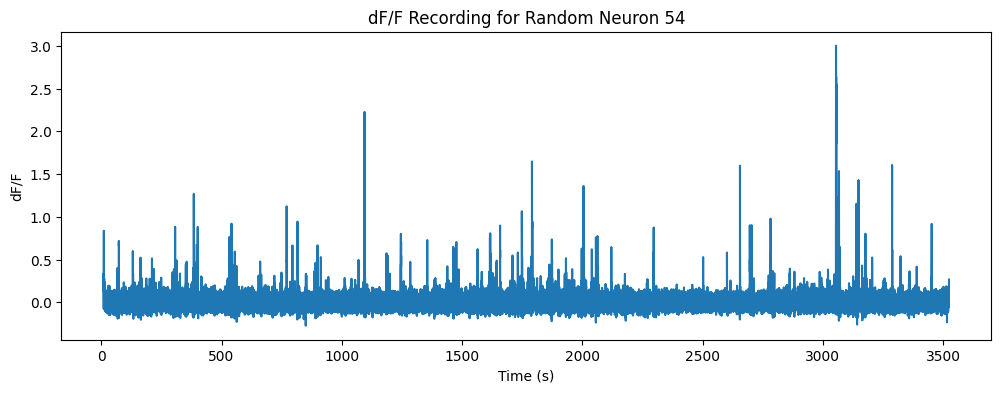

In [8]:
import numpy as np

import matplotlib.pyplot as plt

print(data["dff"].shape)

# Select a random neuron index
num_neurons = data["dff"].shape[0]
random_neuron_idx = np.random.randint(num_neurons)

# Plot the dff recording for the selected neuron
plt.figure(figsize=(12, 4))
plt.plot(data["t"], data["dff"][random_neuron_idx])
plt.title(f"dF/F Recording for Random Neuron {random_neuron_idx}")
plt.xlabel("Time (s)")
plt.ylabel("dF/F")
plt.show()

## Stimulus Meta-Data



# Stimulus

The stimulus consists of 9000 unique frames each of size $16 \times 28$ of gray scale values. The stimulus is defined as `locally_sparse_stimlus` and is active for certain subset of of the trial.

Shape of stimulus data (9000, 16, 28)


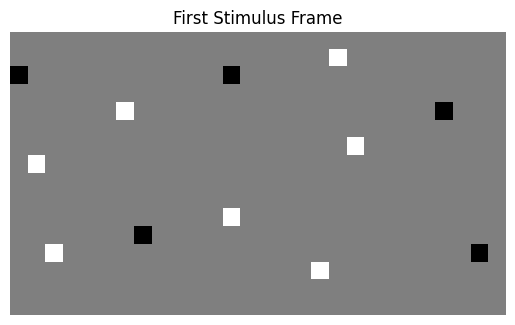

Number of unique stimulus frames: 9000


In [9]:
import matplotlib.pyplot as plt

print(f"Shape of stimulus data {data['stim'].shape}")

plt.imshow(data["stim"][0], cmap="gray")
plt.title("First Stimulus Frame")
plt.axis("off")
plt.show()
# Check uniqueness of stimulus frames
num_unique_frames = np.unique(
    data["stim"].reshape(data["stim"].shape[0], -1), axis=0
).shape[0]
print(f"Number of unique stimulus frames: {num_unique_frames}")
assert num_unique_frames == data["stim"].shape[0], "Not all stimulus frames are unique!"
# Confirm that each stimulus frame is unique, we were not sure about that

We save all of the stimuli in pictures. Currently this gets skipped because save_all_images_to_directory = False

In [10]:
import os
import matplotlib.pyplot as plt

save_all_images_to_directory = False
output_dir = "."
if save_all_images_to_directory:
    stim_frames = data["stim"]
    n_frames = stim_frames.shape[0]
    frames_per_page = 25
    n_pages = int(np.ceil(n_frames / frames_per_page))

    # Ensure output directory exists
    stim_grid_dir = os.path.join(output_dir, "stimulus_grids")
    os.makedirs(stim_grid_dir, exist_ok=True)

    for page in range(n_pages):
        fig, axes = plt.subplots(5, 5, figsize=(10, 10))
        axes = axes.flatten()
        start_idx = page * frames_per_page
        end_idx = min(start_idx + frames_per_page, n_frames)
        for i, ax in enumerate(axes):
            frame_idx = start_idx + i
            if frame_idx < end_idx:
                ax.imshow(stim_frames[frame_idx], cmap="gray")
                ax.set_title(f"Frame {frame_idx}")
            ax.axis("off")
        plt.tight_layout()
        filename = os.path.join(stim_grid_dir, f"stimulus_grid_page_{page+1}.png")
        plt.savefig(filename)
        plt.close(fig)
else:
    print(
        "Skipping saving all images to directory. Set `save_all_images_to_directory` to True to enable saving."
    )

Skipping saving all images to directory. Set `save_all_images_to_directory` to True to enable saving.


### What are locally sparse noise stimulus ?

**Locally Sparse**: In each frame, most of the screen is a neutral grey. Only a few, small, randomly 
chosen locations ("local") have either a black or a white square. The rest of the screen is blank ("sparse"). Later we will decide to split the stimuli frames into a white/grey and black/grey part.

## What is th frequency with which a particular stimulus frame is held ?

The `data['stim_table']` contains 8880 rows indicating the stimulus frame which is shown and duration  in both sample indices and the start and end time in seconds. Each of the 8880 rows contain one frame after the other all the way from $[0 -  8879]$ inclusive

In [11]:
print(f"Stim Table shape: {data['stim_table'].shape}")
data["stim_table"]

Stim Table shape: (8880, 3)


frame   start     end
0         0     737     744
1         1     745     752
2         2     752     759
3         3     760     767
4         4     767     774
...     ...     ...     ...
8875   8875  105705  105712
8876   8876  105712  105719
8877   8877  105720  105727
8878   8878  105727  105734
8879   8879  105735  105742

[8880 rows x 3 columns]

In [12]:
# Check that the frame in tim table is not repeated
# Check that the frame in stim_table is not repeated
num_unique_frames_in_table = data["stim_table"]["frame"].nunique()
num_total_frames_in_table = len(data["stim_table"]["frame"])
print(f"Unique frames in stim_table: {num_unique_frames_in_table}")
print(f"Total frames in stim_table: {num_total_frames_in_table}")
if num_unique_frames_in_table == num_total_frames_in_table:
    print("No repeated frames in stim_table.")
else:
    print("There are repeated frames in stim_table.")

Unique frames in stim_table: 8880
Total frames in stim_table: 8880
No repeated frames in stim_table.


In [13]:
# Che3ck that data["stim"] each row contains distinct unique frames.
# Check that each row in data["stim"] is unique
stim_reshaped = data["stim"].reshape(data["stim"].shape[0], -1)
num_unique_stim_frames = np.unique(stim_reshaped, axis=0).shape[0]
print(f"Number of unique frames in data['stim']: {num_unique_stim_frames}")
assert (
    num_unique_stim_frames == data["stim"].shape[0]
), "Not all frames in data['stim'] are unique!"

Number of unique frames in data['stim']: 9000


In [14]:
# The total number of samples by looking and the number of sample in each row  by takding difference of start and end sample points and adding them up gives
total_samples = np.sum(data["stim_table"]["end"] - data["stim_table"]["start"])
print(f"Total number of samples in the stimulus table: {total_samples}")

Total number of samples in the stimulus table: 62521


### Are all the frames in the stim table one ofter the other, that is incrementing by one on each row or not ?


In [15]:
# Check if 'frame' column increments by one for each row
frame_diffs = data["stim_table"]["frame"].diff().fillna(1)
all_consecutive = np.all(frame_diffs == 1)
print(f"Are all frames consecutive? {all_consecutive}")

# If not, show indices where it's not consecutive
if not all_consecutive:
    non_consecutive_indices = np.where(frame_diffs != 1)[0]
    print(f"Indices where frames are not consecutive: {non_consecutive_indices}")
    print(
        f"Frame values at those indices: {data['stim_table']['frame'].iloc[non_consecutive_indices].values}"
    )

Are all frames consecutive? True


 #### Are there any un accounted for gaps between start and end in the data['stim_table'], that is does the, start of one row proceed right after the end of the previous row?

In [16]:
import numpy as np

stim_table = data["stim_table"]
gaps = stim_table["start"].values[1:] - stim_table["end"].values[:-1]
print(f"Number of gaps found: {np.sum(gaps > 0)}")
if np.any(gaps > 0):
    print("There are gaps between start and end in the data['stim_table'].")
    print(f"Number of gaps found: {np.sum(gaps > 0)}")
    print(f"Indices of gaps found: {np.where(gaps > 0)[0]}")
    # what is the size of the gaps?
    gap_sizes = gaps[gaps > 0]
    print(f"Sizes of gaps found: {gap_sizes}")
    print(f"Start of gaps: {stim_table['start'].values[1:][gaps > 0]}")
    print(f"End of gaps: {stim_table['end'].values[:-1][gaps > 0]}")
    # what is the maximum gap size ?
    max_gap_size = np.max(gap_sizes)
    print(f"Maximum gap size: {max_gap_size}")
    # what is the minimum gap size ?
    min_gap_size = np.min(gap_sizes)
    print(f"Minimum gap size: {min_gap_size}")
    # what is the average gap size ?
    avg_gap_size = np.mean(gap_sizes)
    print(f"Average gap size: {avg_gap_size}")
    # what is the median gap size ?
    median_gap_size = np.median(gap_sizes)
    print(f"Median gap size: {median_gap_size}")
else:
    print("No gaps found between start and end in the data['stim_table'].")

Number of gaps found: 4462
There are gaps between start and end in the data['stim_table'].
Number of gaps found: 4462
Indices of gaps found: [   0    2    4 ... 8874 8876 8878]
Sizes of gaps found: [1 1 1 ... 1 1 1]
Start of gaps: [   745    760    775 ... 105705 105720 105735]
End of gaps: [   744    759    774 ... 105704 105719 105734]
Maximum gap size: 19015
Minimum gap size: 1
Average gap size: 9.521290900941281
Median gap size: 1.0


### Stimulus Epoch Table

The stimulus epoch table consists tells us the durations where locally_sparse_noise is active.

In [17]:
data["stim_epoch_table"]

start    end stimulus
0  locally_sparse_noise    737    22461
1           spontaneous  22611    31520
2     natural_movie_one  31521    40571
3  locally_sparse_noise  41476    63199
4     natural_movie_two  64105    73156
5           spontaneous  73306    82207
6  locally_sparse_noise  82208   105742

In [18]:
data.keys()

dict_keys(['t', 'dff', 'stim_table', 'stim', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])

# Mouse running Speed  Data

The element `data['running_speed']` contains information regarding the running speed of the mouse, it has 
the shape $2 \times 105968$ where `data['running_speed'][1]` consists of the running speed at points of time. The mouse running 
speed/behavioral data is not used in our current analysis.

In [19]:
data["running_speed"][1].shape

(105968,)

# What is the maximal activity projection?


The "Maximum Activity Projection" is a single summary image created by collapsing that entire movie into one picture.

For every single pixel in the 512x512 grid, the computer looks through all the frames of the movie and finds the highest (maximum) brightness value that pixel ever reached during the entire recording. It then creates a new, single image where each pixel's value is set to that maximum brightness.

The resulting image gives you a static, anatomical-like view of the recording area.

* **Bright Spots**: The brightest spots in the projection are typically the locations of neurons (or parts of neurons) that were highly active (i.e., had a large calcium influx, causing high fluorescence) at some point during the experiment.

* **Background**: The dimmer areas are parts of the tissue that were never highly fluorescent.

Why is it useful ?

It serves as an excellent anatomical reference map. It's the perfect background image to overlay  other spatial data on, such as:

The ROI masks to see the exact outlines of the detected neurons.

The receptive field centers, show where the "seeing" parts of the neurons are located relative to their physical bodies.

# ROI Masks
## What are ROI masks ?


ROI masks indicate the position and rough planar geometry of the nueron. Only ROI centers not their morphology is used in present analysis.

In [20]:
roi_masks = data["roi_masks"]
roi_masks.shape

(189, 512, 512)

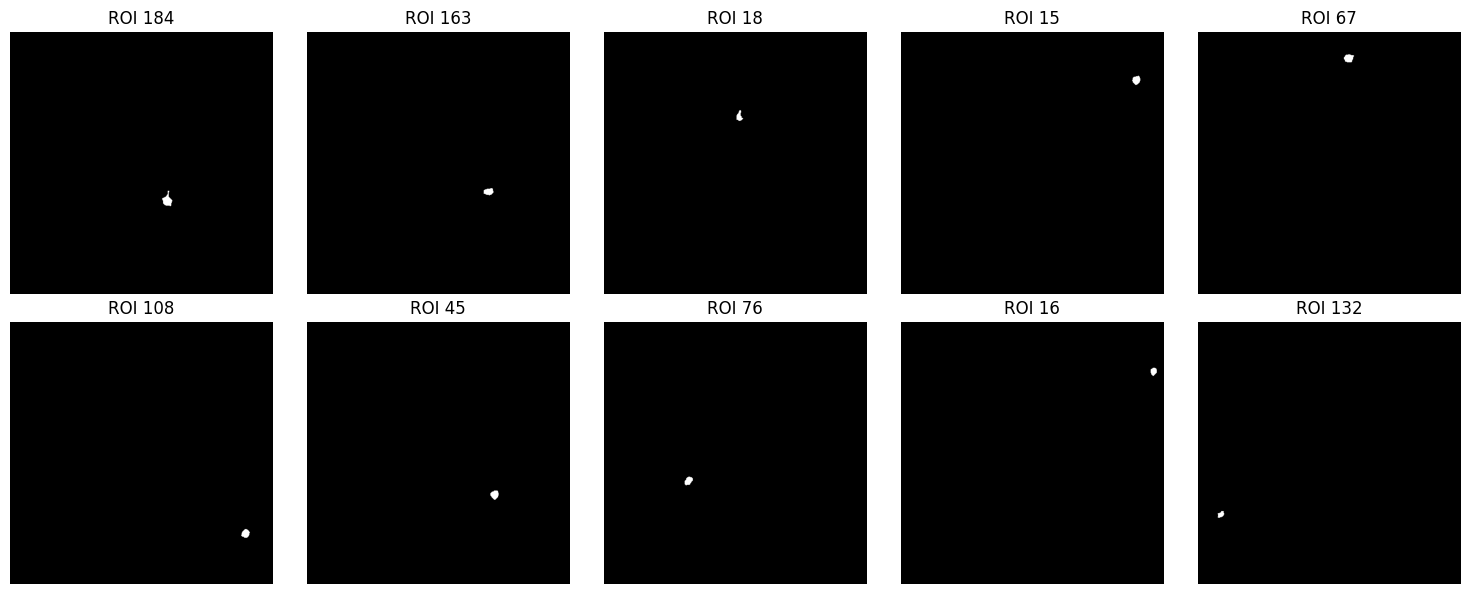

In [21]:
# Plot 10 random roi masks.
np.random.seed(42)
random_indices = np.random.choice(roi_masks.shape[0], size=10, replace=False)
roi_masks_to_plot = roi_masks[random_indices]

# plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(roi_masks_to_plot[i], cmap="gray")
    ax.set_title(f"ROI {random_indices[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

##### Save Processed Dataset

In [22]:
# import packages here
import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

# File paths
paths = {
    "dff": "dff_data_rf/dff.npy",
    "t": "dff_data_rf/t.npy",
    "stim": "dff_data_rf/stim.npy",
    "stim_table": "dff_data_rf/stim_table.npy",
    "stim_epoch_table": "dff_data_rf/stim_epoch_table.npy",
    "roi_masks": "dff_data_rf/roi_masks.npy",
    "max_projection": "dff_data_rf/max_projection.npy",
    "running_speed": "dff_data_rf/running_speed.npy",
}

In [23]:
import utils as ae
import importlib

importlib.reload(
    ae
)  # Reload ae_utils to ensure you're using the latest version of your functions

data = ae.load_data(paths)

print("dff:", data["dff"].shape)
print("t:", data["t"].shape)
print("stim:", data["stim"].shape)
print("stim_table:", data["stim_table"].shape)
print("stim_epoch_table:", data["stim_epoch_table"].shape)
print("First stim_epoch_table row:", data["stim_epoch_table"][0])

dff: (189, 105968)
t: (105968,)
stim: (9000, 16, 28)
stim_table: (8880, 3)
stim_epoch_table: (7, 3)
First stim_epoch_table row: ['locally_sparse_noise' 737 22461]


In [24]:
import utils as ae

# import isolate_sparse_epochs, compute_qc_metrics


mask = ae.isolate_sparse_epochs(data, target="locally_sparse_noise")
dff_sparse = data["dff"][:, mask]
t_sparse = data["t"][mask]
print(f"Sparse‑noise frames: {mask.sum()}")

var_raw, snr_raw = ae.compute_qc_metrics(dff_sparse)

data.update(
    {
        "mask_sparse": mask,
        "dff_sparse": dff_sparse,
        "t_sparse": t_sparse,
        "var_raw": var_raw,
        "snr_raw": snr_raw,
    }
)

Sparse‑noise frames: 66981


## 1.4 Repair & Store Running Speed

In [25]:
rs = data["running_speed"]  # shape: (2, T)
n_nans = [np.isnan(r).sum() for r in rs]
print(f"NaNs in running_speed rows: {n_nans}")

# pick the row with fewer NaNs as time
if n_nans[0] < n_nans[1]:
    run_t, run_speed = rs
else:
    run_speed, run_t = rs

run_speed = np.nan_to_num(run_speed, nan=0.0)

data.update(
    {
        "run_t": run_t,
        "run_speed": run_speed,
    }
)

print("run_t[:5]:    ", run_t[:5])
print("run_speed[:5]:", run_speed[:5])

NaNs in running_speed rows: [np.int64(299), np.int64(0)]
run_t[:5]:     [9.33015 9.36332 9.39649 9.42967 9.46284]
run_speed[:5]: [0. 0. 0. 0. 0.]


## 1.5 Flag “Good” vs. “Bad” Cells for Plotting

In [26]:
var_thr_raw = np.percentile(var_raw, 10)
snr_thr_raw = np.percentile(snr_raw, 10)
all_cells = np.arange(data["dff"].shape[0])
good_cells = np.where((var_raw > var_thr_raw) & (snr_raw > snr_thr_raw))[0]
bad_cells = np.setdiff1d(all_cells, good_cells)

print(f"Kept {len(good_cells)}/{len(all_cells)} cells after raw QC")

data.update(
    {
        "var_thr_raw": var_thr_raw,
        "snr_thr_raw": snr_thr_raw,
        "good_cells": good_cells,
        "bad_cells": bad_cells,
    }
)

Kept 151/189 cells after raw QC


## 1.6 Plotting

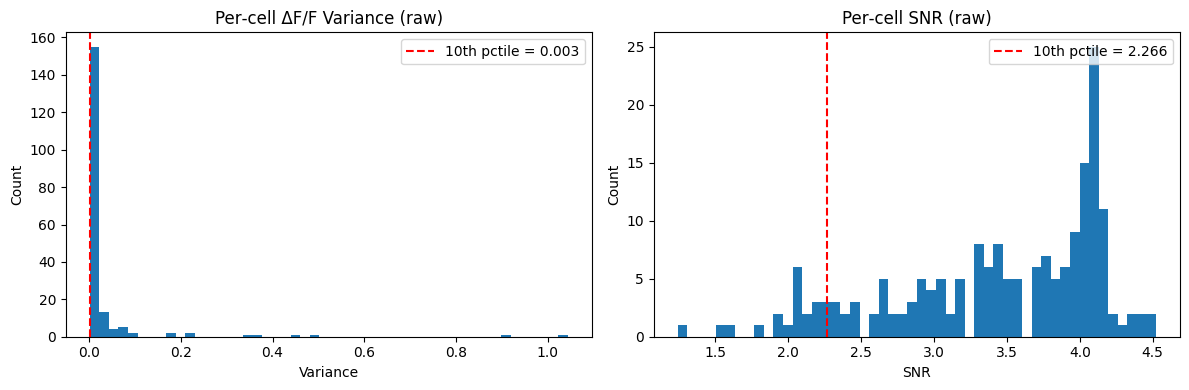

In [27]:
# QC — Raw ΔF/F Variance & SNR Distributions
import matplotlib.pyplot as plt

# recompute 10th‑percentile thresholds on the raw metrics
var_thr_raw = np.percentile(data["var_raw"], 10)
snr_thr_raw = np.percentile(data["snr_raw"], 10)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Variance (raw)
axs[0].hist(data["var_raw"], bins=50)
axs[0].axvline(
    var_thr_raw, color="r", linestyle="--", label=f"10th pctile = {var_thr_raw:.3f}"
)
axs[0].set_title("Per‑cell ΔF/F Variance (raw)")
axs[0].set_xlabel("Variance")
axs[0].set_ylabel("Count")
axs[0].legend()

# SNR (raw)
axs[1].hist(data["snr_raw"], bins=50)
axs[1].axvline(
    snr_thr_raw, color="r", linestyle="--", label=f"10th pctile = {snr_thr_raw:.3f}"
)
axs[1].set_title("Per‑cell SNR (raw)")
axs[1].set_xlabel("SNR")
axs[1].set_ylabel("Count")
axs[1].legend()

plt.tight_layout()
plt.show()

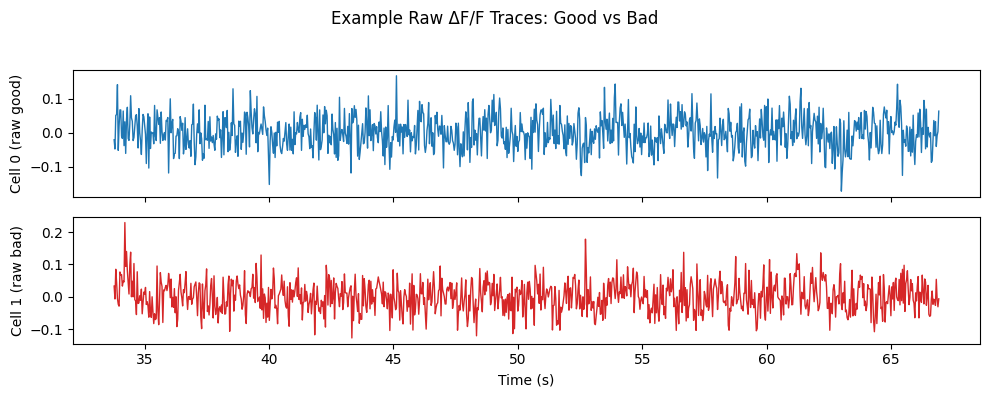

In [28]:
# QC — Example Raw ΔF/F Traces: “Good” vs. “Bad” (pre‑clean)

# recompute thresholds in case this cell is run independently
var_thr_raw = np.percentile(data["var_raw"], 10)
snr_thr_raw = np.percentile(data["snr_raw"], 10)

n_cells = data["dff"].shape[0]
raw_good = np.where((data["var_raw"] > var_thr_raw) & (data["snr_raw"] > snr_thr_raw))[
    0
]
raw_bad = np.setdiff1d(np.arange(n_cells), raw_good)

# pick one example of each
cg, cb = raw_good[0], raw_bad[0]

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax[0].plot(data["t_sparse"][:1000], data["dff_sparse"][cg, :1000], lw=1)
ax[0].set_ylabel(f"Cell {cg} (raw good)")
ax[1].plot(data["t_sparse"][:1000], data["dff_sparse"][cb, :1000], lw=1, color="C3")
ax[1].set_ylabel(f"Cell {cb} (raw bad)")
ax[1].set_xlabel("Time (s)")
plt.suptitle("Example Raw ΔF/F Traces: Good vs Bad")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [29]:
# QC: fraction of session that is sparse-noise
frac = data["mask_sparse"].mean()
print(f"Fraction of session in sparse-noise epochs: {frac:.3f} ({frac*100:.1f}%)")

Fraction of session in sparse-noise epochs: 0.632 (63.2%)


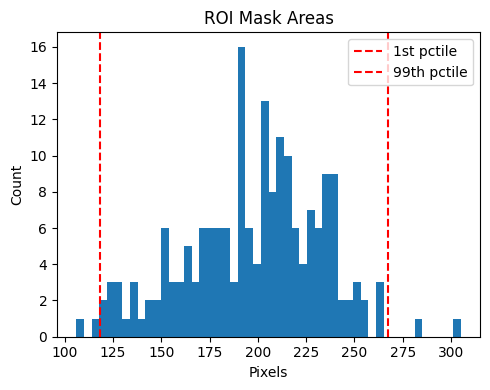

In [30]:
# QC — ROI‑Mask Area Distribution
areas = np.array([mask.sum() for mask in data["roi_masks"]])
p1 = np.percentile(areas, 1)
p99 = np.percentile(areas, 99)

plt.figure(figsize=(5, 4))
plt.hist(areas, bins=50)
plt.axvline(p1, color="r", linestyle="--", label="1st pctile")
plt.axvline(p99, color="r", linestyle="--", label="99th pctile")
plt.title("ROI Mask Areas")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

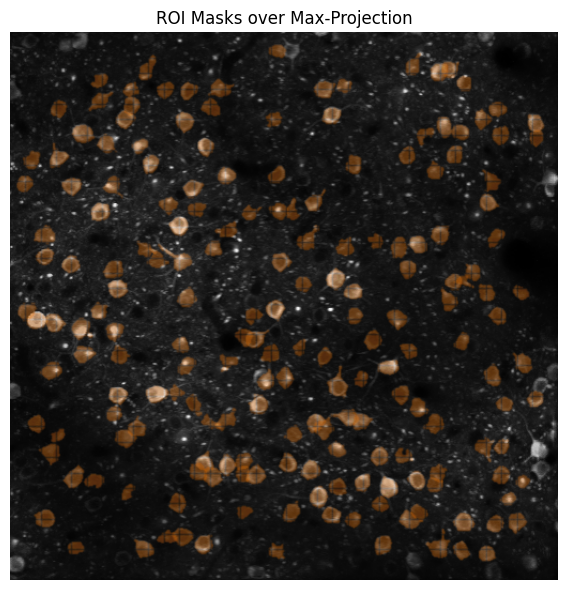

In [31]:
# QC — Overlay All ROI Masks on Max‑Projection
plt.figure(figsize=(6, 6))
plt.imshow(data["max_projection"], cmap="gray")
for i in range(data["roi_masks"].shape[0]):
    ys, xs = np.nonzero(data["roi_masks"][i])
    plt.scatter(xs, ys, s=1, alpha=0.05, color="C1")
plt.title("ROI Masks over Max‑Projection")
plt.axis("off")
plt.tight_layout()
plt.show()

In [32]:
# QC — Unique Epoch Names
epochs = data["stim_epoch_table"]
first = epochs[0]
name_col = next(i for i, x in enumerate(first) if isinstance(x, str))
names = epochs[:, name_col].astype(str)

print("Unique epoch names:\n", np.unique(names))

Unique epoch names:
 ['locally_sparse_noise' 'natural_movie_one' 'natural_movie_two'
 'spontaneous']


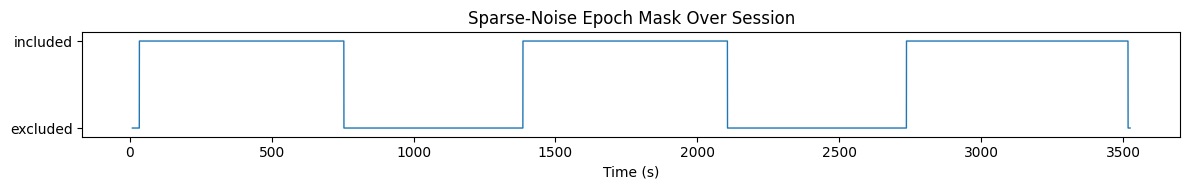

In [33]:
# QC — Sparse‑Noise Epoch Mask Timeline
plt.figure(figsize=(12, 2))
plt.plot(data["t"], data["mask_sparse"], lw=1)
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ["excluded", "included"])
plt.xlabel("Time (s)")
plt.title("Sparse‑Noise Epoch Mask Over Session")
plt.tight_layout()
plt.show()

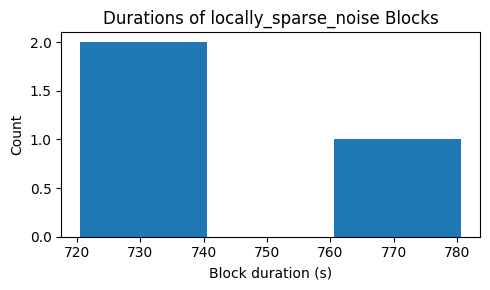

Mean block duration: 740.6s, n blocks = 3


In [34]:
# QC — Durations of locally_sparse_noise Blocks
idx = np.where(np.diff(data["mask_sparse"].astype(int)) != 0)[0] + 1
starts = idx[0::2]
ends = idx[1::2]
dts = np.median(np.diff(data["t"]))
durs = (ends - starts) * dts

plt.figure(figsize=(5, 3))
plt.hist(durs, bins=len(durs))
plt.xlabel("Block duration (s)")
plt.ylabel("Count")
plt.title("Durations of locally_sparse_noise Blocks")
plt.tight_layout()
plt.show()

print(f"Mean block duration: {durs.mean():.1f}s, n blocks = {len(durs)}")

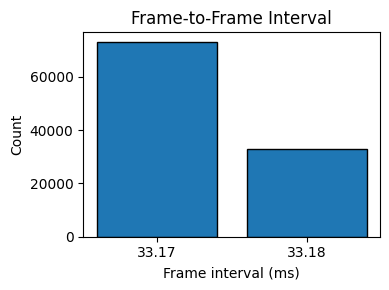

Frame intervals:
  33.17 ms → 73011 frames
  33.18 ms → 32956 frames
Median = 33.170 ms


In [35]:
# QC — Frame‑to‑Frame Interval Distribution (ms)
import numpy as np
import matplotlib.pyplot as plt

# 1) compute intervals in ms and round to two decimals
dts_ms = np.round(np.diff(data["t"]) * 1e3, 2)

# 2) get the two unique values and their counts
uni, counts = np.unique(dts_ms, return_counts=True)

# 3) bar‑plot with a small width so they sit side by side
fig, ax = plt.subplots(figsize=(4, 3))
bar_width = (uni[1] - uni[0]) * 0.8  # 80% of the gap
ax.bar(uni, counts, width=bar_width, edgecolor="k", color="C0")

# 4) tidy up axes
ax.set_xticks(uni)
ax.set_xticklabels([f"{u:.2f}" for u in uni])
ax.set_xlabel("Frame interval (ms)")
ax.set_ylabel("Count")
ax.set_title("Frame‑to‑Frame Interval")

plt.tight_layout()
plt.show()

# 5) print a concise summary
print(
    f"Frame intervals:\n"
    f"  {uni[0]:.2f} ms → {counts[0]} frames\n"
    f"  {uni[1]:.2f} ms → {counts[1]} frames\n"
    f"Median = {np.median(dts_ms):.3f} ms"
)

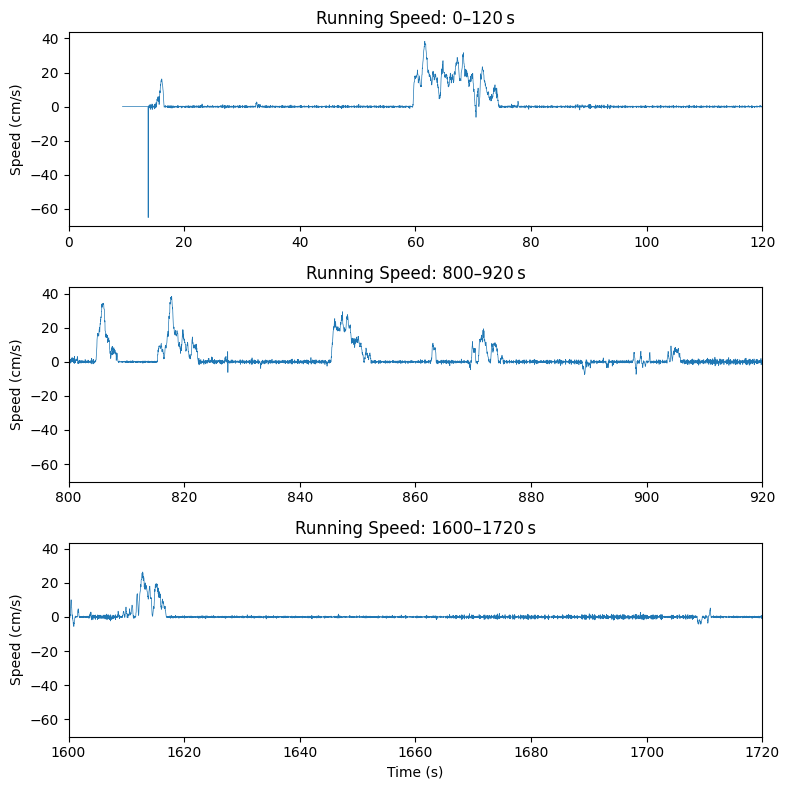

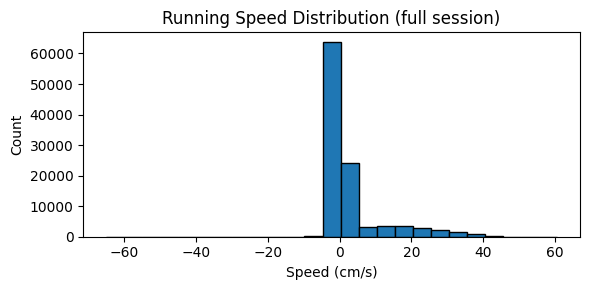

Speed stats — min: -65.1 cm/s, max: 60.6 cm/s, median: 0.1 cm/s


In [36]:
# QC — Running Speed Snippets Across Session

# retrieve cleaned time & speed
run_t = data["run_t"]
run_speed = data["run_speed"]

# define three 2‑minute windows (in seconds)
windows = [0, 800, 1600]

fig, axs = plt.subplots(len(windows), 1, figsize=(8, 8), sharey=True)

for ax, start in zip(axs, windows):
    # mask for 120‑s snippet
    mask = (run_t >= start) & (run_t < start + 120)
    ax.plot(run_t[mask], run_speed[mask], lw=0.5)
    ax.set_xlim(start, start + 120)
    ax.set_ylabel("Speed (cm/s)")
    ax.set_title(f"Running Speed: {start}–{start+120} s")

# label only the bottom axis
axs[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

# 3) histogram of full‐session speed
plt.figure(figsize=(6, 3))
plt.hist(run_speed, bins=25, edgecolor="k")
plt.xlabel("Speed (cm/s)")
plt.ylabel("Count")
plt.title("Running Speed Distribution (full session)")
plt.tight_layout()
plt.show()

# 4) concise printed stats
print(
    f"Speed stats — min: {run_speed.min():.1f} cm/s, "
    f"max: {run_speed.max():.1f} cm/s, "
    f"median: {np.median(run_speed):.1f} cm/s"
)

In [37]:
import numpy as np
import pandas as pd


def get_clean_stim_mapping(stim_table, t_full, mask_sparse, n_stim):
    """
    Builds a full‐length and sparse clean mapping from time to stimulus index,
    filling any gaps so that there are no -1s or out-of-range values.

    Args:
        stim_table (np.ndarray or pd.DataFrame): columns [frame, start, end] or [stim_idx, onset, duration].
        t_full (np.ndarray): full time vector (length = total timesteps).
        mask_sparse (np.ndarray of bool): mask of sparse‐selected timesteps.
        n_stim (int): number of stimulus frames.

    Returns:
        stim_id_full_clean (np.ndarray[int], shape=(len(t_full),)):
            Cleaned stimulus index at every timestep, no -1 or out of range.
        stim_id_clean (np.ndarray[int], shape=(mask_sparse.sum(),)):
            Subset for sparse‐selected timesteps.
    """
    # --- Step 1: build raw full‐length map using original function ---
    # It expects columns ['frame','start','end']
    active = np.full(len(t_full), -1, dtype=int)
    if isinstance(stim_table, np.ndarray):
        rows = [tuple(r) for r in stim_table]
    else:
        rows = stim_table[["frame", "start", "end"]].itertuples(index=False, name=None)
    for frame_id, start_idx, end_idx in rows:
        fid = int(frame_id)
        s = max(int(start_idx), 0)
        e = min(int(end_idx), len(t_full))
        if s < e:
            active[s:e] = fid
    stim_id_full = active

    # --- Step 2: mask invalid entries (−1 or ≥ n_stim) ---
    invalid = (stim_id_full < 0) | (stim_id_full >= n_stim)

    # --- Step 3: convert to float and mark invalid as NaN ---
    fm = stim_id_full.astype(float)
    fm[invalid] = np.nan

    # --- Step 4: forward‐fill then backward‐fill NaNs ---
    s = pd.Series(fm)
    s_ff = s.ffill().bfill()

    # --- Step 5: back to int, final check ---
    stim_id_full_clean = s_ff.astype(int).values
    assert np.all(
        (stim_id_full_clean >= 0) & (stim_id_full_clean < n_stim)
    ), "Clean full mapping has out‑of‑range indices!"

    # --- Step 6: extract sparse subset ---
    stim_id_clean = stim_id_full_clean[mask_sparse]

    # --- Return both maps ---
    return stim_id_full_clean, stim_id_clean


# === Usage example ===
# assuming `data` is in your namespace:
n_stim = data["stim"].shape[0]
t_full = data["t"]
mask_sparse = data["mask_sparse"]
stim_full_clean, stim_clean = get_clean_stim_mapping(
    data["stim_table"], t_full, mask_sparse, n_stim
)

print(
    "Full map cleaned:",
    stim_full_clean.shape,
    "| Unique IDs:",
    np.unique(stim_full_clean)[:10],
    "... total:",
    np.unique(stim_full_clean).size,
)
print(
    "Sparse map:",
    stim_clean.shape,
    "| Any invalid? ",
    np.any((stim_clean < 0) | (stim_clean >= n_stim)),
)
# Overwrite
data["stim_id"] = stim_full_clean
data["stim_id_clean"] = stim_clean

Full map cleaned: (105968,) | Unique IDs: [0 1 2 3 4 5 6 7 8 9] ... total: 8880
Sparse map: (66981,) | Any invalid?  False


# 1 Preprocessing

## Neuropil Subtraction

## Neuropil Estimation & Robust Regression (Huber) & Clamp ρ

Sources:
- Neuropil Estimation: https://www.sciencedirect.com/science/article/pii/S2667237522001813?via%3Dihub

Neuropil contamination correction:
- Proxy choice: We estimated the neuropil signal for each cell as the mean activity of all other ROIs, which balances spatial locality and noise reduction.
- Robust fitting: We fit the contamination coefficient ρ via Huber regression (δ tuned to down‑weight large residuals) to mitigate the influence of transient motion artifacts or synchronous network bursts.
- Clamping: Fitted ρ values were constrained to [0, 0.9] to enforce physiological plausibility and prevent over‑subtraction.


In [38]:
# Step Neuropil Estimation & Robust Regression

# Grab all sparse‐noise ΔF/F traces
dff_sparse_all = data["dff_sparse"]  # shape: (n_cells, n_time)

# Estimate neuropil proxy (mean of other cells)
neuropil_proxy = ae.estimate_neuropil_proxy(dff_sparse_all)

# Perform robust per‐cell regression & clamp ρ to [0.5, 0.9]
dff_regressed, rho_neuropil = ae.regress_neuropil_robust(
    dff_sparse_all, neuropil_proxy, clamp=(0.0, 0.9)
)

# Store results for downstream steps
data.update(
    {
        "neuropil_proxy": neuropil_proxy,
        "dff_regressed": dff_regressed,
        "rho_neuropil": rho_neuropil,
    }
)

# 5) Quick sanity check
print(f"Neuropil regression done for {dff_regressed.shape[0]} cells.")
print("Example ρ values (first 5 cells):", rho_neuropil[:5])

Neuropil regression done for 189 cells.
Example ρ values (first 5 cells): [0.17324905 0.2983702  0.42147005 0.26641281 0.34971622]


## 2.2 QC of Neuropil Regression

### 2.2.1 ρ Distribution

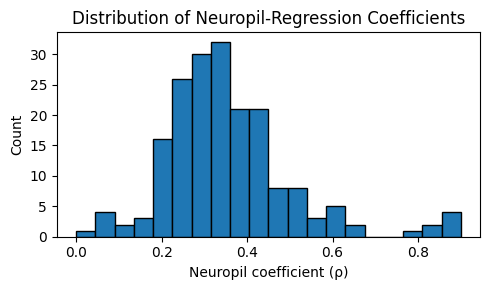

Min ρ = 0.00,  Max ρ = 0.90,  Median ρ = 0.34


In [39]:
# Histogram of ρ values
rho = data["rho_neuropil"]
plt.figure(figsize=(5, 3))
plt.hist(rho, bins=20, edgecolor="k")
plt.xlabel("Neuropil coefficient (ρ)")
plt.ylabel("Count")
plt.title("Distribution of Neuropil‐Regression Coefficients")
plt.tight_layout()
plt.show()

print(
    f"Min ρ = {rho.min():.2f},  Max ρ = {rho.max():.2f},  Median ρ = {np.median(rho):.2f}"
)

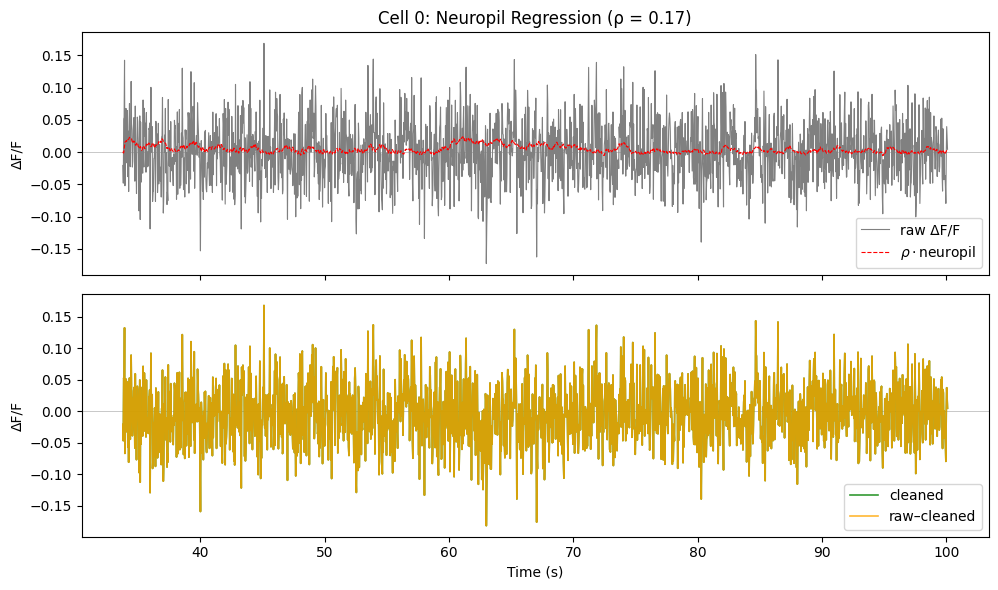

In [40]:
# pick a “good” cell to inspect
cell = data["good_cells"][0]

# pull out the first 2000 sparse‐noise frames
t0 = data["t_sparse"][:2000]
raw0 = data["dff_sparse"][cell, :2000]
np0 = data["neuropil_proxy"][cell, :2000]
rho0 = data["rho_neuropil"][cell]
clean = data["dff_regressed"][cell, :2000]
resid = raw0 - rho0 * np0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# 1) zero baseline lines
for ax in (ax1, ax2):
    ax.axhline(0, color="k", lw=0.5, alpha=0.3)

# 2) Top panel: raw vs. scaled neuropil
ax1.plot(t0, raw0, lw=0.8, color="gray", label="raw ΔF/F")
ax1.plot(
    t0, rho0 * np0, lw=0.8, color="red", linestyle="--", label=r"$\rho\cdot$neuropil"
)
ax1.set_ylabel("ΔF/F")
ax1.set_title(f"Cell {cell}: Neuropil Regression (ρ = {rho0:.2f})")
ax1.legend(loc="lower right")

# 3) Bottom panel: cleaned vs. raw–cleaned residual
ax2.plot(t0, clean, lw=1.2, alpha=0.8, color="green", label="cleaned")
ax2.plot(t0, resid, lw=1.2, alpha=0.8, color="orange", label="raw–cleaned")
ax2.set_ylabel("ΔF/F")
ax2.set_xlabel("Time (s)")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Baseline Correction & Denoising

We computed a running baseline for each trace as the 10th percentile over a 60-s sliding window (nearest‑neighbor boundary handling). This captures slow fluctuations in fluorescence without distorting fast transients.


### Drift Removal (60 s 10th‑percentile)

In [41]:
# Drift Removal via Sliding‐Window Percentile Baseline
from utils import sliding_baseline

# inputs: neuropil‐regressed ΔF/F and its timebase
dff_in = data["dff_regressed"]  # shape: (n_cells, n_time)
tvec = data["t_sparse"]  # shape: (n_time,)

# compute & subtract 10th‐percentile baseline over 60 s windows
baseline, dff_drift, win_frames = sliding_baseline(
    dff_in,
    tvec,
    window_sec=60,  # window length in seconds
    pct=10,  # percentile for baseline
    mode="nearest",  # boundary handling
)

# store for downstream steps
data.update(
    {
        "dff_baseline": baseline,
        "dff_drift": dff_drift,
        "drift_win": win_frames,
    }
)

# report
dt = np.median(np.diff(tvec))
print(f"Drift‐window: {win_frames} frames (~{win_frames*dt:.1f} s)")

Drift‐window: 1809 frames (~60.0 s)


## QC of Drift Removal

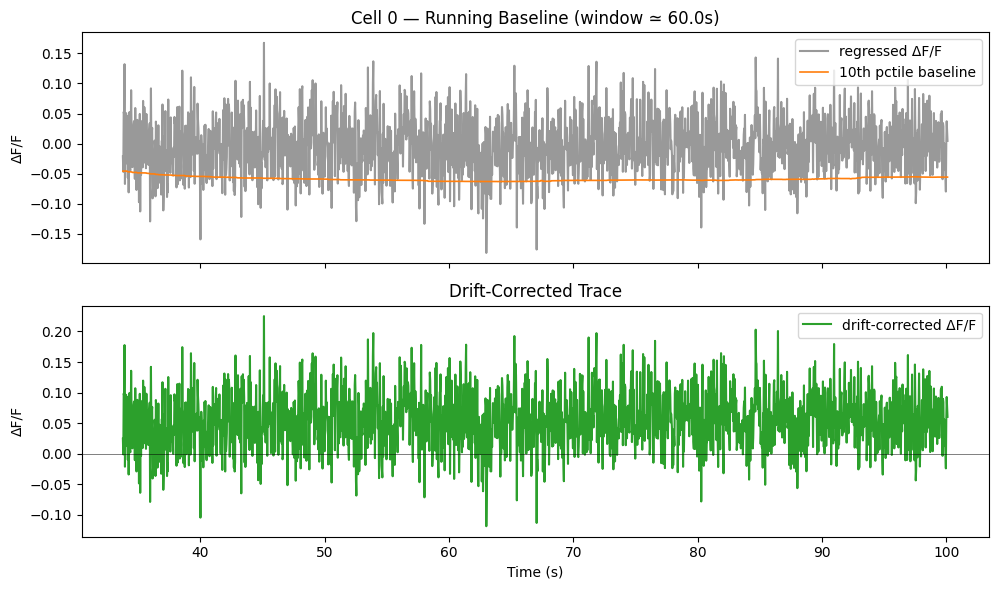

In [42]:
# Plot Baseline & Drift‐Corrected for One Example Cell

# pick a “good” cell for visualization
cell = data["good_cells"][0]
t0 = data["t_sparse"][:2000]
raw = data["dff_regressed"][cell, :2000]
bl = data["dff_baseline"][cell, :2000]
corr = data["dff_drift"][cell, :2000]

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# top: raw & running baseline
ax[0].plot(t0, raw, color="gray", label="regressed ΔF/F", alpha=0.8)
ax[0].plot(t0, bl, color="C1", label=f"{10}th pctile baseline", lw=1.2)
ax[0].set_ylabel("ΔF/F")
ax[0].set_title(
    f"Cell {cell} — Running Baseline (window ≃ {data['drift_win']*dt:.1f}s)"
)
ax[0].legend(loc="upper right")

# bottom: drift‐removed trace
ax[1].plot(t0, corr, color="C2", label="drift‑corrected ΔF/F")
ax[1].axhline(0, color="k", lw=0.5, alpha=0.7)
ax[1].set_ylabel("ΔF/F")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Drift‑Corrected Trace")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Savitzky–Golay Smoothing (w=11, p=2)

We apply temporal stmoothing: A Savitzky–Golay filter (window = 11 frames, polynomial order = 2) was applied to the drift‑corrected traces to suppress high‑frequency noise while preserving the shape of calcium transients.

In [43]:
# Savitzky–Golay Smoothing
from utils import smooth_dff_savgol

sg_window = 11  # frames
sg_poly = 2  # polynomial order

# pull the drift‑corrected traces
dff_dc = data["dff_drift"]  # shape (n_cells, n_time)

# smooth them
dff_smooth = smooth_dff_savgol(dff_dc, window=sg_window, polyorder=sg_poly)

# store back
data["dff_smooth"] = dff_smooth

print(f"Savitzky–Golay smoothing → window={sg_window}, polyorder={sg_poly}")
print("Smoothed shape:", dff_smooth.shape)

Savitzky–Golay smoothing → window=11, polyorder=2
Smoothed shape: (189, 66981)


## QC of Smoothed Traces

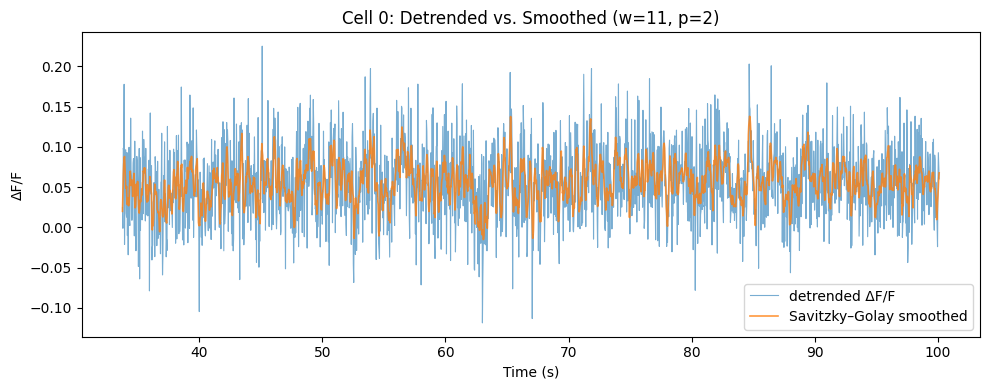

In [44]:
# QC: Example Raw vs. Smoothed Trace

cell = data["good_cells"][0]
t0 = data["t_sparse"][:2000]

raw0 = dff_dc[cell, :2000]
smooth0 = data["dff_smooth"][cell, :2000]

plt.figure(figsize=(10, 4))
plt.plot(t0, raw0, lw=0.8, alpha=0.6, label="detrended ΔF/F")
plt.plot(t0, smooth0, lw=1.2, alpha=0.8, label="Savitzky–Golay smoothed")
plt.xlabel("Time (s)")
plt.ylabel("ΔF/F")
plt.title(f"Cell {cell}: Detrended vs. Smoothed (w={sg_window}, p={sg_poly})")
plt.legend()
plt.tight_layout()
plt.show()

# 5 Final QC on Cleaned Data

## 5.1 Compute Clean ΔF/F QC Metrics

In [45]:
# QC on Final Cleaned ΔF/F
from utils import compute_qc_metrics


# 1) Pull in your final cleaned traces
dff_clean = data["dff_smooth"]  # shape (n_cells, n_time)

# 2) Compute per‑cell variance & S NR
var_clean, snr_clean = compute_qc_metrics(dff_clean)

# 3) Compute 10th‐percentile thresholds
var_thr_clean = np.percentile(var_clean, 10)
snr_thr_clean = np.percentile(snr_clean, 10)

# 4) Store them for downstream
data.update(
    {
        "var_clean": var_clean,
        "snr_clean": snr_clean,
        "var_thr_clean": var_thr_clean,
        "snr_thr_clean": snr_thr_clean,
    }
)

# 5) Quick summary
n_pass = np.sum((var_clean > var_thr_clean) & (snr_clean > snr_thr_clean))
print(f"Cleaned ΔF/F QC thresholds: var>{var_thr_clean:.3f}, snr>{snr_thr_clean:.3f}")
print(f"Cells passing cleaned‐QC: {n_pass}/{len(var_clean)}")

Cleaned ΔF/F QC thresholds: var>0.001, snr>1.770
Cells passing cleaned‐QC: 151/189


## 5.2 Compare Raw vs Clean Variance & SNR Distributions

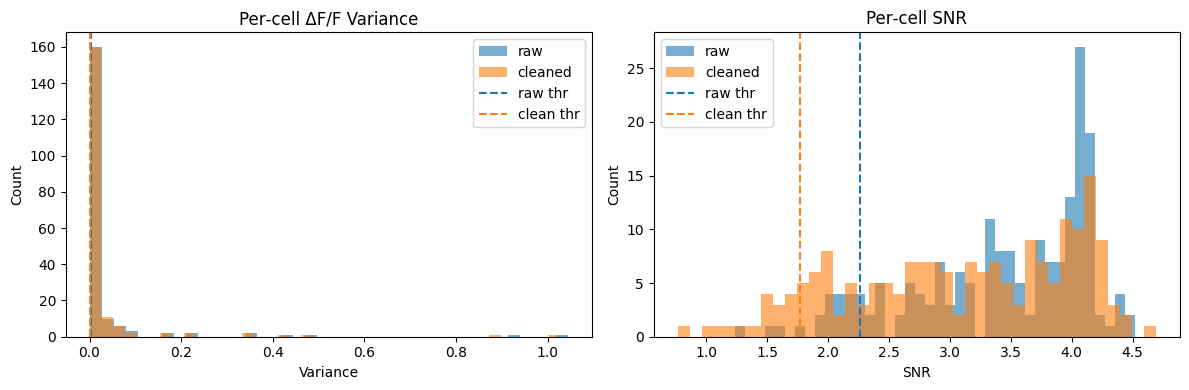

In [46]:
# Histograms: raw vs. cleaned variance & SNR
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Variance
axs[0].hist(data["var_raw"], bins=40, alpha=0.6, label="raw")
axs[0].hist(data["var_clean"], bins=40, alpha=0.6, label="cleaned")
axs[0].axvline(data["var_thr_raw"], color="C0", linestyle="--", label="raw thr")
axs[0].axvline(data["var_thr_clean"], color="C1", linestyle="--", label="clean thr")
axs[0].set_title("Per‑cell ΔF/F Variance")
axs[0].set_xlabel("Variance")
axs[0].set_ylabel("Count")
axs[0].legend()

# SNR
axs[1].hist(data["snr_raw"], bins=40, alpha=0.6, label="raw")
axs[1].hist(data["snr_clean"], bins=40, alpha=0.6, label="cleaned")
axs[1].axvline(data["snr_thr_raw"], color="C0", linestyle="--", label="raw thr")
axs[1].axvline(data["snr_thr_clean"], color="C1", linestyle="--", label="clean thr")
axs[1].set_title("Per‑cell SNR")
axs[1].set_xlabel("SNR")
axs[1].set_ylabel("Count")
axs[1].legend()

plt.tight_layout()
plt.show()

Left panel: Histogram of per‑cell raw ΔF/F variance across the entire dataset. The distribution is heavily right‑skewed, and the red dashed line marks the 10ᵗʰ percentile (0.003), below which cells were flagged for insufficient fluctuation amplitude.

Right panel: Histogram of per‑cell raw signal‑to‑noise ratio (SNR). Again right‑skewed, with the 10ᵗʰ percentile (2.266) shown by the red dashed line—cells below this SNR threshold were considered too noisy for reliable analysis.

## 5.3 Full‐Pipeline Trace Overlay

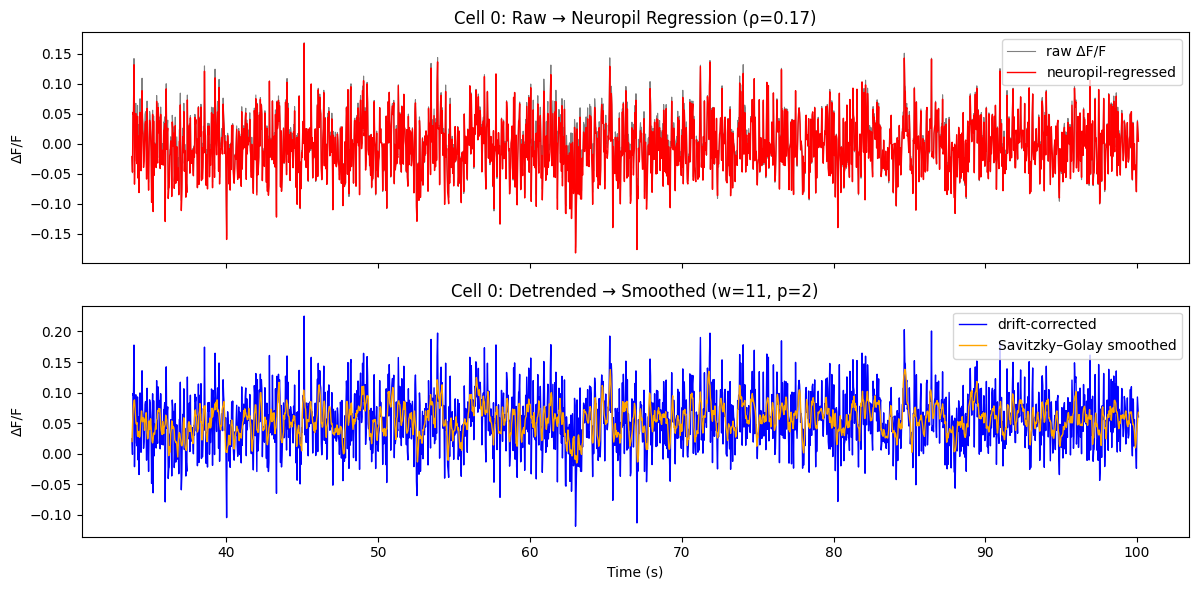

In [47]:
# QC — Full Cleaning Pipeline Overlay (first 2 000 frames)


# pick one good cell for demonstration
cell = data["good_cells"][0]
n0 = 2000  # number of frames

# pull out the four versions of this cell’s trace
t0 = data["t_sparse"][:n0]
raw0 = data["dff_sparse"][cell, :n0]
reg0 = data["dff_regressed"][cell, :n0]
detr0 = data["dff_drift"][cell, :n0]  # drift‑corrected
smooth0 = data["dff_smooth"][cell, :n0]  # Savitzky–Golay smoothed

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# top: raw vs. neuropil‑regressed
ax1.plot(t0, raw0, color="gray", linewidth=0.8, label="raw ΔF/F")
ax1.plot(t0, reg0, color="red", linewidth=1, label="neuropil‑regressed")
ax1.set_ylabel("ΔF/F")
ax1.set_title(
    f"Cell {cell}: Raw → Neuropil Regression (ρ={data['rho_neuropil'][cell]:.2f})"
)
ax1.legend(loc="upper right")

# bottom: drift‑corrected vs. smoothed
ax2.plot(t0, detr0, color="blue", linewidth=1, label="drift‑corrected")
ax2.plot(t0, smooth0, color="orange", linewidth=1, label="Savitzky–Golay smoothed")
ax2.set_ylabel("ΔF/F")
ax2.set_xlabel("Time (s)")
ax2.set_title(f"Cell {cell}: Detrended → Smoothed (w={sg_window}, p={sg_poly})")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

## 6. Spike Inference & Hyperparameter Sweeps

## 6.1 Estimate per‑cell noise for deconvolution

In [48]:
import utils as ae

# Noise Estimation

dff_for_noise = data["dff_smooth"]
dt = np.median(np.diff(data["t_sparse"]))
print(f"dt = {dt:.5f} s (≈{1.0/dt:.1f} Hz)")

# per‑frame σ (OASIS expects noise per sample)
noise_sigma = ae.estimate_noise_sigma(dff_for_noise)
data.update({"noise_sigma": noise_sigma, "noise_dt": dt})

print("Estimated noise_sigma for each cell:")
print(noise_sigma[:5])

dt = 0.03317 s (≈30.1 Hz)
Estimated noise_sigma for each cell:
[0.00790449 0.00743161 0.00830615 0.00931993 0.00912261]


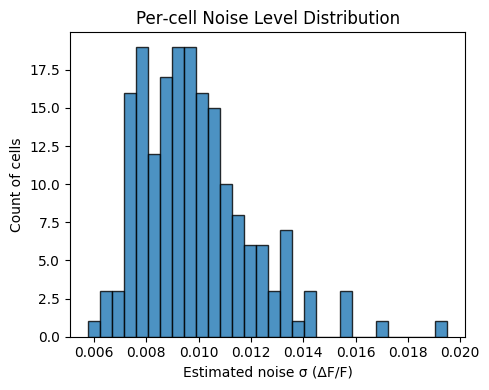

In [49]:
# QC — Distribution of Estimated Noise σ

sigma = data["noise_sigma"]

plt.figure(figsize=(5, 4))
plt.hist(sigma, bins=30, edgecolor="k", alpha=0.8)
plt.xlabel("Estimated noise σ (ΔF/F)")
plt.ylabel("Count of cells")
plt.title("Per‑cell Noise Level Distribution")
plt.tight_layout()
plt.show()

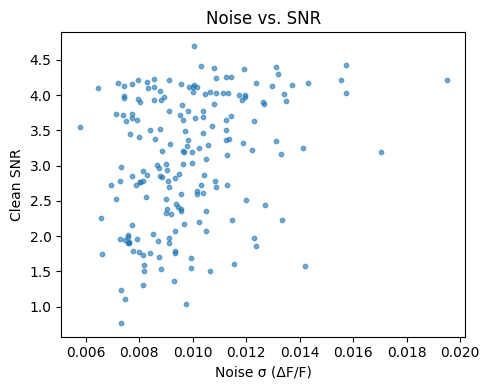

In [50]:
# QC — Noise vs. SNR
plt.figure(figsize=(5, 4))
plt.scatter(data["noise_sigma"], data["snr_clean"], s=10, alpha=0.6)
plt.xlabel("Noise σ (ΔF/F)")
plt.ylabel("Clean SNR")
plt.title("Noise vs. SNR")
plt.tight_layout()
plt.show()

## 6.2 Spike Inference — OASIS Deconvolution

In [51]:
# OASIS Deconvolution
dff_in = data["dff_smooth"]
dt = data["noise_dt"]
fs = 1.0 / dt

oas_res = ae.deconvolve_oasis(
    dff=dff_in, fs=fs, penalty=1, g_init=None, optimize_g=False
)

data.update(
    {
        "oasis_c": oas_res["c"],
        "oasis_s": oas_res["s"],
        "oasis_b": oas_res["b"],
        "oasis_g": oas_res["g"],
        "oasis_fs": fs,
    }
)

total_time = dff_in.shape[1] * dt
event_rate = oas_res["s"].sum(axis=1) / total_time
data["oasis_rate"] = event_rate

print("OASIS deconvolution complete")
print("Example AR(1) g:", np.round(oas_res["g"][:5], 3))
print("Example rates (Hz):", np.round(event_rate[:5], 3))

/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


OASIS deconvolution complete
Example AR(1) g: [0.91  0.812 0.884 0.885 0.801]
Example rates (Hz): [0.141 0.246 0.203 0.219 0.318]


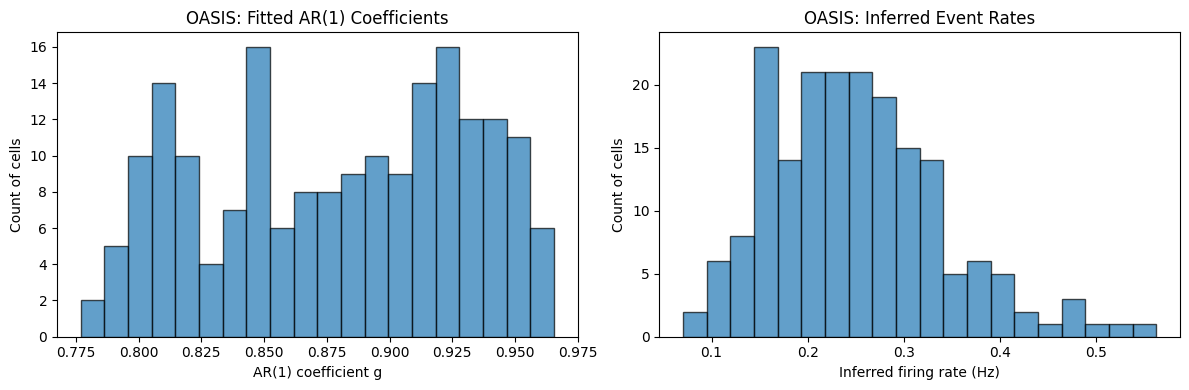

In [52]:
# QC — AR(1) coefficients & event‐rate distributions

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# AR(1) g
axs[0].hist(data["oasis_g"], bins=20, edgecolor="k", alpha=0.7)
axs[0].set_xlabel("AR(1) coefficient g")
axs[0].set_ylabel("Count of cells")
axs[0].set_title("OASIS: Fitted AR(1) Coefficients")

# Event rates
axs[1].hist(data["oasis_rate"], bins=20, edgecolor="k", alpha=0.7)
axs[1].set_xlabel("Inferred firing rate (Hz)")
axs[1].set_ylabel("Count of cells")
axs[1].set_title("OASIS: Inferred Event Rates")

plt.tight_layout()
plt.show()

## 6.3 Compute Reconstruction & Fit Metrics

In [53]:
# Fit‑Quality Scoring
from sklearn.metrics import r2_score
from utils import reconvolve_calcium_kernel

s_hat = data["oasis_s"]
g_hat = data["oasis_g"]
b_hat = data["oasis_b"]
y_clean = data["dff_smooth"]
dt = data["noise_dt"]
n_cells, n_t = s_hat.shape

# reconstruct via AR(1)
y_rec = np.zeros_like(y_clean)
for i in range(n_cells):
    y_rec[i] = reconvolve_calcium_kernel(s_hat[i], g_hat[i], b_hat[i])

# compute metrics
ss_res = np.sum((y_clean - y_rec) ** 2, axis=1)
ss_tot = np.sum((y_clean - y_clean.mean(axis=1, keepdims=True)) ** 2, axis=1)
r2 = 1 - ss_res / ss_tot
mse = ss_res / n_t

event_counts = s_hat.sum(axis=1)
rates_hz = event_counts / (n_t * dt)

fit_qc = pd.DataFrame(
    {
        "r2": r2,
        "mse": mse,
        "event_count": event_counts.astype(int),
        "rate_hz": rates_hz,
        "g_ar1": g_hat,
    },
    index=pd.Index(np.arange(n_cells), name="cell"),
)

data["fit_qc"] = fit_qc
print(f"Computed fit metrics for {n_cells} cells.")
display(fit_qc.head())

Computed fit metrics for 189 cells.


r2       mse  event_count   rate_hz     g_ar1
cell                                                     
0     0.957045  0.000109          314  0.141400  0.909569
1     0.928566  0.000049          546  0.245809  0.812061
2     0.951188  0.000118          449  0.202521  0.884358
3     0.961551  0.000132          486  0.218756  0.884707
4     0.912741  0.000079          706  0.318021  0.800697

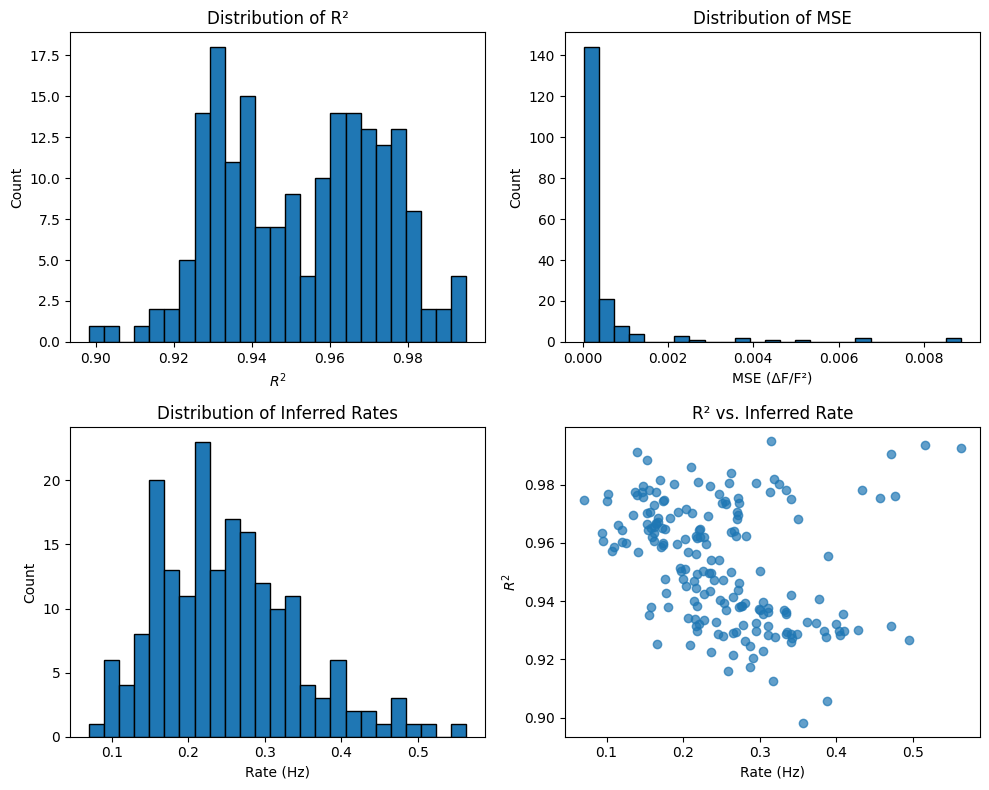

In [54]:
# Visualize Fit‑Quality Distributions
df = data["fit_qc"]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# R² histogram
axs[0, 0].hist(df["r2"], bins=25, edgecolor="k")
axs[0, 0].set_title("Distribution of R²")
axs[0, 0].set_xlabel("$R^2$")
axs[0, 0].set_ylabel("Count")

# MSE histogram
axs[0, 1].hist(df["mse"], bins=25, edgecolor="k")
axs[0, 1].set_title("Distribution of MSE")
axs[0, 1].set_xlabel("MSE (ΔF/F²)")
axs[0, 1].set_ylabel("Count")

# Event‐rate histogram
axs[1, 0].hist(df["rate_hz"], bins=25, edgecolor="k")
axs[1, 0].set_title("Distribution of Inferred Rates")
axs[1, 0].set_xlabel("Rate (Hz)")
axs[1, 0].set_ylabel("Count")

# R² vs. rate scatter
axs[1, 1].scatter(df["rate_hz"], df["r2"], alpha=0.7)
axs[1, 1].set_title("R² vs. Inferred Rate")
axs[1, 1].set_xlabel("Rate (Hz)")
axs[1, 1].set_ylabel("$R^2$")

plt.tight_layout()
plt.show()

## 6.4 Hyperparamter Sweeps

In [55]:
# # Hyperparameter Sweep
# from utils import sweep_oasis_params

# # random search: N=25 pairs
# rng = np.random.default_rng(0)
# N_draws = 25
# g_rand = rng.uniform(0.6, 0.95, size=N_draws)
# lam_rand = np.exp(rng.uniform(np.log(0.1), np.log(3.0), size=N_draws))
# params = list(zip(g_rand, lam_rand))

# cells_to_test = data["good_cells"][:50]
# fs_sweep = 1.0 / np.median(np.diff(data["t_sparse"]))

# results_df = sweep_oasis_params(
#     dff_clean=data["dff_smooth"],
#     fs=fs_sweep,
#     noise_sigma=data["noise_sigma"],
#     params=params,
#     cells=cells_to_test,
#     n_jobs=-1,
# )

# summary = (
#     results_df.groupby(["g", "lam"])["r2"]
#     .mean()
#     .reset_index()
#     .sort_values("r2", ascending=False)
# )
# print("Top 10 parameter combos by avg R²:")
# print(summary.head(10))

### RESULTS #####
# Top 10 parameter combos by avg R²:
#           g       lam        r2
# 0  0.600958  0.521961  0.981948
# 1  0.605785  1.029505  0.981858
# 2  0.609912  2.065585  0.981780
# 3  0.611755  2.397152  0.981745
# 4  0.614341  2.810689  0.981690
# 5  0.643499  0.216541  0.980871
# 6  0.661479  0.698584  0.980201
# 7  0.694425  2.971666  0.978656
# 8  0.704899  0.315599  0.978066
# 9  0.747941  0.378851  0.974936

In [56]:
# # Final OASIS with per-cell g optimization
# from tqdm.notebook import tqdm
# import ae_utils as ae


# dff_clean = data["dff_smooth"]
# fs = data["oasis_fs"]  # 1/dt
# lam_opt = 0.5220  # from sweep
# g_init = 0.6010  # from sweep
# n_cells, n_t = dff_clean.shape

# # pre-allocate output arrays
# c_opt = np.zeros_like(dff_clean)
# s_opt = np.zeros_like(dff_clean)
# b_opt = np.zeros(n_cells, float)
# g_opt = np.zeros(n_cells, float)

# print("Running optimized deconvolution for each cell:")
# for i in tqdm(range(n_cells), desc="OASIS per cell"):
#     out = ae.deconvolve_oasis(
#         dff=dff_clean[i : i + 1, :],  # single-cell slice
#         fs=fs,
#         penalty=lam_opt,
#         g_init=g_init,
#         optimize_g=True,
#     )
#     c_opt[i] = out["c"][0]
#     s_opt[i] = out["s"][0]
#     b_opt[i] = out["b"][0]
#     g_opt[i] = out["g"][0]

# # unpack into your data dict
# data["oas_c_opt"] = c_opt
# data["oas_s_opt"] = s_opt
# data["oas_b_opt"] = b_opt
# data["oas_g_opt"] = g_opt

# # now recompute true fit metrics
# r2_opt, mse_opt, event_counts, rate_hz = ae.compute_fit_metrics(
#     y_true=dff_clean,
#     s_hat=data["oas_s_opt"],
#     g_hat=data["oas_g_opt"],
#     b_hat=data["oas_b_opt"],
#     fs=fs,
# )

# # update your QC table
# data["fit_qc"]["r2"] = r2_opt
# data["fit_qc"]["mse"] = mse_opt
# data["fit_qc"]["event_count"] = event_counts
# data["fit_qc"]["rate_hz"] = rate_hz

# print("Recomputed fit metrics on optimized traces.")
# display(data["fit_qc"].head())


#### RESULTS #####
# Running optimized deconvolution for each cell:
# Error displaying widget: model not found
# Recomputed fit metrics on optimized traces.
# r2	mse	event_count	rate_hz	g_ar1
# cell
# 0	0.990210	0.000025	958	0.431190	0.892800
# 1	0.961720	0.000026	1042	0.468998	0.802260
# 2	0.983970	0.000039	1289	0.580171	0.835849
# 3	0.990251	0.000034	1349	0.607176	0.866176
# 4	0.947841	0.000047	1242	0.559016	0.803398

In [57]:
import numpy as np
import pandas as pd


def get_clean_stim_mapping(stim_table, t_full, mask_sparse, n_stim):
    """
    Builds a full‐length and sparse clean mapping from time to stimulus index,
    filling any gaps so that there are no -1s or out-of-range values.

    Args:
        stim_table (np.ndarray or pd.DataFrame): columns [frame, start, end] or [stim_idx, onset, duration].
        t_full (np.ndarray): full time vector (length = total timesteps).
        mask_sparse (np.ndarray of bool): mask of sparse‐selected timesteps.
        n_stim (int): number of stimulus frames.

    Returns:
        stim_id_full_clean (np.ndarray[int], shape=(len(t_full),)):
            Cleaned stimulus index at every timestep, no -1 or out of range.
        stim_id_clean (np.ndarray[int], shape=(mask_sparse.sum(),)):
            Subset for sparse‐selected timesteps.
    """
    # Step 1: build raw full‐length map using original function ---
    # It expects columns ['frame','start','end']
    active = np.full(len(t_full), -1, dtype=int)
    if isinstance(stim_table, np.ndarray):
        rows = [tuple(r) for r in stim_table]
    else:
        rows = stim_table[["frame", "start", "end"]].itertuples(index=False, name=None)
    for frame_id, start_idx, end_idx in rows:
        fid = int(frame_id)
        s = max(int(start_idx), 0)
        e = min(int(end_idx), len(t_full))
        if s < e:
            active[s:e] = fid
    stim_id_full = active

    # Step 2: mask invalid entries (−1 or ≥ n_stim) ---
    invalid = (stim_id_full < 0) | (stim_id_full >= n_stim)

    # Step 3: convert to float and mark invalid as NaN ---
    fm = stim_id_full.astype(float)
    fm[invalid] = np.nan

    # Step 4: forward‐fill then backward‐fill NaNs ---
    s = pd.Series(fm)
    s_ff = s.ffill().bfill()

    # Step 5: back to int, final check ---
    stim_id_full_clean = s_ff.astype(int).values
    assert np.all(
        (stim_id_full_clean >= 0) & (stim_id_full_clean < n_stim)
    ), "Clean full mapping has out‑of‑range indices!"

    # Step 6: extract sparse subset
    stim_id_clean = stim_id_full_clean[mask_sparse]

    # Return both maps
    return stim_id_full_clean, stim_id_clean


# assuming ⁠ data ⁠ is in your namespace:
n_stim = data["stim"].shape[0]
t_full = data["t"]
mask_sparse = data["mask_sparse"]
stim_full_clean, stim_clean = get_clean_stim_mapping(
    data["stim_table"], t_full, mask_sparse, n_stim
)

print(
    "Full map cleaned:",
    stim_full_clean.shape,
    "| Unique IDs:",
    np.unique(stim_full_clean)[:10],
    "... total:",
    np.unique(stim_full_clean).size,
)
print(
    "Sparse map:",
    stim_clean.shape,
    "| Any invalid? ",
    np.any((stim_clean < 0) | (stim_clean >= n_stim)),
)
# Overwrite
data["stim_id"] = stim_full_clean
data["stim_id_clean"] = stim_clean

Full map cleaned: (105968,) | Unique IDs: [0 1 2 3 4 5 6 7 8 9] ... total: 8880
Sparse map: (66981,) | Any invalid?  False


In [58]:
preprocessed_oasis_data = np.load("data/preprocessed/ae_data_snapshot.npz")
preprocessed_oasis_data.keys()

KeysView(NpzFile 'data/preprocessed/ae_data_snapshot.npz' with keys: dff, t, stim, stim_table, stim_epoch_table...)

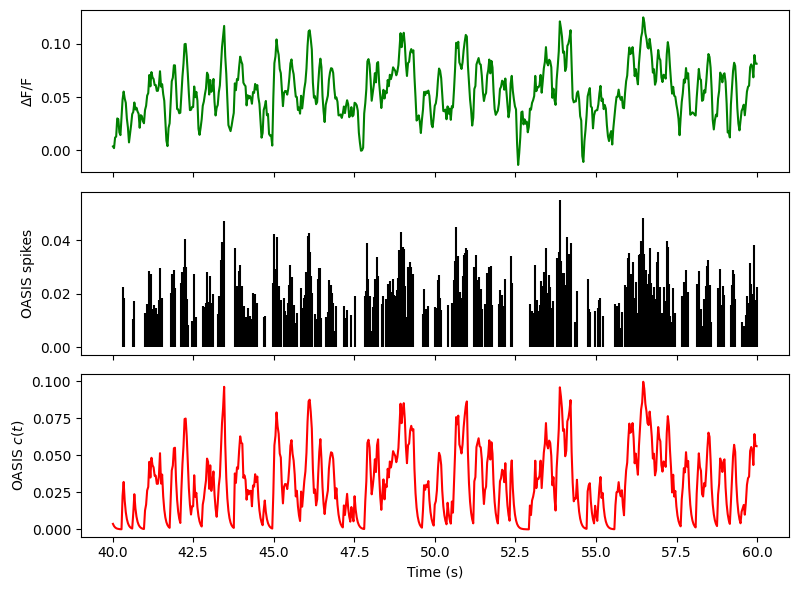

In [59]:
import matplotlib.pyplot as plt

d = preprocessed_oasis_data
cell = int(data["good_cells"][0])

# pick absolute window from 40 s to 60 s (within 33.78–3517 s)
t0, t1 = 40.0, 60.0

t = d["t_sparse"]
y = d["dff_smooth"][cell, :]
s = d["oas_s_opt"][cell, :]
c = d["oas_c_opt"][cell, :]

mask = (t >= t0) & (t <= t1)
t_win = t[mask]
y_win = y[mask]
s_win = s[mask]
c_win = c[mask]

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax0.plot(t_win, y_win, color="green")
ax0.set_ylabel("ΔF/F")
ax1.vlines(t_win[s_win > 0], 0, s_win[s_win > 0], color="black")
ax1.set_ylabel("OASIS spikes")
ax2.plot(t_win, c_win, color="red")
ax2.set_ylabel("OASIS $c(t)$")
ax2.set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

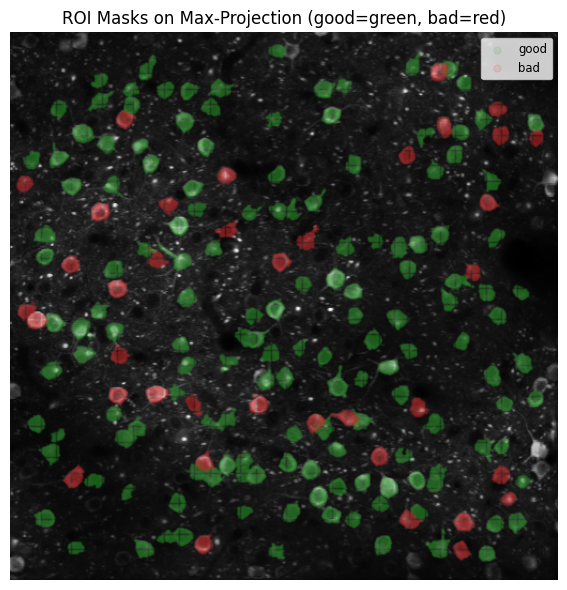

In [60]:
# QC — ROI Masks overlaid on Max‑Projection
max_proj = data["max_projection"]
masks = data["roi_masks"]
good = set(data["good_cells"])
bad = set(data["bad_cells"])

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(max_proj, cmap="gray")
# plot good cells in green, bad in red
for cell_set, color in [(good, "C2"), (bad, "C3")]:
    ys, xs = np.nonzero(np.sum(masks[list(cell_set)], axis=0))
    ax.scatter(
        xs, ys, s=1, alpha=0.1, color=color, label=("good" if color == "C2" else "bad")
    )
ax.set_title("ROI Masks on Max‑Projection (good=green, bad=red)")
ax.axis("off")
ax.legend(markerscale=5, fontsize="small")
plt.tight_layout()
plt.show()

## Tuning Function Fitting using ML - LNP

In [61]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import utils as U
# import importlib
# import os
# import glob

# importlib.reload(U)

# use_cached_data = True

# if use_cached_data:
#     try:
#         namespace = "aakarsh"
#         background_dir = f'data/{namespace}/background/'
#         list_of_background_files = glob.glob(os.path.join(background_dir, '*.npz'))
#         if not list_of_background_files:
#             raise FileNotFoundError(f"No background data files found in '{background_dir}'")

#         latest_background_file = max(list_of_background_files, key=os.path.getctime)
#         print(f"Loading latest background data from: {latest_background_file}")

#         stim_data = np.load(latest_background_file, allow_pickle=True)
#         stim_filtered = stim_data['stim_filtered']
#         stim_table_filtered_df = pd.DataFrame(stim_data['stim_table_filtered'], columns=stim_data['stim_table_columns'])

#         spike_inference_dir = f'data/{namespace}/preprocessed/'
#         list_of_spike_files = glob.glob(os.path.join(spike_inference_dir, '*.npz'))
#         if not list_of_spike_files:
#             raise FileNotFoundError(f"No spike inference files found in '{spike_inference_dir}'")

#         latest_spike_file = max(list_of_spike_files, key=os.path.getctime)
#         print(f"Loading latest spike inference data from: {latest_spike_file}")

#         spike_data = np.load(latest_spike_file, allow_pickle=True)
#         print(spike_data.keys())

#         inferred_spikes = spike_data['spike_counts']
#         time_vector = spike_data['time_vector']
#         sampling_rate = spike_data['sampling_frequency']

#         data  = U.load_data()# Load the latest spike inference data
#         data  = U.preprocess_data(data)  # Preprocess the data

#     except FileNotFoundError as e:
#         print(f"ERROR: Could not find a necessary input file: {e}")
#         print("Please ensure you have run the previous notebooks (00 and 02) and saved their outputs correctly.")
#         raise

In [62]:
# importlib.reload(
#     U
# )

# inferred_spikes = spike_data["spike_counts"]
# binned_spikes, presented_frame_ids = (
#     np.array(inferred_spikes, dtype=np.float64),
#     active_stim_per_timestep,
# )  # stimulus data is already binned.

# #
# assert (
#     np.sum(presented_frame_ids[presented_frame_ids == -1]) == 0
# ), "There are still -1 values in presented_frame_ids. Please check the filtering step."

In [63]:
#  Filter presented frame_ids and binned spikes by removing indexes where presented_Frame_ids is -1
binned_spikes = d["oas_s_opt"]
presented_frame_ids = data["stim_id_clean"]
print(
    f"binned_spikes.shape: {binned_spikes.shape}, presented_frame_ids.shape: {presented_frame_ids.shape}"
)

binned_spikes.shape: (189, 66981), presented_frame_ids.shape: (66981,)


In [64]:
# Convert the stimulus to binary matrices for 'ON' and 'OFF' stimuli, these are easier to train and give better receptive field estimates.
import an_utils as U

flattened_stim, stim_h, stim_w = U.prepare_stimulus_matrix_from_ids(
    presented_frame_ids, full_stim_movie=data["stim"]
)
print(
    f"Flattened stimulus shape: {flattened_stim.shape}, Stimulus height: {stim_h}, Stimulus width: {stim_w}"
)

# Create a copy of the original flattened stimulus matrix
flattened_on_stimuli = flattened_stim.copy()
flattened_off_stimuli = flattened_stim.copy()

# For the 'ON' matrix, set all 'OFF' pixels (<= 127) to zero
flattened_on_stimuli[flattened_on_stimuli <= 127] = 0
flattened_on_stimuli[flattened_on_stimuli > 127] = 1

# For the 'OFF' matrix, set all 'ON' pixels (> 127) to zero
flattened_off_stimuli[flattened_off_stimuli < 127] = 1
flattened_off_stimuli[flattened_off_stimuli >= 127] = 0

# --- Verification ---
print(f"Flattened Stimulus Shape: {flattened_stim.shape}")
print(f"Flattened On Stimuli Shape: {flattened_on_stimuli.shape}")
print(f"Flattened Off Stimuli Shape: {flattened_off_stimuli.shape}")

# These assertions will now pass because the shape is preserved
assert (
    flattened_on_stimuli.shape == flattened_stim.shape
), "The shape of flattened_on_stimuli does not match the shape of flattened_stim."
assert (
    flattened_off_stimuli.shape == flattened_stim.shape
), "The shape of flattened_off_stimuli does not match the shape of flattened_stim."

print("\nAssertions passed! The shapes are now correct.")

Preparing stimulus matrix from frame IDs...
Stimulus matrix preparation complete. Shape: (448, 66981)
Flattened stimulus shape: (448, 66981), Stimulus height: 16, Stimulus width: 28
Flattened Stimulus Shape: (448, 66981)
Flattened On Stimuli Shape: (448, 66981)
Flattened Off Stimuli Shape: (448, 66981)

Assertions passed! The shapes are now correct.


/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


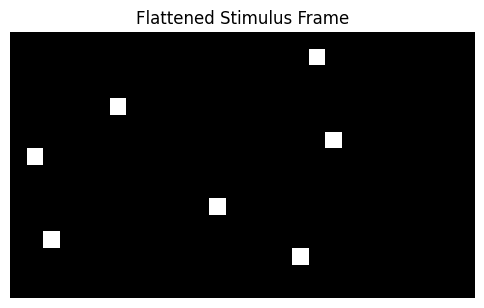

In [65]:
# Plot a single flattened stimulus frame
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(flattened_on_stimuli[:, 0].reshape(stim_h, stim_w), cmap="gray")
plt.title("Flattened Stimulus Frame")
plt.axis("off")
plt.show()

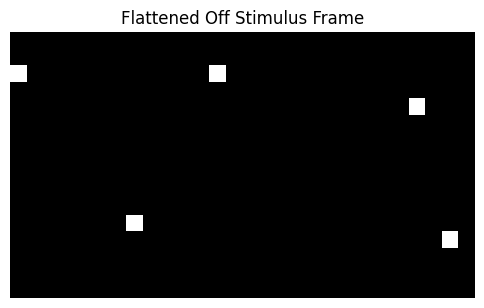

In [66]:
# Plot a single flattened stimulus frame
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(flattened_off_stimuli[:, 0].reshape(stim_h, stim_w), cmap="gray")
plt.title("Flattened Off Stimulus Frame")
plt.axis("off")
plt.show()

In [67]:
"""
import importlib
import an_utils as U

importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions
lags_to_test = np.array(list(range(10)))
selected_neurons = np.arange(binned_spikes.shape[0])  # Select all neurons for now
# selected_neurons = [0, 1, 2]
all_rfs_spatiotemporal_on = U.fit_all_neurons_rfs_parallel(
    binned_spikes, flattened_on_stimuli, lags_to_test, selected_neurons=selected_neurons
)
"""

"\nimport importlib\nimport an_utils as U\n\nimportlib.reload(\n    U\n)  # Reload utils to ensure you're using the latest version of your functions\nlags_to_test = np.array(list(range(10)))\nselected_neurons = np.arange(binned_spikes.shape[0])  # Select all neurons for now\n# selected_neurons = [0, 1, 2]\nall_rfs_spatiotemporal_on = U.fit_all_neurons_rfs_parallel(\n    binned_spikes, flattened_on_stimuli, lags_to_test, selected_neurons=selected_neurons\n)\n"

In [68]:
# ------ END LNP MODEL FITTING ------------------#
# all_rfs_spatiotemporal_on_np = np.array(all_rfs_spatiotemporal_on, dtype=np.float64)

In [69]:
# all_rfs_spatiotemporal_on_np.shape

In [70]:
"""
num_lags = len(lags_to_test)
num_neurons = data["dff"].shape[0]
# 2. Create a single figure with a grid of subplots
# The grid will have 'num_neurons' rows and 'num_lags' columns.
fig, axes = plt.subplots(
    num_neurons,
    num_lags,
    figsize=(num_lags * 2, num_neurons * 2.2),
    squeeze=False,  # Always return a 2D array for axes
)

fig.suptitle("Spatio-Temporal Receptive Fields (All Neurons) - Simple LNP", fontsize=16)

# 3. Loop through each neuron and its corresponding row of axes
for neuron_idx, w_flat in enumerate(all_rfs_spatiotemporal_on_np):
    neuron_id = selected_neurons[neuron_idx]

    # Reshape the flattened weights to (time, height, width)
    strf = w_flat.reshape(num_lags, stim_h, stim_w)
    # Normalize color scale per-neuron for fair comparison across its own lags
    vmin, vmax = strf.min(), strf.max()

    # Set the y-label for the row to identify the neuron
    axes[neuron_idx, 0].set_ylabel(
        f"Neuron {neuron_id}",
        rotation=0,
        size="large",
        labelpad=40,  # Move label to the left
        ha="right",
        va="center",
    )

    # Loop through each time lag and its column
    for lag_idx in range(num_lags):
        ax = axes[neuron_idx, lag_idx]

        # Plot the spatial receptive field at this lag
        ax.imshow(strf[lag_idx], cmap="bwr", vmin=vmin, vmax=vmax)
        ax.axis("off")  # Hide axis ticks and borders

        # --- CHANGE ---
        # Set a title for every subplot to show its corresponding lag.
        # The 'if' condition that restricted this to the first row is removed.
        ax.set_title(f"Neuron {neuron_id} Lag {lag_idx} ")

# 4. Adjust layout and display the single plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make space for suptitle
plt.show()
"""

'\nnum_lags = len(lags_to_test)\nnum_neurons = data["dff"].shape[0]\n# 2. Create a single figure with a grid of subplots\n# The grid will have \'num_neurons\' rows and \'num_lags\' columns.\nfig, axes = plt.subplots(\n    num_neurons,\n    num_lags,\n    figsize=(num_lags * 2, num_neurons * 2.2),\n    squeeze=False,  # Always return a 2D array for axes\n)\n\nfig.suptitle("Spatio-Temporal Receptive Fields (All Neurons) - Simple LNP", fontsize=16)\n\n# 3. Loop through each neuron and its corresponding row of axes\nfor neuron_idx, w_flat in enumerate(all_rfs_spatiotemporal_on_np):\n    neuron_id = selected_neurons[neuron_idx]\n\n    # Reshape the flattened weights to (time, height, width)\n    strf = w_flat.reshape(num_lags, stim_h, stim_w)\n    # Normalize color scale per-neuron for fair comparison across its own lags\n    vmin, vmax = strf.min(), strf.max()\n\n    # Set the y-label for the row to identify the neuron\n    axes[neuron_idx, 0].set_ylabel(\n        f"Neuron {neuron_id}",\n 

In [71]:
# all_rfs_spatiotemporal_on_np.shape

# Tuning Function with STA

# Tuning Function with Spline Basis in RFEST

In [72]:
# use_cached_data = True


# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import an_utils as U
# import importlib
# import os
# import glob

# # Reload utils to ensure you're using the latest version of your functions
# importlib.reload(U)

# if use_cached_data:
#     try:
#         # ACTION: Change 'aakarsh' to your namespace if needed.
#         namespace = "aakarsh"

#         # --- Load the latest output from the preprocessing notebook (00-background.ipynb) ---
#         background_dir = f"data/{namespace}/background/"
#         list_of_background_files = glob.glob(os.path.join(background_dir, "*.npz"))
#         if not list_of_background_files:
#             raise FileNotFoundError(
#                 f"No background data files found in '{background_dir}'"
#             )

#         latest_background_file = max(list_of_background_files, key=os.path.getctime)
#         print(f"Loading latest background data from: {latest_background_file}")

#         stim_data = np.load(latest_background_file, allow_pickle=True)
#         stim_filtered = stim_data["stim_filtered"]
#         stim_table_filtered_df = pd.DataFrame(
#             stim_data["stim_table_filtered"], columns=stim_data["stim_table_columns"]
#         )

#         # --- Load the latest output from the spike inference notebook (02-spike-inference.ipynb) ---
#         spike_inference_dir = f"data/{namespace}/preprocessed/"
#         list_of_spike_files = glob.glob(os.path.join(spike_inference_dir, "*.npz"))
#         if not list_of_spike_files:
#             raise FileNotFoundError(
#                 f"No spike inference files found in '{spike_inference_dir}'"
#             )

#         latest_spike_file = max(list_of_spike_files, key=os.path.getctime)
#         print(f"Loading latest spike inference data from: {latest_spike_file}")

#         spike_data = np.load(latest_spike_file, allow_pickle=True)
#         print(spike_data.keys())

#         inferred_spikes = spike_data["spike_counts"]
#         time_vector = spike_data["time_vector"]
#         sampling_rate = spike_data["sampling_frequency"]

#         data = U.load_data()  # Load the latest spike inference data
#         data = U.preprocess_data(data)  # Preprocess the data

#     except FileNotFoundError as e:
#         print(f"ERROR: Could not find a necessary input file: {e}")
#         print(
#             "Please ensure you have run the previous notebooks (00 and 02) and saved their outputs correctly."
#         )
#         raise

In [73]:
# active_stim_per_timestep = U.get_active_stimulus_per_timestep(
#     data["stim_table"], total_timesteps=len(data["t"])
# )

In [74]:
# importlib.reload(
#     U
# )  # Reload utils to ensure you're using the latest version of your functions

# # Prepare the stimulus matrix from the presented frame IDs
# # Reload utils to ensure you're using the latest version of your functions

# inferred_spikes = spike_data["spike_counts"]
# binned_spikes, presented_frame_ids = (
#     np.array(inferred_spikes, dtype=np.float64),
#     active_stim_per_timestep,
# )  # stimulus data is already binned.

# # Filter presented frame_ids and binned spikes by removing indexes where presented_Frame_ids is -1
# binned_spikes = binned_spikes[:, presented_frame_ids != -1]
# presented_frame_ids = presented_frame_ids[presented_frame_ids != -1]
# print(
#     f"binned_spikes.shape: {binned_spikes.shape}, presented_frame_ids.shape: {presented_frame_ids.shape}"
# )
# assert (
#     np.sum(presented_frame_ids[presented_frame_ids == -1]) == 0
# ), "There are still -1 values in presented_frame_ids. Please check the filtering step."

In [75]:
### OVERWOTE THE binned_spikes wand frame ids here.
# load npz file with the binned spikes and frame ids
binned_spikes = d["oas_s_opt"]
presented_frame_ids = data["stim_id_clean"]
# binned_spikes = np.load('data/preprocessed/ae_data_snapshot.npz', allow_pickle=True)['spike_counts']
# presented_frame_ids = np.load('data/preprocessed/ae

In [76]:
print(binned_spikes.shape)
print(presented_frame_ids.shape)

(189, 66981)
(66981,)


# 3 Tuning

We split the stimuli into ON/OFF (white/black)

In [77]:
# Convert the stimulus to binary matrices for 'ON' and 'OFF' stimuli, these are easier to train and give better receptive field estimates.
import an_utils as U
import importlib

importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions

flattened_stim, stim_h, stim_w = U.prepare_stimulus_matrix_from_ids(
    presented_frame_ids, full_stim_movie=data["stim"]
)
print(
    f"Flattened stimulus shape: {flattened_stim.shape}, Stimulus height: {stim_h}, Stimulus width: {stim_w}"
)

# Create a copy of the original flattened stimulus matrix
flattened_on_stimuli = flattened_stim.copy()
flattened_off_stimuli = flattened_stim.copy()

# For the 'ON' matrix, set all 'OFF' pixels (<= 127) to zero
flattened_on_stimuli[flattened_on_stimuli <= 127] = 0
flattened_on_stimuli[flattened_on_stimuli > 127] = 1

# For the 'OFF' matrix, set all 'ON' pixels (> 127) to zero
flattened_off_stimuli[flattened_off_stimuli < 127] = 1
flattened_off_stimuli[flattened_off_stimuli >= 127] = 0

# --- Verification ---
print(f"Flattened Stimulus Shape: {flattened_stim.shape}")
print(f"Flattened On Stimuli Shape: {flattened_on_stimuli.shape}")
print(f"Flattened Off Stimuli Shape: {flattened_off_stimuli.shape}")

# These assertions will now pass because the shape is preserved
assert (
    flattened_on_stimuli.shape == flattened_stim.shape
), "The shape of flattened_on_stimuli does not match the shape of flattened_stim."
assert (
    flattened_off_stimuli.shape == flattened_stim.shape
), "The shape of flattened_off_stimuli does not match the shape of flattened_stim."

print("\nAssertions passed! The shapes are now correct.")

Preparing stimulus matrix from frame IDs...
Stimulus matrix preparation complete. Shape: (448, 66981)
Flattened stimulus shape: (448, 66981), Stimulus height: 16, Stimulus width: 28
Flattened Stimulus Shape: (448, 66981)
Flattened On Stimuli Shape: (448, 66981)
Flattened Off Stimuli Shape: (448, 66981)

Assertions passed! The shapes are now correct.


In [78]:
from scipy.special import gammaln


def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------

    w = w.ravel()  # ensure shape (D,)
    lin = w @ s  # shape (nT,)
    rates = np.exp(lin) * dt * R  # shape (nT,)

    # term1: ∑ c_t · (w^T s_t)
    term1 = np.dot(c, lin)

    # term2: ∑ exp(w^T s_t) · (Δt·R)
    term2 = rates.sum()

    # term3: ∑ log(c_t!) = ∑ gam    # --- Lmaln(c_t + 1)
    c = np.asarray(c, dtype=np.float64)

    term3 = gammaln(c + 1).sum()

    # term4: ∑ c_t · log(Δt·R)
    log_dtR = np.log(dt * R)
    term4 = (c * log_dtR).sum()

    # full log-likelihood
    logL = term1 - term2 - term3 + term4

    # return *negative* log-likelihood
    return -logL


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """
    Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w
    """
    w = w.ravel()  # ensure shape (D*D,)
    lin = w @ s  # shape (nT,)
    rates = np.exp(lin) * dt * R

    # gradient = ∑_t (r_t - c_t) s_t
    grad = s @ (rates - c)  # shape (D*D,)
    return grad


def negloglike_lnp_l1(
    w: np.array,
    c: np.array,
    s: np.array,
    dt: float = 0.1,
    R: float = 50,
    lambda_l1: float = 1e-3,
) -> float:
    negloglike = negloglike_lnp(w, c, s, dt, R)
    l1_penalty = lambda_l1 * np.sum(np.abs(w))
    return negloglike + l1_penalty


def deriv_negloglike_lnp_l1(
    w: np.array,
    c: np.array,
    s: np.array,
    dt: float = 0.1,
    R: float = 50,
    lambda_l1: float = 1e-3,
) -> np.array:
    grad = deriv_negloglike_lnp(w, c, s, dt, R)
    # Gradient of L1 norm is sign(w), subgradient at 0 can be taken as 0 or ±1; here we use sign(w)
    grad += lambda_l1 * np.sign(w)
    return grad


import numpy as np
from scipy.optimize import minimize


def build_lagged_stimulus_matrix(flattened_stim, n_lags):
    """
    flattened_stim: shape (num_pixels, num_timepoints)
    n_lags: number of time lags to include

    Returns:
      lagged_stim: shape (num_pixels * n_lags, num_timepoints - n_lags + 1)
    """
    num_pixels, num_timepoints = flattened_stim.shape
    lagged_stim = []

    for lag in range(n_lags):
        lagged_stim.append(flattened_stim[:, lag : num_timepoints - (n_lags - lag - 1)])

    return np.vstack(lagged_stim)


# Parameters for lag and LNP model
n_lags = 5  # number of temporal lags to include, tune as you want
dt = 0.3  # time bin size, adjust if needed
R = 1  # max firing rate, adjust if needed

# Assume you already have these from previous steps
# binned_spikes: shape (num_neurons, num_timepoints)
# flattened_on_stimuli: shape (num_pixels, num_timepoints)

num_neurons = binned_spikes.shape[0]
num_pixels = flattened_on_stimuli.shape[0]

# Build lagged stimulus matrix
lagged_stimuli = build_lagged_stimulus_matrix(flattened_on_stimuli, n_lags)

# New number of time points after lagging
num_timepoints_lagged = lagged_stimuli.shape[1]

selected_neuron_ids = list(range(binned_spikes.shape[0]))

selected_neuron_ids = [20, 32, 43, 60]
# <-- your selected neuron IDs bro

# Only allocate receptive_fields for selected neurons
receptive_fields = np.zeros((len(selected_neuron_ids), num_pixels * n_lags))

for i, neuron_idx in enumerate(selected_neuron_ids):
    print(f"Fitting RF for neuron {neuron_idx} ({i + 1}/{len(selected_neuron_ids)})...")

    # Trim spike counts to match lagged stimulus time dimension
    c = binned_spikes[neuron_idx, n_lags - 1 : n_lags - 1 + num_timepoints_lagged]

    # Initialize weights (receptive field) vector for this neuron
    w0 = np.zeros(num_pixels * n_lags)

    from tqdm import tqdm

    max_iters = 500
    pbar = tqdm(total=max_iters, desc="Optimizing LNP")

    def callbackF(xk):
        pbar.update(1)

    result = minimize(
        fun=negloglike_lnp,
        x0=w0,
        args=(c, lagged_stimuli, dt, R),
        jac=deriv_negloglike_lnp,
        method="L-BFGS-B",
        callback=callbackF,
        options={"maxiter": max_iters, "disp": True},
    )

    pbar.close()

    if result.success:
        receptive_fields[i, :] = result.x
    else:
        print(f"Optimization failed for neuron {neuron_idx}: {result.message}")

Fitting RF for neuron 20 (1/4)...


Optimizing LNP:  14%|█▎        | 68/500 [00:27<02:51,  2.52it/s]


Fitting RF for neuron 32 (2/4)...


Optimizing LNP:  13%|█▎        | 64/500 [00:24<02:50,  2.56it/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np
import os

# Create the directory if it doesn't exist
os.makedirs("final_data", exist_ok=True)

# Save the array into the directory
np.save("final_data/receptive_fields.npy", receptive_fields)

In [ ]:
# Build lagged OFF stimulus matrix
lagged_off_stimuli = build_lagged_stimulus_matrix(flattened_off_stimuli, n_lags)

# Initialize RF storage for OFF
receptive_fields_off = np.zeros((len(selected_neuron_ids), num_pixels * n_lags))

for i, neuron_idx in enumerate(selected_neuron_ids):
    print(
        f"Fitting OFF RF for neuron {neuron_idx} ({i + 1}/{len(selected_neuron_ids)})..."
    )

    c = binned_spikes[neuron_idx, n_lags - 1 : n_lags - 1 + lagged_off_stimuli.shape[1]]
    w0 = np.zeros(num_pixels * n_lags)

    from tqdm import tqdm

    max_iters = 500
    pbar = tqdm(total=max_iters, desc="Optimizing LNP (OFF)")

    def callbackF(xk):
        pbar.update(1)

    result = minimize(
        fun=negloglike_lnp,
        x0=w0,
        args=(c, lagged_off_stimuli, dt, R),
        jac=deriv_negloglike_lnp,
        method="L-BFGS-B",
        callback=callbackF,
        options={"maxiter": max_iters, "disp": True},
    )

    pbar.close()

    if result.success:
        receptive_fields_off[i, :] = result.x
    else:
        print(f"Optimization failed for neuron {neuron_idx}: {result.message}")

Fitting OFF RF for neuron 20 (1/4)...






















































































Optimizing LNP (OFF):  17%|█▋        | 84/500 [00:35<02:53,  2.39it/s]


Fitting OFF RF for neuron 32 (2/4)...













































































Optimizing LNP (OFF):  15%|█▍        | 74/500 [00:30<02:55,  2.43it/s]


Fitting OFF RF for neuron 43 (3/4)...













































































Optimizing LNP (OFF):  15%|█▍        | 74/500 [00:30<02:58,  2.39it/s]


Fitting OFF RF for neuron 60 (4/4)...






























































































Optimizing LNP (OFF):  18%|█▊        | 91/500 [00:37<02:50,  2.39it/s]


In [79]:
import numpy as np
import os

# Create the directory if it doesn't exist
os.makedirs("final_data", exist_ok=True)

# Save the array into the directory
np.save("final_data/receptive_fields_off.npy", receptive_fields_off)

NameError: name 'receptive_fields_off' is not defined

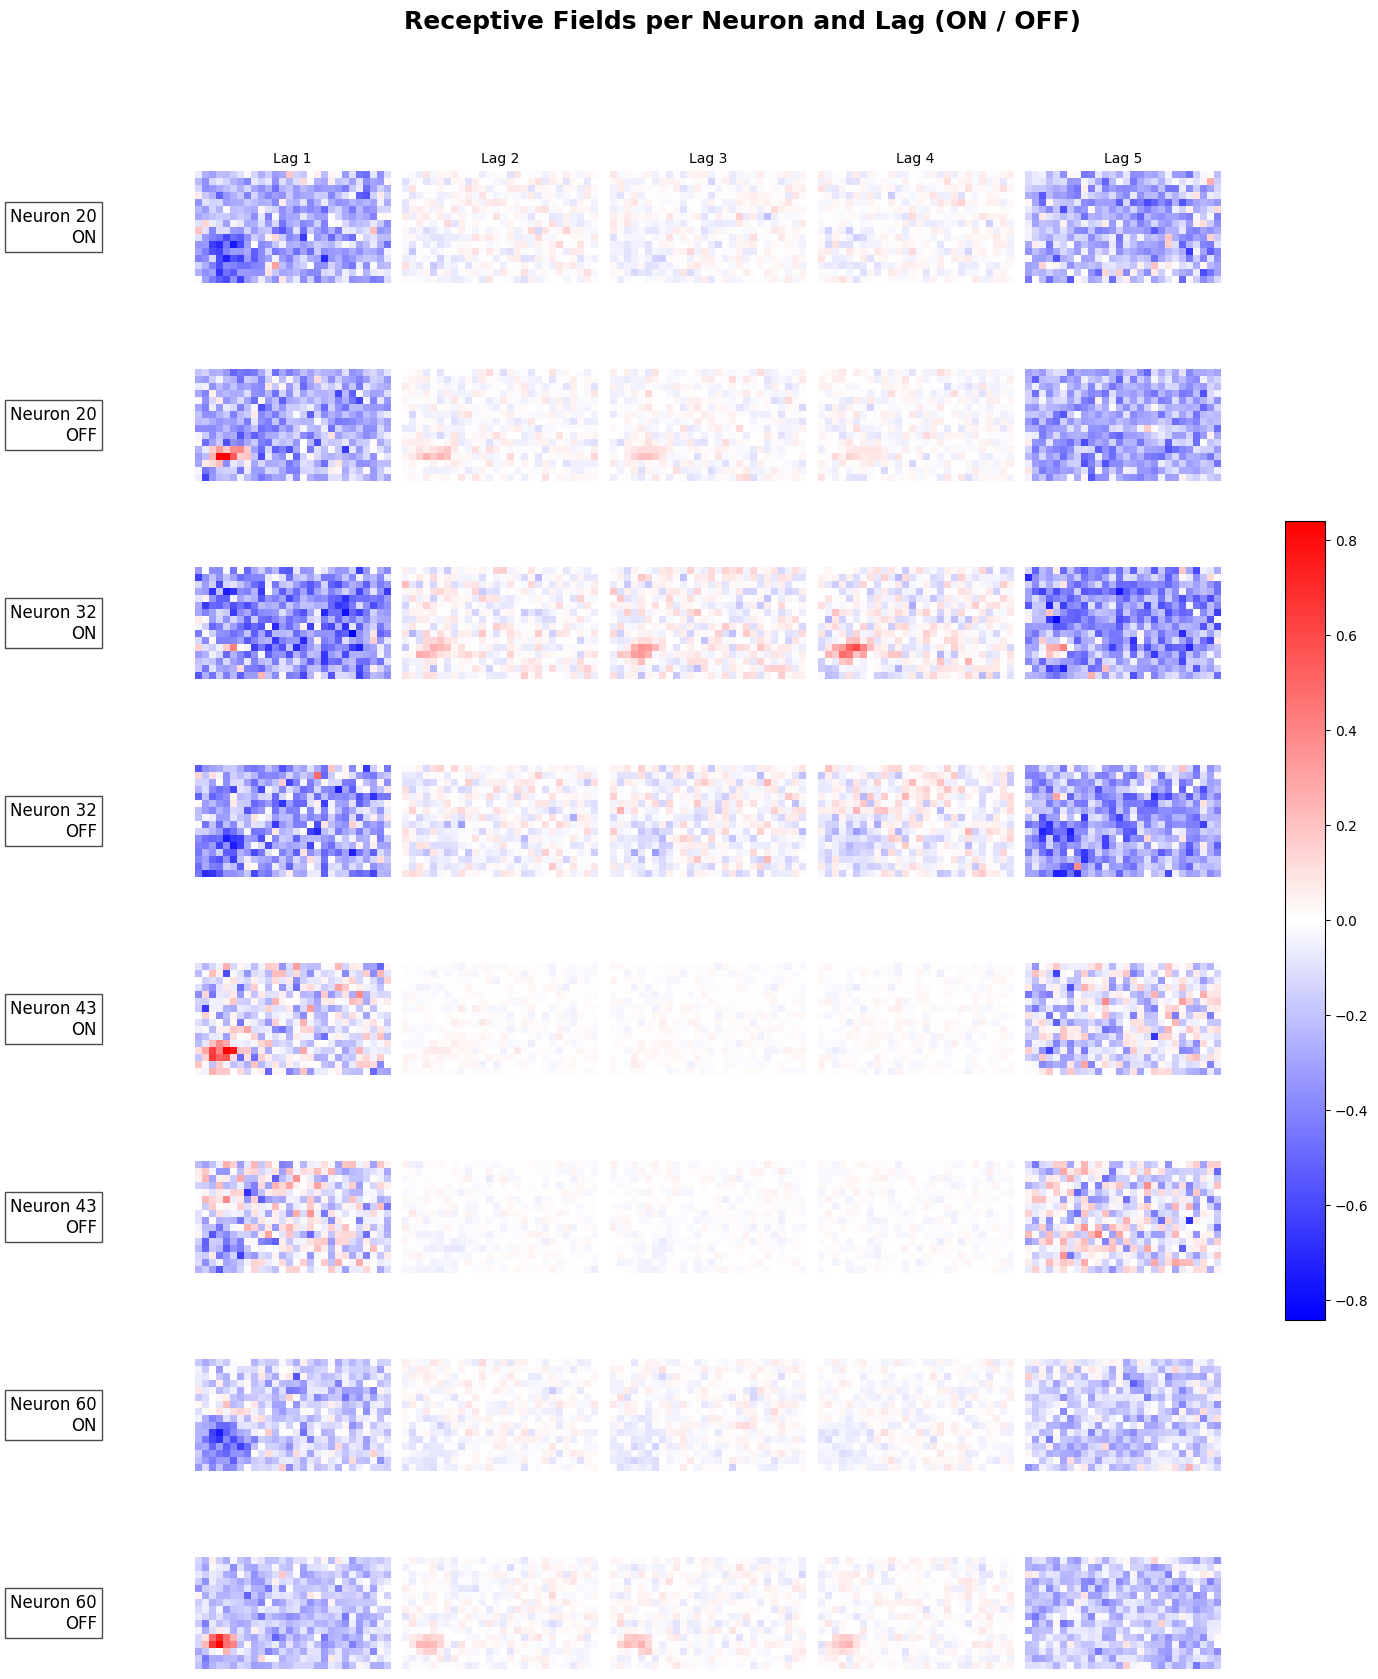

In [80]:
import matplotlib.pyplot as plt
import numpy as np

receptive_fields = np.load("final_data/receptive_fields.npy")
receptive_fields_off = np.load("final_data/receptive_fields_off.npy")

num_neurons_to_plot = len(selected_neuron_ids)
total_rows = num_neurons_to_plot * 2  # ON and OFF rows

fig, axes = plt.subplots(total_rows, n_lags, figsize=(3 * n_lags, 2.2 * total_rows))

# Handle single neuron or lag cases
if total_rows == 1:
    axes = np.expand_dims(axes, 0)
if n_lags == 1:
    axes = np.expand_dims(axes, 1)

for i, neuron_id in enumerate(selected_neuron_ids):
    rf_on = receptive_fields[i].reshape(n_lags, stim_h, stim_w)
    rf_off = receptive_fields_off[i].reshape(n_lags, stim_h, stim_w)

    vlim = max(np.max(np.abs(rf_on)), np.max(np.abs(rf_off)))  # consistent scale

    for lag in range(n_lags):
        ax_on = axes[i * 2, lag]
        im = ax_on.imshow(rf_on[lag], cmap="bwr", vmin=-vlim, vmax=vlim)
        ax_on.axis("off")
        if i == 0:
            ax_on.set_title(f"Lag {lag+1}", fontsize=10)

        ax_off = axes[i * 2 + 1, lag]
        ax_off.imshow(rf_off[lag], cmap="bwr", vmin=-vlim, vmax=vlim)
        ax_off.axis("off")

    # Add labels directly in first lag subplot of each row
    axes[i * 2, 0].text(
        -0.5,
        0.5,
        f"Neuron {neuron_id}\nON",
        fontsize=12,
        ha="right",
        va="center",
        transform=axes[i * 2, 0].transAxes,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"),
    )

    axes[i * 2 + 1, 0].text(
        -0.5,
        0.5,
        f"Neuron {neuron_id}\nOFF",
        fontsize=12,
        ha="right",
        va="center",
        transform=axes[i * 2 + 1, 0].transAxes,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"),
    )

fig.suptitle(
    "Receptive Fields per Neuron and Lag (ON / OFF)", fontsize=18, weight="bold"
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()

In [85]:
from rfest import splineLNP, build_design_matrix
from tqdm import tqdm


w_est_spline_coeffs = []
selected_neurons = range(binned_spikes.shape[0])
# selected_neurons = [20, 32, 43, 60]
# Select all neurons for fitting
for neuron_idx in tqdm(selected_neurons, desc="Fitting splineLNP models"):
    neuron_to_fit = neuron_idx
    print(f"binned_spikes.shape: {binned_spikes.shape}")
    neuron_binned_spikes = binned_spikes[neuron_to_fit, :]
    flattened_stim_for_rfest = flattened_on_stimuli.copy()
    print(f"flattened_stim_for_rfest.shape: {flattened_stim_for_rfest.shape}")
    num_lags = 10  # Number of lags to consider for the GLM
    dims = (num_lags, stim_h, stim_w)
    print(f"dims: {dims}")
    df = (8, 8, 12)  # (time, height, width)

    X_design = build_design_matrix(flattened_stim_for_rfest.T, nlag=num_lags)
    # Remove the first num_lags-1 entries from the binned spikes to match the response length
    y_response = np.array(neuron_binned_spikes)
    y_response = y_response.astype(np.float64)

    print(f"X_design.shape: {X_design.shape}")

    print(f"X_design.shape: {X_design.shape}")
    print(f"y_response.shape: {y_response.shape}")
    model = splineLNP(X_design, y_response, dims=dims, df=df)
    print(
        f"Model initialized for Neuron {neuron_to_fit} with dims: {dims} and df: {df}"
    )
    # Fit the model. This performs the optimization.
    print(f"Fitting splineLNP model for Neuron {neuron_to_fit}...")
    model.fit(beta=0.01, num_iters=200, verbose=10)

    # The estimated receptive field is stored in model.w_opt
    w_est_spline = model.w_opt
    w_est_spline_coeffs.append(w_est_spline)
    print(f"\n Neuron {neuron_to_fit} Fitting complete!")
w_est_spline_coeffs_on = np.array(w_est_spline_coeffs, dtype=np.float64)

binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 0 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 0...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.244        45661.604       
10           4.716        35717.253       
20           5.188        27882.290       
30           5.658        21923.943       
40           6.123        17479.708       
50           6.594        14178.539       
60           7.060        11709.651       
70           7.531        9839.909        
80           8.005        8404.972        
90           8.474        7293.731        
100          8.941        6435.008        
110          9.418        5789.051        
120          9.898        5342.960        
130          10.372       5102.088        
140          10.848     

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 0 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 1 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 1...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.275        45694.302       
10           4.769        35771.693       
20           5.257        27960.004       
30           5.732        22026.037       
40           6.228        17606.654       
50           6.703        14330.313       
60           7.176        11886.034       
70           7.658        10040.788       
80           8.138        8630.568        
90           8.616        7544.725        
100          9.096        6712.488        
110          9.573        60

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 1 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 2 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 2...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.112        45791.266       
10           4.583        35932.406       
20           5.051        28188.940       
30           5.515        22326.425       
40           5.983        17979.839       
50           6.450        14776.142       
60           6.914        12403.724       
70           7.382        10629.762       
80           7.851        9291.026        
90           8.320        8277.853        
100          8.793        7520.017        
110          9.260        69

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 2 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 3 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 3...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.138        45814.573       
10           4.598        35971.268       
20           5.057        28244.451       
30           5.522        22399.355       
40           5.985        18070.477       
50           6.452        14884.388       
60           6.912        12529.299       
70           7.378        10772.406       
80           7.839        9450.619        
90           8.314        8454.437        
100          8.775        7713.640        
110          9.236        71

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 3 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 4 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 4...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.148        45772.689       
10           4.607        35901.794       
20           5.059        28145.451       
30           5.512        22269.449       
40           5.967        17909.120       
50           6.428        14691.708       
60           6.892        12305.727       
70           7.352        10518.326       
80           7.809        9166.150        
90           8.259        8139.388        
100          8.718        7367.785        
110          9.173        68

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 4 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 5 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 5...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.147        45820.959       
10           4.612        35981.514       
20           5.077        28258.828       
30           5.545        22418.070       
40           6.002        18093.631       
50           6.467        14911.998       
60           6.929        12561.350       
70           7.388        10808.888       
80           7.847        9491.564        
90           8.306        8499.910        
100          8.766        7763.695        
110          9.231        72

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 5 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 6 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 6...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.128        45964.093       
10           4.593        36217.592       
20           5.058        28594.324       
30           5.525        22857.571       
40           5.995        18638.852       
50           6.464        15562.298       
60           6.926        13314.915       
70           7.394        11663.817       
80           7.856        10446.443       
90           8.318        9553.665        
100          8.780        8914.325        
110          9.247        84

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 6 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 7 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 7...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.143        45742.089       
10           4.614        35851.669       
20           5.083        28074.430       
30           5.549        22176.524       
40           6.019        17793.839       
50           6.487        14554.061       
60           6.961        12145.888       
70           7.428        10336.401       
80           7.896        8962.012        
90           8.363        7912.629        
100          8.836        7117.878        
110          9.301        65

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 7 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 8 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 8...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.111        45741.707       
10           4.571        35850.390       
20           5.032        28072.194       
30           5.499        22173.311       
40           5.966        17789.682       
50           6.434        14549.034       
60           6.900        12140.093       
70           7.356        10329.950       
80           7.820        8955.015        
90           8.285        7905.192        
100          8.750        7110.092        
110          9.215        65

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 8 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 9 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 9...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.127        45728.056       
10           4.586        35827.850       
20           5.044        28040.139       
30           5.501        22131.288       
40           5.961        17737.494       
50           6.418        14486.692       
60           6.877        12067.690       
70           7.335        10247.549       
80           7.794        8862.564        
90           8.255        7802.495        
100          8.716        6996.869        
110          9.175        64

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 9 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 10 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 10...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.144        47618.022       
10           4.613        38962.414       
20           5.082        32502.761       
30           5.550        27969.961       
40           6.018        24946.592       
50           6.481        23011.921       
60           6.951        21821.250       
70           7.423        21121.250       
80           7.898        20734.529       
90           8.363        20538.718       
100          8.833        20450.608       
110          9.304        

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 10 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 11 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 11...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.172        45834.353       
10           4.642        36004.021       
20           5.112        28291.083       
30           5.579        22460.514       
40           6.058        18146.415       
50           6.528        14975.039       
60           7.001        12634.450       
70           7.479        10891.852       
80           7.955        9584.267        
90           8.429        8602.303        
100          8.902        7875.710        
110          9.372       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 11 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 12 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 12...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.151        45807.160       
10           4.637        35958.983       
20           5.115        28226.951       
30           5.590        22376.398       
40           6.064        18041.969       
50           6.535        14850.354       
60           7.008        12489.822       
70           7.483        10727.560       
80           7.955        9400.439        
90           8.426        8398.907        
100          8.900        7652.751        
110          9.378       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 12 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 13 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 13...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.127        45562.371       
10           4.595        35552.588       
20           5.063        27647.573       
30           5.534        21615.774       
40           6.001        17096.521       
50           6.468        13720.178       
60           6.936        11176.441       
70           7.401        9231.709        
80           7.864        7720.396        
90           8.325        6529.567        
100          8.787        5585.990        
110          9.251       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 189 of 199 (Max: 200).


 Neuron 13 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 14 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 14...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.136        45812.458       
10           4.598        35967.847       
20           5.059        28239.625       
30           5.520        22393.051       
40           5.982        18062.655       
50           6.444        14875.037       
60           6.905        12518.418       
70           7.362        10759.989       
80           7.826        9436.650        
90           8.290        8438.885        
100          8.761        7696.478        
110          9.226       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 14 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 15 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 15...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.126        45737.184       
10           4.591        35842.499       
20           5.050        28060.696       
30           5.510        22158.049       
40           5.972        17770.615       
50           6.432        14526.214       
60           6.904        12113.615       
70           7.363        10299.908       
80           7.828        8921.466        
90           8.290        7868.143        
100          8.761        7069.519        
110          9.228       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 15 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 16 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 16...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.074        45674.656       
10           4.523        35738.939       
20           4.969        27913.219       
30           5.421        21964.556       
40           5.873        17530.197       
50           6.327        14238.900       
60           6.778        11779.807       
70           7.227        9919.828        
80           7.678        8494.759        
90           8.135        7393.684        
100          8.587        6545.600        
110          9.043       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 16 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 17 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 17...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.079        45772.378       
10           4.543        35901.436       
20           5.003        28145.044       
30           5.465        22268.987       
40           5.926        17908.590       
50           6.389        14691.093       
60           6.853        12305.007       
70           7.318        10517.477       
80           7.786        9165.146        
90           8.246        8138.203        
100          8.703        7366.391        
110          9.167       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 17 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 18 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 18...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.101        45871.782       
10           4.562        36066.572       
20           5.017        28380.512       
30           5.478        22578.043       
40           5.939        18292.469       
50           6.395        15149.392       
60           6.857        12836.559       
70           7.317        11121.167       
80           7.779        9840.409        
90           8.239        8885.058        
100          8.699        8184.736        
110          9.157       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 18 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 19 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 19...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.084        45778.570       
10           4.546        35910.988       
20           5.007        28158.191       
30           5.468        22285.923       
40           5.930        17929.439       
50           6.392        14715.922       
60           6.852        12333.865       
70           7.313        10550.436       
80           7.775        9202.320        
90           8.235        8179.754        
100          8.694        7412.484        
110          9.154       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 19 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 20 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 20...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.080        46048.248       
10           4.539        36356.579       
20           4.998        28791.956       
30           5.459        23116.481       
40           5.920        18959.884       
50           6.381        15944.794       
60           6.841        13757.398       
70           7.300        12164.580       
80           7.764        11003.800       
90           8.227        10165.733       
100          8.691        9578.161        
110          9.152       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 20 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 21 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 21...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.108        46026.389       
10           4.567        36323.222       
20           5.027        28746.306       
30           5.482        23057.891       
40           5.943        18887.975       
50           6.405        15859.415       
60           6.867        13658.518       
70           7.329        12052.201       
80           7.789        10877.943       
90           8.248        10026.533       
100          8.706        9426.129        
110          9.167       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 21 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 22 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 22...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.069        45759.468       
10           4.529        35879.800       
20           4.995        28114.070       
30           5.456        22228.242       
40           5.914        17857.915       
50           6.378        14630.542       
60           6.842        12234.732       
70           7.303        10437.612       
80           7.763        9075.731        
90           8.219        8039.162        
100          8.684        7257.602        
110          9.145       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 22 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 23 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 23...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.082        45791.991       
10           4.545        35933.857       
20           5.012        28191.168       
30           5.477        22329.458       
40           5.938        17983.674       
50           6.402        14780.750       
60           6.865        12409.063       
70           7.333        10635.786       
80           7.795        9297.694        
90           8.258        8285.130        
100          8.723        7527.876        
110          9.188       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 23 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 24 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 24...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.125        46019.982       
10           4.590        36311.479       
20           5.057        28728.858       
30           5.520        23034.525       
40           5.981        18858.698       
50           6.443        15824.416       
60           6.904        13618.090       
70           7.366        12006.673       
80           7.825        10827.640       
90           8.288        9971.787        
100          8.753        9367.325        
110          9.218       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 24 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 25 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 25...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.096        45880.185       
10           4.552        36080.149       
20           5.013        28399.626       
30           5.472        22602.962       
40           5.930        18323.312       
50           6.389        15186.159       
60           6.847        12879.193       
70           7.303        11169.615       
80           7.760        9894.647        
90           8.220        8945.090        
100          8.679        8250.509        
110          9.144       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 25 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 26 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 26...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.054        45854.278       
10           4.509        36037.312       
20           4.963        28338.675       
30           5.416        22523.058       
40           5.872        18224.138       
50           6.333        15067.825       
60           6.787        12742.016       
70           7.250        11013.916       
80           7.708        9720.641        
90           8.164        8752.897        
100          8.620        8040.378        
110          9.075       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 26 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 27 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 27...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.076        45785.402       
10           4.538        35923.254       
20           5.004        28176.272       
30           5.465        22310.054       
40           5.927        17959.654       
50           6.387        14752.089       
60           6.849        12375.769       
70           7.315        10597.854       
80           7.782        9255.074        
90           8.248        8237.725        
100          8.718        7475.584        
110          9.184       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 27 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 28 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 28...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.079        45964.901       
10           4.545        36221.660       
20           5.009        28601.891       
30           5.472        22868.703       
40           5.937        18653.394       
50           6.403        15579.914       
60           6.865        13335.164       
70           7.331        11686.215       
80           7.794        10470.512       
90           8.259        9578.963        
100          8.721        8940.468        
110          9.187       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 28 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 29 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 29...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.073        45662.716       
10           4.537        35719.502       
20           5.001        27885.757       
30           5.464        21928.670       
40           5.927        17485.689       
50           6.396        14185.729       
60           6.862        11717.984       
70           7.325        9849.316        
80           7.789        8415.393        
90           8.256        7305.126        
100          8.720        6447.356        
110          9.186       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 29 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 30 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 30...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.097        45746.833       
10           4.560        35858.317       
20           5.024        28083.115       
30           5.489        22187.385       
40           5.952        17807.009       
50           6.417        14569.669       
60           6.883        12164.075       
70           7.349        10357.340       
80           7.811        8985.916        
90           8.273        7939.753        
100          8.738        7148.483        
110          9.202       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 30 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 31 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 31...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.075        45844.651       
10           4.527        36020.838       
20           4.974        28314.881       
30           5.427        22491.626       
40           5.882        18184.979       
50           6.333        15021.035       
60           6.781        12687.786       
70           7.233        10952.441       
80           7.687        9652.073        
90           8.135        8677.340        
100          8.583        7957.960        
110          9.043       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 31 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 32 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 32...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.078        46184.031       
10           4.542        36586.811       
20           5.005        29123.155       
30           5.469        23552.824       
40           5.931        19502.081       
50           6.392        16590.601       
60           6.854        14502.835       
70           7.319        13004.962       
80           7.780        11934.136       
90           8.241        11180.329       
100          8.700        10669.289       
110          9.164       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 32 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 33 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 33...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.077        45909.431       
10           4.545        36127.626       
20           5.009        28466.602       
30           5.476        22690.361       
40           5.944        18431.526       
50           6.409        15315.140       
60           6.872        13028.681       
70           7.340        11339.339       
80           7.802        10084.436       
90           8.265        9154.830        
100          8.737        8479.872        
110          9.203       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 33 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 34 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 34...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.111        45960.055       
10           4.575        36212.166       
20           5.042        28587.421       
30           5.505        22849.081       
40           5.968        18628.655       
50           6.429        15550.266       
60           6.894        13300.912       
70           7.359        11647.696       
80           7.820        10428.053       
90           8.284        9532.874        
100          8.749        8891.077        
110          9.212       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 34 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 35 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 35...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.113        45884.543       
10           4.581        36087.428       
20           5.046        28410.030       
30           5.511        22616.632       
40           5.980        18340.294       
50           6.446        15206.422       
60           6.913        12902.668       
70           7.376        11196.228       
80           7.838        9924.342        
90           8.306        8977.823        
100          8.769        8286.214        
110          9.233       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 35 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 36 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 36...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.076        45798.783       
10           4.539        35944.778       
20           4.999        28206.510       
30           5.463        22349.441       
40           5.921        18008.406       
50           6.378        14810.248       
60           6.839        12443.308       
70           7.298        10674.772       
80           7.762        9341.457        
90           8.224        8333.755        
100          8.698        7581.444        
110          9.159       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 36 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 37 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 37...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.079        45909.836       
10           4.533        36129.534       
20           4.984        28470.119       
30           5.438        22695.518       
40           5.896        18438.257       
50           6.351        15323.297       
60           6.806        13038.069       
70           7.257        11349.745       
80           7.709        10095.647       
90           8.161        9166.646        
100          8.612        8492.119        
110          9.065       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 37 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 38 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 38...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.108        48725.489       
10           4.560        40799.699       
20           5.015        35114.059       
30           5.469        31365.165       
40           5.920        29084.405       
50           6.373        27803.132       
60           6.826        27143.889       
70           7.290        26839.144       
80           7.743        26715.935       
90           8.197        26672.938       
100          8.652        26658.491       
110          9.108       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 38 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 39 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 39...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.077        45819.582       
10           4.536        35979.890       
20           4.998        28256.936       
30           5.458        22415.871       
40           5.916        18091.069       
50           6.377        14909.003       
60           6.847        12557.836       
70           7.307        10804.760       
80           7.767        9486.716        
90           8.232        8494.235        
100          8.692        7757.097        
110          9.155       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 39 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 40 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 40...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.063        45833.485       
10           4.529        36002.318       
20           4.988        28288.486       
30           5.452        22456.989       
40           5.912        18141.966       
50           6.414        14969.698       
60           6.900        12628.265       
70           7.481        10884.878       
80           7.964        9576.552        
90           8.481        8593.889        
100          8.957        7866.637        
110          9.435       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 40 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 41 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 41...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.331        45743.737       
10           4.895        35853.518       
20           5.426        28076.497       
30           5.918        22178.851       
40           6.406        17796.497       
50           6.899        14557.148       
60           7.439        12149.522       
70           7.981        10340.718       
80           8.602        8967.165        
90           9.095        7918.782        
100          9.561        7125.191        
110          10.029      

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 41 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 42 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 42...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.150        45782.878       
10           4.614        35918.742       
20           5.070        28169.633       
30           5.529        22301.201       
40           5.992        17948.575       
50           6.453        14738.833       
60           6.914        12360.417       
70           7.374        10580.489       
80           7.833        9235.763        
90           8.293        8216.514        
100          8.753        7452.507        
110          9.215       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 42 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 43 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 43...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.219        49848.724       
10           4.696        42665.542       
20           5.172        37762.372       
30           5.654        34786.210       
40           6.114        33196.711       
50           6.589        32463.933       
60           7.057        32182.758       
70           7.522        32097.607       
80           7.992        32076.662       
90           8.456        32067.967       
100          8.921        32058.456       
110          9.392       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 43 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 44 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 44...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.105        46006.122       
10           4.570        36289.044       
20           5.031        28697.252       
30           5.498        22993.326       
40           5.972        18807.752       
50           6.436        15763.796       
60           6.899        13547.995       
70           7.366        11927.338       
80           7.836        10739.300       
90           8.299        9874.718        
100          8.767        9261.993        
110          9.227       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 44 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 45 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 45...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.128        45697.994       
10           4.609        35777.764       
20           5.076        27968.620       
30           5.551        22037.322       
40           6.015        17620.664       
50           6.483        14347.051       
60           6.977        11905.483       
70           7.448        10062.944       
80           7.926        8655.460        
90           8.394        7572.431        
100          8.857        6743.124        
110          9.319       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 45 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 46 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 46...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.166        45632.855       
10           4.652        35669.300       
20           5.158        27813.779       
30           5.658        21833.893       
40           6.142        17367.692       
50           6.624        14044.564       
60           7.101        11553.886       
70           7.582        9662.412        
80           8.039        8205.478        
90           8.499        7071.515        
100          8.960        6188.882        
110          9.420       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 198 of 199 (Max: 200).


 Neuron 46 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 47 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 47...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.240        46106.858       
10           4.735        36456.311       
20           5.227        28935.665       
30           5.717        23306.006       
40           6.210        19195.565       
50           6.696        16225.706       
60           7.168        14081.886       
70           7.640        12530.720       
80           8.132        11409.589       
90           8.589        10608.935       
100          9.089        10055.726       
110          9.588       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 47 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 48 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 48...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.273        45986.613       
10           4.753        36256.452       
20           5.243        28650.670       
30           5.740        22932.138       
40           6.219        18731.781       
50           6.701        15673.234       
60           7.193        13443.236       
70           7.715        11808.828       
80           8.203        10607.475       
90           8.726        9730.046        
100          9.225        9105.172        
110          9.740       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 48 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 49 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 49...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.212        45950.336       
10           4.671        36196.850       
20           5.140        28566.120       
30           5.611        22821.501       
40           6.077        18594.653       
50           6.540        15509.824       
60           7.006        13254.076       
70           7.474        11594.520       
80           7.938        10368.577       
90           8.404        9467.149        
100          8.875        8819.267        
110          9.346       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 49 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 50 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 50...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.240        45953.982       
10           4.705        36202.877       
20           5.164        28574.694       
30           5.618        22832.736       
40           6.077        18608.587       
50           6.535        15526.432       
60           6.996        13273.299       
70           7.455        11616.292       
80           7.915        10392.837       
90           8.389        9493.836        
100          8.870        8848.285        
110          9.375       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 50 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 51 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 51...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.148        45757.671       
10           4.617        35877.011       
20           5.088        28110.218       
30           5.567        22223.270       
40           6.154        17851.786       
50           6.667        14623.237       
60           7.214        12226.239       
70           7.751        10427.910       
80           8.273        9064.786        
90           8.829        8026.924        
100          9.343        7244.018        
110          9.828       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 51 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 52 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 52...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.394        46066.324       
10           4.905        36388.296       
20           5.381        28838.254       
30           5.888        23177.938       
40           6.377        19036.553       
50           6.857        16036.288       
60           7.353        13863.076       
70           7.885        12283.711       
80           8.380        11135.639       
90           8.881        10309.486       
100          9.376        9732.817        
110          9.868       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 52 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 53 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 53...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.346        45840.528       
10           4.832        36014.652       
20           5.317        28306.477       
30           5.810        22480.873       
40           6.290        18171.788       
50           6.774        15005.350       
60           7.245        12669.559       
70           7.716        10931.616       
80           8.205        9628.571        
90           8.681        8651.067        
100          9.161        7928.847        
110          9.639       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 53 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 54 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 54...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.319        45989.463       
10           4.841        36260.157       
20           5.394        28655.291       
30           5.893        22937.755       
40           6.423        18738.483       
50           6.897        15681.120       
60           7.370        13452.410       
70           7.855        11819.403       
80           8.323        10619.563       
90           8.821        9743.743        
100          9.301        9120.513        
110          9.777       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 54 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 55 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 55...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.201        45975.116       
10           4.678        36235.709       
20           5.157        28620.036       
30           5.634        22891.227       
40           6.116        18680.577       
50           6.594        15612.026       
60           7.082        13372.481       
70           7.565        11729.035       
80           8.072        10519.140       
90           8.554        9633.657        
100          9.046        9001.303        
110          9.525       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 55 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 56 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 56...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.169        45829.682       
10           4.656        35994.942       
20           5.140        28277.286       
30           5.612        22441.827       
40           6.098        18122.852       
50           6.570        14946.767       
60           7.037        12601.720       
70           7.513        10854.932       
80           8.010        9543.402        
90           8.494        8557.702        
100          8.972        7827.567        
110          9.450       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 56 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 57 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 57...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.142        45901.758       
10           4.663        36115.704       
20           5.172        28450.138       
30           5.661        22669.121       
40           6.143        18405.377       
50           6.640        15284.032       
60           7.170        12992.604       
70           7.703        11298.277       
80           8.219        10038.352       
90           8.708        9103.678        
100          9.213        8423.683        
110          9.704       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 57 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 58 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 58...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.255        46711.107       
10           4.740        37456.905       
20           5.213        30359.595       
30           5.672        25170.178       
40           6.153        21501.594       
50           6.632        18961.592       
60           7.133        17226.594       
70           7.631        16057.772       
80           8.104        15287.904       
90           8.572        14800.791       
100          9.046        14512.857       
110          9.549       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 58 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 59 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 59...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.080        45824.371       
10           4.547        35987.342       
20           5.010        28267.241       
30           5.474        22429.179       
40           5.933        18107.469       
50           6.395        14928.533       
60           6.860        12580.517       
70           7.323        10830.623       
80           7.785        9515.820        
90           8.266        8526.661        
100          8.743        7792.914        
110          9.203       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 59 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 60 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 60...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.106        46711.907       
10           4.566        37454.642       
20           5.019        30354.077       
30           5.477        25161.442       
40           5.934        21489.963       
50           6.387        18947.619       
60           6.838        17210.955       
70           7.291        16041.159       
80           7.764        15270.946       
90           8.247        14783.986       
100          8.701        14496.543       
110          9.159       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 60 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 61 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 61...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.199        45726.412       
10           4.699        35824.514       
20           5.231        28034.991       
30           5.773        22124.262       
40           6.311        17728.600       
50           6.860        14475.999       
60           7.373        12055.300       
70           7.860        10233.571       
80           8.342        8847.094        
90           8.827        7785.608        
100          9.306        6978.619        
110          9.799       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 61 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 62 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 62...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.307        45825.328       
10           4.795        35988.853       
20           5.330        28269.345       
30           5.831        22431.908       
40           6.341        18110.836       
50           6.855        14932.539       
60           7.387        12585.155       
70           7.872        10835.890       
80           8.376        9521.715        
90           8.858        8533.190        
100          9.339        7800.080        
110          9.832       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 62 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 63 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 63...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.232        45666.457       
10           4.741        35725.190       
20           5.242        27893.529       
30           5.742        21938.646       
40           6.261        17497.954       
50           6.751        14200.340       
60           7.256        11734.997       
70           7.767        9868.810        
80           8.278        8437.488        
90           8.791        7329.997        
100          9.319        6475.224        
110          9.832       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 63 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 64 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 64...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.256        45755.658       
10           4.816        35873.694       
20           5.356        28105.505       
30           5.900        22217.093       
40           6.450        17844.116       
50           7.005        14614.077       
60           7.554        12215.602       
70           8.102        10415.807       
80           8.660        9051.212        
90           9.203        8011.855        
100          9.748        7227.423        
110          10.296      

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 64 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 65 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 65...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.246        45830.467       
10           4.738        35997.238       
20           5.232        28281.199       
30           5.715        22447.396       
40           6.216        18130.035       
50           6.714        14955.453       
60           7.205        12611.755       
70           7.753        10866.152       
80           8.270        9555.644        
90           8.782        8570.816        
100          9.313        7841.420        
110          9.828       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 65 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 66 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 66...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.056        45905.719       
10           4.528        36123.049       
20           4.981        28461.102       
30           5.445        22683.840       
40           5.904        18423.848       
50           6.366        15306.140       
60           6.831        13018.168       
70           7.302        11327.103       
80           7.784        10070.255       
90           8.276        9138.491        
100          8.752        8461.226        
110          9.218       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 66 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 67 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 67...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.137        45702.640       
10           4.647        35785.439       
20           5.128        27979.537       
30           5.614        22051.637       
40           6.090        17638.448       
50           6.586        14368.305       
60           7.099        11930.184       
70           7.602        10091.081       
80           8.111        8687.068        
90           8.590        7607.603        
100          9.064        6781.998        
110          9.547       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 67 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 68 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 68...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.254        45686.741       
10           4.727        35759.265       
20           5.213        27942.367       
30           5.710        22002.939       
40           6.204        17577.978       
50           6.695        14296.047       
60           7.187        11846.207       
70           7.670        9995.404        
80           8.154        8579.555        
90           8.627        7487.911        
100          9.101        6649.621        
110          9.580       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 68 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 69 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 69...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.232        45852.206       
10           4.746        36033.563       
20           5.241        28333.131       
30           5.814        22515.647       
40           6.317        18214.853       
50           6.838        15056.712       
60           7.349        12729.149       
70           7.867        10999.374       
80           8.347        9704.494        
90           8.858        8735.204        
100          9.347        8021.197        
110          9.855       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 69 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 70 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 70...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.090        45721.527       
10           4.563        35816.560       
20           5.026        28023.756       
30           5.490        22109.587       
40           5.960        17710.408       
50           6.425        14454.279       
60           6.888        12030.067       
70           7.372        10204.822       
80           7.842        8814.787        
90           8.306        7749.645        
100          8.767        6938.868        
110          9.233       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 70 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 71 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 71...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.203        47615.122       
10           4.728        38951.621       
20           5.257        32483.559       
30           5.792        27942.387       
40           6.305        24911.384       
50           6.810        22970.359       
60           7.289        21774.867       
70           7.771        21071.565       
80           8.260        20682.859       
90           8.794        20486.085       
100          9.317        20397.724       
110          9.827       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 71 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 72 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 72...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.151        46123.973       
10           4.633        36485.438       
20           5.107        28977.613       
30           5.593        23361.286       
40           6.073        19264.244       
50           6.555        16307.467       
60           7.035        14176.187       
70           7.521        12636.923       
80           8.008        11527.016       
90           8.486        10736.817       
100          8.972        10193.039       
110          9.454       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 72 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 73 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 73...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.103        45785.237       
10           4.600        35921.865       
20           5.092        28173.573       
30           5.571        22306.027       
40           6.049        17954.364       
50           6.549        14745.673       
60           7.023        12368.409       
70           7.499        10589.748       
80           7.971        9246.423        
90           8.445        8228.721        
100          8.932        7466.399        
110          9.421       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 73 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 74 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 74...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.182        45770.851       
10           4.675        35898.563       
20           5.157        28140.731       
30           5.640        22263.177       
40           6.117        17901.282       
50           6.604        14682.330       
60           7.077        12294.855       
70           7.570        10506.004       
80           8.060        9152.411        
90           8.580        8124.248        
100          9.079        7351.250        
110          9.637       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 74 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 75 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 75...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.080        45839.695       
10           4.548        36012.637       
20           4.998        28303.201       
30           5.450        22476.304       
40           5.915        18165.957       
50           6.377        14998.340       
60           6.879        12661.483       
70           7.339        10922.598       
80           7.823        9618.733        
90           8.303        8640.522        
100          8.760        7917.696        
110          9.208       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 75 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 76 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 76...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.112        45829.302       
10           4.571        35995.700       
20           5.028        28279.263       
30           5.483        22445.029       
40           5.939        18127.198       
50           6.392        14952.102       
60           6.845        12607.843       
70           7.302        10861.623       
80           7.760        9550.435        
90           8.214        8564.863        
100          8.672        7834.668        
110          9.126       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 76 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 77 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 77...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.080        45952.843       
10           4.555        36201.096       
20           5.032        28572.227       
30           5.511        22829.548       
40           5.977        18604.660       
50           6.446        15521.762       
60           6.916        13267.890       
70           7.384        11610.148       
80           7.851        10385.961       
90           8.319        9486.235        
100          8.791        8839.976        
110          9.258       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 77 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 78 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 78...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.068        45808.007       
10           4.530        35959.920       
20           4.986        28227.985       
30           5.441        22377.549       
40           5.893        18043.273       
50           6.348        14851.862       
60           6.803        12491.595       
70           7.261        10729.668       
80           7.717        9402.956        
90           8.174        8401.912        
100          8.629        7656.311        
110          9.083       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 78 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 79 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 79...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.066        45894.640       
10           4.528        36105.118       
20           4.982        28435.838       
30           5.439        22650.891       
40           5.892        18383.060       
50           6.355        15257.522       
60           6.812        12961.807       
70           7.265        11263.089       
80           7.715        9998.642        
90           8.171        9059.314        
100          8.625        8374.606        
110          9.079       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 79 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 80 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 80...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.157        46318.187       
10           4.629        36805.450       
20           5.102        29432.098       
30           5.575        23955.996       
40           6.045        20000.482       
50           6.517        17182.666       
60           6.990        15185.385       
70           7.463        13773.947       
80           7.934        12784.785       
90           8.409        12106.563       
100          8.890        11662.446       
110          9.366       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 80 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 81 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 81...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.093        46180.868       
10           4.558        36577.652       
20           5.023        29107.599       
30           5.478        23530.754       
40           5.935        19473.756       
50           6.391        16556.593       
60           6.847        14463.903       
70           7.305        12961.935       
80           7.762        11887.840       
90           8.214        11131.539       
100          8.669        10618.716       
110          9.126       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 81 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 82 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 82...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.098        45832.023       
10           4.565        35999.544       
20           5.030        28284.306       
30           5.492        22451.348       
40           5.953        18134.866       
50           6.414        14961.186       
60           6.878        12618.412       
70           7.343        10873.759       
80           7.806        9564.235        
90           8.269        8580.432        
100          8.731        7852.092        
110          9.200       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 82 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 83 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 83...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.079        45808.131       
10           4.551        35960.842       
20           5.024        28229.760       
30           5.491        22380.190       
40           5.960        18046.740       
50           6.428        14856.070       
60           6.895        12496.431       
70           7.367        10735.008       
80           7.833        9408.674        
90           8.302        8407.888        
100          8.772        7662.439        
110          9.243       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 83 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 84 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 84...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.079        45928.122       
10           4.551        36159.572       
20           5.024        28512.728       
30           5.502        22751.278       
40           5.976        18507.383       
50           6.468        15405.703       
60           6.975        13133.516       
70           7.490        11457.974       
80           8.000        10216.450       
90           8.532        9299.832        
100          9.077        8637.346        
110          9.643       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 84 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 85 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 85...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.165        45692.179       
10           4.705        35767.725       
20           5.200        27954.059       
30           5.705        22018.038       
40           6.192        17596.595       
50           6.676        14318.244       
60           7.172        11872.037       
70           7.652        10024.946       
80           8.214        8612.943        
90           8.711        7525.351        
100          9.220        6691.371        
110          9.770       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 85 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 86 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 86...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.289        45845.325       
10           4.803        36022.659       
20           5.289        28317.925       
30           5.771        22495.923       
40           6.252        18190.500       
50           6.719        15027.700       
60           7.207        12695.485       
70           7.720        10961.057       
80           8.212        9661.490        
90           8.691        8687.452        
100          9.161        7968.670        
110          9.638       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 86 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 87 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 87...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.208        46118.889       
10           4.680        36479.058       
20           5.165        28969.864       
30           5.636        23352.042       
40           6.108        19253.337       
50           6.578        16294.697       
60           7.047        14161.335       
70           7.519        12619.770       
80           7.992        11507.363       
90           8.463        10714.531       
100          8.942        10168.135       
110          9.527       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 87 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 88 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 88...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.382        45697.596       
10           4.870        35777.097       
20           5.348        27967.666       
30           5.826        22036.068       
40           6.300        17619.107       
50           6.800        14345.191       
60           7.282        11903.325       
70           7.760        10060.492       
80           8.289        8652.714        
90           8.761        7569.386        
100          9.236        6739.770        
110          9.721       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 88 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 89 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 89...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.303        48502.001       
10           4.787        40414.981       
20           5.263        34558.815       
30           5.720        30639.293       
40           6.191        28201.083       
50           6.657        26787.396       
60           7.145        26027.780       
70           7.618        25655.840       
80           8.091        25494.362       
90           8.558        25434.161       
100          9.018        25414.959       
110          9.482       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 89 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 90 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 90...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.091        45621.799       
10           4.572        35651.273       
20           5.063        27788.290       
30           5.536        21800.569       
40           6.025        17326.345       
50           6.507        13995.146       
60           6.994        11496.392       
70           7.472        9596.786        
80           7.966        8131.527        
90           8.440        6988.857        
100          8.922        6096.931        
110          9.392       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 197 of 199 (Max: 200).


 Neuron 90 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 91 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 91...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            6.782        45651.497       
10           7.281        35700.185       
20           7.774        27857.772       
30           8.289        21891.626       
40           8.836        17439.455       
50           9.342        14130.376       
60           9.880        11653.671       
70           10.412       9776.171        
80           10.936       8333.425        
90           11.459       7214.169        
100          11.974       6347.072        
110          12.465      

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 91 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 92 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 92...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.645        45757.084       
10           5.156        35875.525       
20           5.683        28107.769       
30           6.193        22219.831       
40           6.701        17847.379       
50           7.211        14617.925       
60           7.712        12220.103       
70           8.206        10421.043       
80           8.700        9057.276        
90           9.195        8018.852        
100          9.688        7235.452        
110          10.185      

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 92 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 93 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 93...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.509        45786.870       
10           4.999        35925.328       
20           5.499        28178.993       
30           6.009        22313.467       
40           6.500        17963.800       
50           7.000        14757.011       
60           7.488        12381.513       
70           8.000        10604.475       
80           8.503        9262.637        
90           8.999        8246.304        
100          9.490        7485.250        
110          9.976       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 93 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 94 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 94...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.885        46051.794       
10           5.402        36363.294       
20           5.924        28802.064       
30           6.439        23130.100       
40           6.947        18976.986       
50           7.457        15965.224       
60           7.969        13780.931       
70           8.484        12190.961       
80           8.997        11032.774       
90           9.512        10197.045       
100          10.024       9611.528        
110          10.552      

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 94 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 95 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 95...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.662        45873.130       
10           5.193        36068.288       
20           5.718        28382.615       
30           6.285        22580.568       
40           6.837        18295.460       
50           7.356        15152.905       
60           7.864        12840.659       
70           8.366        11125.926       
80           8.876        9845.903        
90           9.385        8891.365        
100          9.885        8191.913        
110          10.386      

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 95 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 96 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 96...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.571        45808.470       
10           5.080        35960.940       
20           5.651        28229.600       
30           6.143        22379.777       
40           6.638        18046.106       
50           7.134        14855.270       
60           7.631        12495.535       
70           8.121        10734.092       
80           8.604        9407.820        
90           9.093        8407.175        
100          9.585        7661.938        
110          10.073      

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 96 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 97 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 97...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.489        45712.748       
10           4.979        35801.816       
20           5.471        28002.622       
30           5.960        22081.763       
40           6.466        17675.780       
50           6.963        14412.878       
60           7.473        11981.987       
70           7.966        10150.137       
80           8.462        8753.495        
90           8.976        7681.638        
100          9.481        6863.967        
110          9.970       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 97 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 98 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 98...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.494        47428.570       
10           4.999        38650.253       
20           5.491        32060.084       
30           5.982        27393.530       
40           6.479        24240.103       
50           6.973        22185.686       
60           7.465        20890.562       
70           7.957        20104.698       
80           8.452        19652.476       
90           8.946        19411.526       
100          9.447        19296.384       
110          9.946       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 98 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 99 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 99...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.431        47030.074       
10           4.930        37993.660       
20           5.432        31128.603       
30           5.925        26179.035       
40           6.418        22747.639       
50           6.901        20432.760       
60           7.387        18904.070       
70           7.870        17918.142       
80           8.355        17304.061       
90           8.847        16942.138       
100          9.335        16746.156       
110          9.822       

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 99 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 100 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 100...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.367        45925.033       
10           4.858        36155.059       
20           5.341        28506.692       
30           5.829        22743.628       
40           6.312        18498.047       
50           6.797        15394.629       
60           7.286        13120.656       
70           7.778        11443.277       
80           8.270        10199.856       
90           8.766        9281.288        
100          9.258        8616.837        
110          9.755     

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 100 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 101 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 101...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.424        45840.040       
10           4.912        36013.668       
20           5.400        28304.968       
30           5.888        22478.824       
40           6.378        18169.207       
50           6.863        15002.261       
60           7.346        12666.000       
70           7.828        10927.627       
80           8.307        9624.190        
90           8.786        8646.329        
100          9.266        7923.785        
110          9.747    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 101 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 102 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 102...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.394        45752.133       
10           4.893        35867.372       
20           5.396        28096.192       
30           5.888        22204.667       
40           6.390        17828.557       
50           6.891        14595.447       
60           7.388        12194.003       
70           7.877        10391.344       
80           8.376        9023.964        
90           8.871        7981.866        
100          9.371        7194.711        
110          9.875    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 102 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 103 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 103...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.475        45814.402       
10           4.979        35970.316       
20           5.487        28242.663       
30           5.984        22396.717       
40           6.493        18067.025       
50           6.992        14880.202       
60           7.482        12524.484       
70           7.974        10767.077       
80           8.457        9444.893        
90           8.944        8448.423        
100          9.437        7707.436        
110          9.934    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 103 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 104 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 104...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.383        45808.198       
10           4.879        35960.711       
20           5.371        28229.414       
30           5.866        22379.627       
40           6.359        18045.978       
50           6.845        14855.141       
60           7.333        12495.378       
70           7.832        10733.877       
80           8.320        9407.515        
90           8.808        8406.747        
100          9.294        7661.358        
110          9.781    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 104 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 105 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 105...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.401        45971.760       
10           4.886        36231.637       
20           5.378        28615.200       
30           5.862        22885.542       
40           6.345        18673.921       
50           6.840        15604.247       
60           7.334        13363.410       
70           7.821        11718.487       
80           8.304        10506.929       
90           8.784        9619.622        
100          9.268        8985.357        
110          9.749    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 105 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 106 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 106...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.390        45966.340       
10           4.874        36223.315       
20           5.357        28603.775       
30           5.843        22870.851       
40           6.332        18655.868       
50           6.818        15582.793       
60           7.306        13338.542       
70           7.785        11690.195       
80           8.267        10475.196       
90           8.745        9584.444        
100          9.227        8946.805        
110          9.717    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 106 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 107 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 107...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.458        45933.471       
10           4.923        36168.739       
20           5.393        28525.978       
30           5.862        22768.785       
40           6.355        18529.186       
50           6.843        15431.731       
60           7.329        13163.639       
70           7.825        11492.050       
80           8.311        10254.347       
90           8.781        9341.428        
100          9.252        8682.477        
110          9.725    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 107 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 108 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 108...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.451        45729.099       
10           4.941        35829.369       
20           5.428        28042.166       
30           5.925        22133.852       
40           6.415        17740.622       
50           6.908        14490.404       
60           7.403        12072.010       
70           7.896        10252.504       
80           8.391        8868.193        
90           8.882        7808.846        
100          9.371        7003.994        
110          9.860    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 108 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 109 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 109...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.491        45950.740       
10           4.986        36196.707       
20           5.473        28565.386       
30           5.962        22820.172       
40           6.450        18592.775       
50           6.936        15507.484       
60           7.429        13251.382       
70           7.931        11591.593       
80           8.438        10365.534       
90           8.946        9464.100        
100          9.456        8816.298        
110          9.962    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 109 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 110 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 110...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.431        45980.887       
10           4.926        36247.003       
20           5.427        28637.238       
30           5.927        22914.544       
40           6.424        18709.965       
50           6.974        15647.237       
60           7.507        13413.153       
70           7.993        11774.766       
80           8.479        10569.539       
90           8.963        9688.347        
100          9.449        9059.887        
110          9.934    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 110 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 111 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 111...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.418        45817.987       
10           4.907        35976.973       
20           5.395        28252.605       
30           5.877        22410.071       
40           6.363        18083.798       
50           6.844        14900.301       
60           7.326        12547.764       
70           7.806        10793.386       
80           8.287        9474.096        
90           8.765        8480.415        
100          9.248        7742.120        
110          9.731    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 111 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 112 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 112...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.497        45896.928       
10           4.990        36109.362       
20           5.495        28442.178       
30           5.973        22659.408       
40           6.455        18393.754       
50           6.977        15270.324       
60           7.495        12976.610       
70           7.987        11279.778       
80           8.474        10017.109       
90           8.966        9079.461        
100          9.457        8396.329        
110          9.947    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 112 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 113 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 113...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.557        45720.367       
10           5.085        35814.763       
20           5.607        28021.274       
30           6.121        22106.383       
40           6.652        17706.458       
50           7.177        14449.572       
60           7.691        12024.593       
70           8.203        10198.568       
80           8.714        8807.728        
90           9.244        7741.743        
100          9.760        6930.079        
110          10.287   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 113 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 114 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 114...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.516        47661.932       
10           5.028        39027.738       
20           5.545        32590.886       
30           6.062        28081.658       
40           6.574        25081.552       
50           7.085        23168.679       
60           7.589        21997.316       
70           8.088        21313.298       
80           8.590        20938.655       
90           9.122        20750.859       
100          9.631        20667.117       
110          10.170   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 114 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 115 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 115...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.466        45816.810       
10           4.959        35975.015       
20           5.445        28249.812       
30           5.934        22406.403       
40           6.420        18079.236       
50           6.912        14894.843       
60           7.409        12541.416       
70           7.929        10786.152       
80           8.429        9465.975        
90           8.923        8471.397        
100          9.409        7732.199        
110          9.907    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 115 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 116 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 116...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.789        45763.749       
10           5.300        35886.942       
20           5.813        28124.273       
30           6.330        22241.649       
40           6.844        17874.579       
50           7.354        14650.450       
60           7.869        12257.838       
70           8.384        10463.878       
80           8.895        9105.151        
90           9.405        8071.768        
100          9.912        7293.444        
110          10.426   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 116 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 117 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 117...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.505        46046.688       
10           5.006        36355.943       
20           5.506        28792.315       
30           6.010        23117.814       
40           6.511        18962.063       
50           7.015        15947.603       
60           7.512        13760.569       
70           8.007        12167.823       
80           8.508        11006.834       
90           9.007        10168.310       
100          9.515        9580.106        
110          10.015   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 117 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 118 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 118...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.564        45744.319       
10           5.075        35854.582       
20           5.590        28078.074       
30           6.099        22180.962       
40           6.607        17799.148       
50           7.117        14560.328       
60           7.630        12153.213       
70           8.140        10344.906       
80           8.651        8971.836        
90           9.169        7923.931        
100          9.683        7130.817        
110          10.198   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 118 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 119 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 119...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.550        45777.425       
10           5.041        35909.835       
20           5.535        28157.029       
30           6.031        22284.720       
40           6.545        17928.130       
50           7.044        14714.413       
60           7.540        12332.044       
70           8.033        10548.172       
80           8.528        9199.474        
90           9.026        8176.182        
100          9.518        7408.055        
110          10.017   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 119 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 120 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 120...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.500        45977.585       
10           5.021        36242.272       
20           5.518        28630.977       
30           6.017        22906.650       
40           6.514        18700.348       
50           7.004        15635.815       
60           7.497        13399.843       
70           7.993        11759.479       
80           8.489        10552.178       
90           8.988        9668.833        
100          9.487        9038.195        
110          9.986    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 120 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 121 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 121...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.487        45729.064       
10           4.976        35829.026       
20           5.468        28041.494       
30           5.972        22132.847       
40           6.474        17739.298       
50           6.975        14488.796       
60           7.477        12070.160       
70           7.977        10250.462       
80           8.470        8866.009        
90           8.965        7806.566        
100          9.464        7001.661        
110          9.956    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 121 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 122 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 122...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.555        45729.984       
10           5.071        35830.060       
20           5.581        28042.651       
30           6.090        22134.150       
40           6.601        17740.786       
50           7.111        14490.521       
60           7.623        12072.187       
70           8.129        10252.866       
80           8.639        8868.873        
90           9.147        7809.983        
100          9.656        7005.721        
110          10.167   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 122 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 123 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 123...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.467        45686.960       
10           4.979        35759.000       
20           5.485        27941.583       
30           5.991        22001.634       
40           6.500        17576.190       
50           7.001        14293.846       
60           7.510        11843.685       
70           8.023        9992.663        
80           8.533        8576.703        
90           9.037        7485.055        
100          9.546        6646.864        
110          10.052   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 123 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 124 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 124...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.492        45932.012       
10           5.013        36164.843       
20           5.517        28519.478       
30           6.032        22759.619       
40           6.547        18517.424       
50           7.059        15417.559       
60           7.580        13147.305       
70           8.081        11473.828       
80           8.579        10234.507       
90           9.075        9320.224        
100          9.583        8660.142        
110          10.101   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 124 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 125 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 125...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.575        45985.861       
10           5.081        36255.790       
20           5.594        28650.106       
30           6.098        22931.653       
40           6.605        18731.325       
50           7.111        15672.730       
60           7.609        13442.589       
70           8.110        11807.933       
80           8.613        10606.229       
90           9.120        9728.352        
100          9.625        9102.958        
110          10.139   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 125 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 126 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 126...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.709        45770.311       
10           5.215        35897.497       
20           5.722        28139.105       
30           6.227        22260.971       
40           6.739        17898.498       
50           7.244        14678.984       
60           7.754        12290.973       
70           8.263        10501.615       
80           8.771        9147.538        
90           9.278        8118.910        
100          9.787        7345.462        
110          10.293   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 126 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 127 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 127...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.559        45759.887       
10           5.072        35880.585       
20           5.585        28115.246       
30           6.105        22229.824       
40           6.624        17859.901       
50           7.142        14632.923       
60           7.661        12237.489       
70           8.178        10440.727       
80           8.699        9079.190        
90           9.221        8042.953        
100          9.743        7261.719        
110          10.264   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 127 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 128 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 128...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.565        45800.345       
10           5.076        35947.653       
20           5.606        28210.790       
30           6.128        22355.181       
40           6.646        18015.607       
50           7.160        14818.873       
60           7.685        12453.296       
70           8.202        10686.060       
80           8.710        9353.991        
90           9.220        8347.493        
100          9.729        7596.352        
110          10.234   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 128 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 129 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 129...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.634        45742.816       
10           5.169        35851.728       
20           5.689        28073.773       
30           6.220        22175.161       
40           6.747        17791.844       
50           7.294        14551.565       
60           7.836        12143.060       
70           8.355        10333.431       
80           8.876        8959.098        
90           9.404        7909.972        
100          9.922        7115.665        
110          10.436   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 129 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 130 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 130...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.571        45830.442       
10           5.082        35996.818       
20           5.591        28280.357       
30           6.106        22446.125       
40           6.619        18128.354       
50           7.129        14953.403       
60           7.635        12609.393       
70           8.146        10863.537       
80           8.656        9552.838        
90           9.162        8567.879        
100          9.670        7838.402        
110          10.174   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 130 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 131 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 131...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.536        45891.154       
10           5.052        36098.063       
20           5.566        28424.964       
30           6.080        22636.068       
40           6.594        18364.323       
50           7.107        15235.039       
60           7.615        12935.826       
70           8.123        11233.877       
80           8.631        9966.458        
90           9.141        9024.395        
100          9.652        8337.184        
110          10.166   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 131 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 132 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 132...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.474        45834.667       
10           4.980        36004.234       
20           5.486        28291.188       
30           5.992        22460.516       
40           6.502        18146.335       
50           7.011        14974.911       
60           7.517        12634.317       
70           8.018        10891.762       
80           8.523        9584.270        
90           9.025        8602.449        
100          9.525        7876.041        
110          10.028   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 132 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 133 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 133...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.507        46163.281       
10           5.010        36549.868       
20           5.518        29068.907       
30           6.027        23480.635       
40           6.534        19411.997       
50           7.043        16483.249       
60           7.551        14379.195       
70           8.059        12866.166       
80           8.566        11781.384       
90           9.074        11014.927       
100          9.577        10492.825       
110          10.083   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 133 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 134 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 134...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.567        45783.862       
10           5.073        35921.305       
20           5.589        28173.884       
30           6.093        22307.186       
40           6.598        17956.251       
50           7.102        14748.085       
60           7.608        12371.089       
70           8.111        10592.410       
80           8.622        9248.766        
90           9.125        8230.447        
100          9.631        7467.237        
110          10.138   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 134 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 135 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 135...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.467        45755.618       
10           4.966        35872.882       
20           5.469        28103.867       
30           5.964        22214.617       
40           6.459        17840.845       
50           6.956        14610.098       
60           7.457        12211.029       
70           7.956        10410.767       
80           8.455        9045.834        
90           8.958        8006.264        
100          9.457        7221.728        
110          9.953    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 135 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 136 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 136...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.489        45746.589       
10           4.998        35858.409       
20           5.501        28083.567       
30           6.006        22188.197       
40           6.507        17808.152       
50           7.014        14571.090       
60           7.516        12165.706       
70           8.021        10359.104       
80           8.524        8987.733        
90           9.022        7941.543        
100          9.522        7150.172        
110          10.017   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 136 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 137 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 137...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.705        46069.221       
10           5.206        36393.619       
20           5.707        28846.175       
30           6.204        23188.556       
40           6.714        19049.863       
50           7.209        16052.197       
60           7.715        13881.441       
70           8.216        12304.372       
80           8.713        11158.434       
90           9.209        10334.251       
100          9.709        9759.359        
110          10.212   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 137 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 138 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 138...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.507        46330.196       
10           5.017        36826.388       
20           5.519        29462.568       
30           6.028        23996.356       
40           6.534        20050.731       
50           7.044        17242.492       
60           7.548        15254.280       
70           8.060        13851.300       
80           8.568        12869.914       
90           9.075        12198.678       
100          9.581        11760.556       
110          10.093   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 138 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 139 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 139...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.570        45841.657       
10           5.076        36016.380       
20           5.587        28308.853       
30           6.092        22483.938       
40           6.598        18175.567       
50           7.107        15009.857       
60           7.616        12674.804       
70           8.122        10937.612       
80           8.633        9635.338        
90           9.141        8658.630        
100          9.656        7937.223        
110          10.169   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 139 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 140 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 140...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.480        45759.698       
10           4.985        35879.895       
20           5.493        28114.021       
30           5.997        22228.052       
40           6.498        17857.600       
50           7.008        14630.135       
60           7.523        12234.273       
70           8.029        10437.147       
80           8.534        9075.307        
90           9.040        8038.827        
100          9.539        7257.401        
110          10.031   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 140 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 141 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 141...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.538        46068.970       
10           5.041        36392.968       
20           5.529        28845.103       
30           6.019        23187.055       
40           6.509        19047.949       
50           6.997        16049.903       
60           7.502        13878.813       
70           8.012        12301.459       
80           8.514        11155.285       
90           9.014        10330.913       
100          9.516        9755.879        
110          10.019   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 141 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 142 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 142...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.579        46771.282       
10           5.090        37552.024       
20           5.608        30492.013       
30           6.120        25341.440       
40           6.629        21711.932       
50           7.141        19209.984       
60           7.662        17511.056       
70           8.178        16375.550       
80           8.695        15635.461       
90           9.206        15173.647       
100          9.726        14905.542       
110          10.246   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 142 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 143 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 143...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.580        45967.926       
10           5.090        36225.297       
20           5.608        28606.177       
30           6.132        22873.711       
40           6.686        18659.232       
50           7.207        15586.719       
60           7.726        13343.091       
70           8.250        11695.434       
80           8.771        10481.195       
90           9.285        9591.260        
100          9.801        8954.467        
110          10.319   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 143 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 144 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 144...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.465        46539.519       
10           4.959        37169.227       
20           5.450        29947.999       
30           5.947        24630.175       
40           6.445        20833.695       
50           6.938        18170.834       
60           7.430        16321.164       
70           7.927        15047.934       
80           8.420        14185.709       
90           8.912        13620.429       
100          9.410        13271.065       
110          9.903    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 144 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 145 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 145...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.486        45978.598       
10           4.994        36242.746       
20           5.508        28630.878       
30           6.019        22906.004       
40           6.529        18699.249       
50           7.041        15634.419       
60           7.552        13398.342       
70           8.065        11758.086       
80           8.577        10551.109       
90           9.090        9668.285        
100          9.607        9038.325        
110          10.116   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 145 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 146 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 146...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.524        45712.646       
10           5.026        35802.262       
20           5.523        28003.655       
30           6.024        22083.390       
40           6.523        17677.964       
50           7.021        14415.550       
60           7.526        11985.053       
70           8.031        10153.495       
80           8.532        8757.038        
90           9.031        7685.262        
100          9.534        6867.576        
110          10.033   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 146 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 147 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 147...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.443        45816.635       
10           4.939        35974.552       
20           5.438        28249.042       
30           5.931        22405.320       
40           6.433        18077.850       
50           6.932        14893.178       
60           7.434        12539.507       
70           7.935        10784.033       
80           8.433        9463.682        
90           8.934        8468.962        
100          9.437        7729.651        
110          9.935    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 147 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 148 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 148...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.489        45811.971       
10           4.993        35966.534       
20           5.502        28237.431       
30           6.005        22389.956       
40           6.504        18058.687       
50           7.006        14870.264       
60           7.508        12512.934       
70           8.009        10753.896       
80           8.514        9430.048        
90           9.013        8431.868        
100          9.519        7689.131        
110          10.025   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 148 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 149 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 149...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.512        45837.421       
10           5.020        36008.892       
20           5.531        28297.885       
30           6.038        22469.344       
40           6.552        18157.324       
50           7.064        14988.039       
60           7.576        12649.538       
70           8.092        10909.030       
80           8.606        9603.551        
90           9.120        8623.724        
100          9.634        7899.288        
110          10.152   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 149 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 150 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 150...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.539        45831.832       
10           5.059        35998.795       
20           5.575        28282.966       
30           6.098        22449.410       
40           6.624        18132.354       
50           7.147        14958.152       
60           7.660        12614.923       
70           8.180        10869.889       
80           8.697        9560.059        
90           9.209        8576.020        
100          9.721        7847.506        
110          10.244   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 150 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 151 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 151...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.521        46219.160       
10           5.030        36641.830       
20           5.535        29199.460       
30           6.041        23651.451       
40           6.551        19623.477       
50           7.059        16734.695       
60           7.564        14669.236       
70           8.066        13193.109       
80           8.569        12143.305       
90           9.085        11409.454       
100          9.594        10916.580       
110          10.101   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 151 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 152 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 152...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.541        45770.361       
10           5.064        35897.676       
20           5.577        28139.417       
30           6.091        22261.419       
40           6.606        17899.077       
50           7.120        14679.687       
60           7.626        12291.788       
70           8.131        10502.530       
80           8.639        9148.541        
90           9.153        8119.989        
100          9.657        7346.607        
110          10.164   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 152 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 153 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 153...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.549        45786.178       
10           5.056        35924.004       
20           5.566        28176.995       
30           6.076        22310.771       
40           6.586        17960.408       
50           7.101        14752.945       
60           7.607        12376.808       
70           8.107        10599.166       
80           8.618        9256.756        
90           9.130        8239.878        
100          9.641        7478.298        
110          10.146   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 153 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 154 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 154...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.514        45949.813       
10           5.020        36195.508       
20           5.527        28563.896       
30           6.033        22818.369       
40           6.542        18590.632       
50           7.046        15504.973       
60           7.553        13248.477       
70           8.059        11588.261       
80           8.574        10361.743       
90           9.081        9459.822        
100          9.588        8811.522        
110          10.097   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 154 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 155 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 155...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.572        45932.020       
10           5.089        36166.441       
20           5.610        28522.776       
30           6.126        22764.635       
40           6.643        18524.068       
50           7.149        15425.645       
60           7.674        13156.593       
70           8.191        11484.056       
80           8.707        10245.412       
90           9.226        9331.562        
100          9.742        8671.704        
110          10.258   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 155 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 156 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 156...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.454        45785.052       
10           4.947        35922.058       
20           5.432        28174.169       
30           5.917        22307.028       
40           6.404        17955.737       
50           6.895        14747.360       
60           7.388        12370.332       
70           7.877        10591.824       
80           8.360        9248.565        
90           8.846        8230.844        
100          9.337        7468.426        
110          9.821    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 156 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 157 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 157...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.495        45753.958       
10           4.992        35870.435       
20           5.485        28100.578       
30           5.978        22210.435       
40           6.475        17835.728       
50           6.970        14604.012       
60           7.463        12203.938       
70           7.954        10402.628       
80           8.453        9036.591        
90           8.956        7995.845        
100          9.456        7210.063        
110          9.947    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 157 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 158 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 158...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.648        46086.272       
10           5.163        36420.585       
20           5.675        28883.744       
30           6.191        23237.234       
40           6.704        19109.870       
50           7.218        16123.501       
60           7.738        13963.868       
70           8.249        12397.695       
80           8.756        11262.395       
90           9.269        10448.492       
100          9.771        9883.231        
110          10.269   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 158 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 159 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 159...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.485        46041.499       
10           4.988        36348.188       
20           5.486        28781.812       
30           5.991        23104.409       
40           6.503        18945.655       
50           7.009        15928.133       
60           7.509        13738.002       
70           8.014        12142.132       
80           8.515        10977.994       
90           9.022        10136.331       
100          9.530        9545.094        
110          10.031   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 159 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 160 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 160...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.451        45944.995       
10           4.928        36188.493       
20           5.410        28554.535       
30           5.892        22806.520       
40           6.375        18576.184       
50           6.852        15487.838       
60           7.334        13228.570       
70           7.814        11565.492       
80           8.303        10336.011       
90           8.784        9431.037        
100          9.264        8779.662        
110          9.742    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 160 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 161 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 161...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            5.784        46164.688       
10           6.307        36553.067       
20           6.820        29074.029       
30           7.328        23487.734       
40           7.831        19421.029       
50           8.329        16494.088       
60           8.829        14391.665       
70           9.332        12880.074       
80           9.839        11796.536       
90           10.343       11031.133       
100          10.848       10509.899       
110          11.348   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 161 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 162 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 162...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            6.808        45898.443       
10           7.319        36109.777       
20           7.813        28441.412       
30           8.308        22657.482       
40           8.803        18390.811       
50           9.298        15266.608       
60           9.794        12972.433       
70           10.292       11275.480       
80           10.787       10013.038       
90           11.285       9075.946        
100          11.782       8393.644        
110          12.274   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 162 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 163 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 163...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.443        50094.846       
10           4.936        43075.043       
20           5.431        38343.119       
30           5.922        35532.591       
40           6.417        34084.196       
50           6.912        33453.481       
60           7.409        33232.240       
70           7.905        33173.428       
80           8.397        33159.249       
90           8.893        33149.643       
100          9.385        33137.788       
110          9.878    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 163 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 164 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 164...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.651        45987.301       
10           5.137        36257.207       
20           5.619        28651.499       
30           6.109        22933.057       
40           6.597        18732.815       
50           7.080        15674.416       
60           7.559        13444.603       
70           8.040        11810.421       
80           8.520        10609.335       
90           9.009        9732.210        
100          9.493        9107.659        
110          9.976    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 164 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 165 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 165...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.396        45822.617       
10           4.870        35983.761       
20           5.347        28261.700       
30           5.821        22421.611       
40           6.296        18097.887       
50           6.774        14917.017       
60           7.272        12567.185       
70           7.753        10815.603       
80           8.247        9499.229        
90           8.726        8508.603        
100          9.208        7773.482        
110          9.688    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 165 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 166 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 166...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.381        45989.234       
10           4.859        36260.358       
20           5.336        28655.950       
30           5.815        22938.868       
40           6.288        18740.014       
50           6.771        15683.000       
60           7.249        13454.554       
70           7.722        11821.719       
80           8.198        10621.961       
90           8.672        9746.140        
100          9.152        9122.844        
110          9.628    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 166 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 167 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 167...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.330        45705.871       
10           4.806        35790.708       
20           5.283        27986.988       
30           5.757        22061.378       
40           6.232        17650.528       
50           6.705        14382.731       
60           7.177        11946.946       
70           7.648        10110.179       
80           8.122        8708.533        
90           8.604        7631.505        
100          9.104        6808.437        
110          9.589    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 167 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 168 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 168...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.539        45707.989       
10           5.049        35794.659       
20           5.565        27992.902       
30           6.069        22069.333       
40           6.572        17660.532       
50           7.078        14394.734       
60           7.586        11960.869       
70           8.120        10125.942       
80           8.661        8726.074        
90           9.161        7650.790        
100          9.685        6829.458        
110          10.191   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 168 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 169 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 169...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.519        45921.886       
10           5.055        36148.299       
20           5.550        28496.058       
30           6.058        22728.994       
40           6.588        18479.471       
50           7.100        15372.316       
60           7.615        13094.896       
70           8.109        11414.383       
80           8.587        10168.134       
90           9.065        9247.019        
100          9.556        8580.291        
110          10.044   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 169 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 170 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 170...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.422        45844.380       
10           4.907        36020.010       
20           5.404        28313.453       
30           5.910        22489.582       
40           6.414        18182.338       
50           6.910        15017.846       
60           7.402        12684.112       
70           7.888        10948.355       
80           8.372        9647.644        
90           8.912        8672.635        
100          9.428        7953.036        
110          9.928    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 170 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 171 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 171...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.345        45855.951       
10           4.827        36039.671       
20           5.308        28341.768       
30           5.789        22526.932       
40           6.269        18228.836       
50           6.756        15073.382       
60           7.258        12748.469       
70           7.786        11021.308       
80           8.301        9729.023        
90           8.797        8762.324        
100          9.304        8050.889        
110          9.851    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 171 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 172 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 172...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.446        45718.657       
10           4.977        35811.759       
20           5.511        28016.885       
30           6.038        22100.547       
40           6.556        17699.162       
50           7.077        14440.836       
60           7.585        12014.455       
70           8.079        10187.065       
80           8.582        8794.883        
90           9.090        7727.557        
100          9.582        6914.538        
110          10.075   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 172 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 173 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 173...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.856        45896.701       
10           5.361        36107.735       
20           5.876        28439.055       
30           6.399        22654.766       
40           6.905        18387.667       
50           7.417        15262.946       
60           7.914        12968.145       
70           8.428        11270.450       
80           8.926        10007.142       
90           9.428        9069.066        
100          9.915        8385.693        
110          10.420   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 173 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 174 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 174...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.627        47469.716       
10           5.142        38718.859       
20           5.674        32157.865       
30           6.191        27521.108       
40           6.700        24396.443       
50           7.213        22368.172       
60           7.719        21095.402       
70           8.231        20327.355       
80           8.752        19888.035       
90           9.250        19655.089       
100          9.762        19543.563       
110          10.271   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 174 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 175 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 175...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.606        45953.148       
10           5.110        36201.485       
20           5.613        28572.707       
30           6.122        22830.128       
40           6.656        18605.349       
50           7.179        15522.570       
60           7.677        13268.827       
70           8.186        11611.227       
80           8.723        10387.193       
90           9.254        9487.630        
100          9.776        8841.541        
110          10.312   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 175 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 176 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 176...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.309        45795.329       
10           4.789        35938.892       
20           5.274        28198.021       
30           5.751        22338.233       
40           6.235        17994.443       
50           6.725        14793.559       
60           7.202        12423.953       
70           7.680        10652.809       
80           8.154        9316.926        
90           8.630        8306.667        
100          9.115        7551.807        
110          9.606    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 176 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 177 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 177...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.531        45770.775       
10           5.035        35898.738       
20           5.542        28141.172       
30           6.027        22263.884       
40           6.534        17902.234       
50           7.024        14683.489       
60           7.505        12296.174       
70           8.009        10507.430       
80           8.489        9153.890        
90           8.962        8125.728        
100          9.431        7352.683        
110          9.907    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 177 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 178 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 178...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.412        46013.776       
10           4.912        36300.881       
20           5.407        28713.551       
30           5.897        23014.308       
40           6.394        18833.534       
50           6.909        15794.408       
60           7.490        13583.423       
70           7.988        11967.553       
80           8.485        10784.276       
90           8.999        9924.395        
100          9.501        9316.195        
110          9.999    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 178 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 179 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 179...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.532        46602.851       
10           5.041        37272.426       
20           5.556        30093.757       
30           6.075        24820.167       
40           6.623        21068.022       
50           7.150        18448.157       
60           7.666        16639.124       
70           8.184        15403.460       
80           8.700        14575.064       
90           9.207        14038.999       
100          9.712        13713.114       
110          10.230   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 179 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 180 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 180...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.496        45987.868       
10           5.016        36257.422       
20           5.527        28651.336       
30           6.025        22932.524       
40           6.500        18731.966       
50           6.979        15673.337       
60           7.459        13443.402       
70           7.921        11809.214       
80           8.415        10608.238       
90           8.878        9731.326        
100          9.380        9107.066        
110          9.867    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 180 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 181 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 181...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.528        46259.144       
10           5.014        36708.780       
20           5.545        29295.212       
30           6.032        23777.184       
40           6.546        19779.383       
50           7.049        16920.106       
60           7.538        14882.949       
70           8.049        13433.648       
80           8.537        12408.997       
90           9.026        11698.273       
100          9.507        11225.783       
110          10.004   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 181 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 182 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 182...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.470        46335.858       
10           4.942        36836.584       
20           5.424        29477.596       
30           5.906        24016.347       
40           6.398        20075.578       
50           6.892        17271.877       
60           7.385        15287.748       
70           7.873        13888.327       
80           8.360        12909.942       
90           8.845        12241.113       
100          9.326        11804.742       
110          9.814    

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 182 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 183 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 183...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.395        45862.034       
10           4.904        36050.167       
20           5.413        28356.987       
30           5.925        22547.080       
40           6.451        18253.965       
50           6.968        15103.423       
60           7.471        12783.288       
70           7.977        11060.764       
80           8.489        9773.003        
90           8.994        8810.742        
100          9.498        8103.642        
110          10.025   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 183 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 184 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 184...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.581        45871.906       
10           5.101        36065.755       
20           5.618        28378.689       
30           6.146        22575.205       
40           6.648        18288.675       
50           7.144        15144.760       
60           7.644        12831.242       
70           8.145        11115.335       
80           8.636        9834.231        
90           9.125        8878.696        
100          9.613        8178.327        
110          10.108   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 184 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 185 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 185...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.503        45993.796       
10           5.008        36267.362       
20           5.512        28665.567       
30           6.028        22951.237       
40           6.546        18755.215       
50           7.061        15701.065       
60           7.558        13475.489       
70           8.056        11845.527       
80           8.581        10648.646       
90           9.108        9775.691        
100          9.616        9155.182        
110          10.134   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 185 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 186 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 186...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.461        45865.237       
10           4.951        36055.335       
20           5.460        28364.254       
30           5.955        22556.545       
40           6.445        18265.674       
50           6.946        15117.377       
60           7.534        12799.467       
70           8.043        11079.151       
80           8.536        9793.592        
90           9.043        8833.539        
100          9.552        8128.635        
110          10.070   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 186 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 187 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 187...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.420        45785.825       
10           4.944        35923.840       
20           5.475        28177.033       
30           6.018        22311.006       
40           6.537        17960.811       
50           7.056        14753.468       
60           7.574        12377.389       
70           8.095        10599.735       
80           8.621        9257.240        
90           9.127        8240.203        
100          9.627        7478.399        
110          10.117   

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 187 Fitting complete!
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 188 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 188...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.418        45860.699       
10           4.905        36047.582       
20           5.399        28353.064       
30           5.875        22541.770       
40           6.353        18247.273       
50           6.835        15095.398       
60           7.317        12774.004       
70           7.791        11050.302       
80           8.313        9761.436        
90           8.834        8798.135        
100          9.351        8090.058        
110          9.840    


Fitting splineLNP models: 100%|██████████| 189/189 [1:09:45<00:00, 22.15s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 188 Fitting complete!


In [86]:
import numpy as np
import os

# Create the directory if it doesn't exist
os.makedirs("final_data", exist_ok=True)

# Save the array into the directory
np.save("final_data/w_est_spline_coeffs_on.npy", w_est_spline_coeffs_on)

In [91]:
import os
import numpy as np
from rfest import splineLNP, build_design_matrix

save_dir = "rf_results_off"
os.makedirs(save_dir, exist_ok=True)

w_est_spline_coeffs = []
selected_neurons = range(binned_spikes.shape[0])
# selected_neurons = [20, 32, 43, 60]

for neuron_idx in selected_neurons:
    save_path = os.path.join(save_dir, f"neuron_{neuron_idx}.npy")
    if os.path.exists(save_path):
        print(f"Skipping Neuron {neuron_idx} (already saved).")
        continue

    neuron_to_fit = neuron_idx
    print(f"binned_spikes.shape: {binned_spikes.shape}")
    neuron_binned_spikes = binned_spikes[neuron_to_fit, :]
    flattened_stim_for_rfest = flattened_off_stimuli.copy()
    print(f"flattened_stim_for_rfest.shape: {flattened_stim_for_rfest.shape}")
    num_lags = 10
    dims = (num_lags, stim_h, stim_w)
    print(f"dims: {dims}")
    df = (8, 8, 12)

    X_design = build_design_matrix(flattened_stim_for_rfest.T, nlag=num_lags)
    y_response = np.array(neuron_binned_spikes).astype(np.float64)

    print(f"X_design.shape: {X_design.shape}")
    print(f"y_response.shape: {y_response.shape}")

    model = splineLNP(X_design, y_response, dims=dims, df=df)
    print(
        f"Model initialized for Neuron {neuron_to_fit} with dims: {dims} and df: {df}"
    )
    print(f"Fitting splineLNP model for Neuron {neuron_to_fit}...")
    model.fit(beta=0.01, num_iters=200, verbose=10)

    w_est_spline = model.w_opt
    w_est_spline_coeffs.append(w_est_spline)

    np.save(save_path, w_est_spline)
    print(f"\nNeuron {neuron_to_fit} fitting complete! Saved to {save_path}")

# Optionally convert the collected (newly fit) RFs into a single array
w_est_spline_coeffs_off = np.array(w_est_spline_coeffs, dtype=np.float64)

Skipping Neuron 0 (already saved).
Skipping Neuron 1 (already saved).
Skipping Neuron 2 (already saved).
Skipping Neuron 3 (already saved).
Skipping Neuron 4 (already saved).
Skipping Neuron 5 (already saved).
Skipping Neuron 6 (already saved).
Skipping Neuron 7 (already saved).
Skipping Neuron 8 (already saved).
Skipping Neuron 9 (already saved).
Skipping Neuron 10 (already saved).
Skipping Neuron 11 (already saved).
Skipping Neuron 12 (already saved).
Skipping Neuron 13 (already saved).
Skipping Neuron 14 (already saved).
Skipping Neuron 15 (already saved).
Skipping Neuron 16 (already saved).
Skipping Neuron 17 (already saved).
Skipping Neuron 18 (already saved).
Skipping Neuron 19 (already saved).
Skipping Neuron 20 (already saved).
binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)
Model initialized for Neuron 21 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model 

KeyboardInterrupt: 

In [92]:
from rfest import splineLNP, build_design_matrix


w_est_spline_coeffs = []
selected_neurons = range(binned_spikes.shape[0])
# selected_neurons = [20, 32, 43, 60]
# Select all neurons for fitting
for neuron_idx in selected_neurons:
    neuron_to_fit = neuron_idx
    print(f"binned_spikes.shape: {binned_spikes.shape}")
    neuron_binned_spikes = binned_spikes[neuron_to_fit, :]
    flattened_stim_for_rfest = flattened_off_stimuli.copy()
    print(f"flattened_stim_for_rfest.shape: {flattened_stim_for_rfest.shape}")
    num_lags = 10  # Number of lags to consider for the GLM
    dims = (num_lags, stim_h, stim_w)
    print(f"dims: {dims}")
    df = (8, 8, 12)  # (time, height, width)

    X_design = build_design_matrix(flattened_stim_for_rfest.T, nlag=num_lags)
    # Remove the first num_lags-1 entries from the binned spikes to match the response length
    y_response = np.array(neuron_binned_spikes)
    y_response = y_response.astype(np.float64)

    print(f"X_design.shape: {X_design.shape}")

    print(f"X_design.shape: {X_design.shape}")
    print(f"y_response.shape: {y_response.shape}")
    model = splineLNP(X_design, y_response, dims=dims, df=df)
    print(
        f"Model initialized for Neuron {neuron_to_fit} with dims: {dims} and df: {df}"
    )
    # Fit the model. This performs the optimization.
    print(f"Fitting splineLNP model for Neuron {neuron_to_fit}...")
    model.fit(beta=0.01, num_iters=200, verbose=10)

    # The estimated receptive field is stored in model.w_opt
    w_est_spline = model.w_opt
    w_est_spline_coeffs.append(w_est_spline)
    print(f"\n Neuron {neuron_to_fit} Fitting complete!")
w_est_spline_coeffs_off = np.array(w_est_spline_coeffs, dtype=np.float64)

binned_spikes.shape: (189, 66981)
flattened_stim_for_rfest.shape: (448, 66981)
dims: (10, 16, 28)
X_design.shape: (66981, 4480)
X_design.shape: (66981, 4480)
y_response.shape: (66981,)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import os

# Create the directory if it doesn't exist
os.makedirs("final_data", exist_ok=True)

# Save the array into the directory
np.save("final_data/w_est_spline_coeffs_off.npy", w_est_spline_coeffs_off)

NameError: name 'w_est_spline_coeffs_off' is not defined

# Statistical Testing and Spatial Analysis

In [ ]:
use_cached_data = True

In [ ]:
# import glob
# import os
# import numpy as np
# import pandas as pd
# import utils
# import utils as U
# import  importlib

# importlib.reload(utils)
# importlib.reload(U)


# if use_cached_data:
#     try:
#         namespace = "aakarsh"

#         background_dir = f'data/{namespace}/receptive_fields_spline/'
#         list_of_background_files = glob.glob(os.path.join(background_dir, '*.npz'))
#         list_of_background_files = [f for f in list_of_background_files if 'w_est_spline_coeffs' in f]
#         print(f"Found files in '{background_dir}': {list_of_background_files}")

#         if not list_of_background_files:
#             raise FileNotFoundError(f"No background data files found in '{background_dir}'")

#         print(f"Found {len(list_of_background_files)} background data files in '{background_dir}'")
#         latest_coefficients_file = max(list_of_background_files, key=os.path.getctime)
#         print(f"Loading latest background data from: {latest_coefficients_file}")
#         loaded_data = np.load(latest_coefficients_file, allow_pickle=True)
#         w_est_spline_coeffs = loaded_data['w_est_spline_coeffs']
#         dims = loaded_data['dims']
#         num_lags, stim_h, stim_w = dims
#             # Load the original raw data to get ROI masks and max projection
#         data = U.load_data() # Assuming the load_data function is in utils.py or defined
#         roi_masks = data['roi_masks']
#         max_projection_image = data['max_projection']

#         print(f"w_est_spline_coeffs loaded with shape: {w_est_spline_coeffs.shape if hasattr(w_est_spline_coeffs, 'shape') else 'N/A'}")
#         print(f"Loaded data keys: {loaded_data.keys()}")
#     except Exception as e:
#         print(f"Error loading background data: {e}")
#         raise

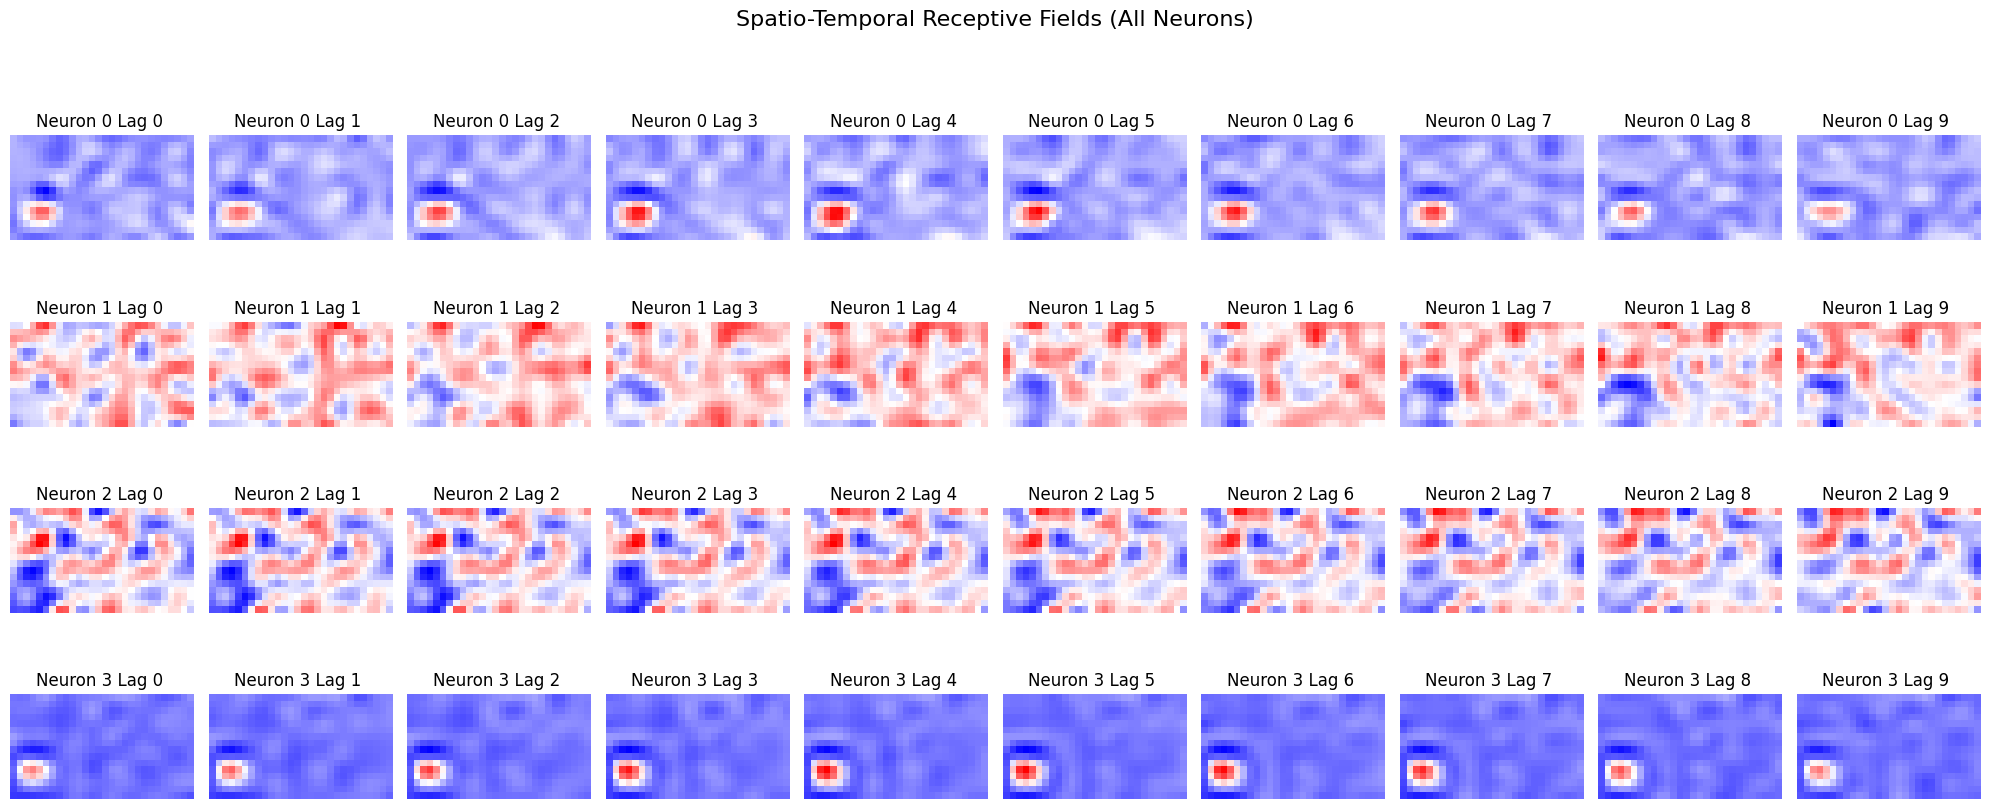

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

w_est_spline_coeffs_off = np.load("")

## 1. Get the dimensions for the plot grid
num_neurons = w_est_spline_coeffs_off.shape[0]
num_lags, stim_h, stim_w = dims
selected_neurons = range(num_neurons)

# 2. Create a single figure with a grid of subplots
# The grid will have 'num_neurons' rows and 'num_lags' columns.
fig, axes = plt.subplots(
    num_neurons,
    num_lags,
    figsize=(num_lags * 2, num_neurons * 2.2),
    squeeze=False,  # Always return a 2D array for axes
)

fig.suptitle("Spatio-Temporal Receptive Fields (All Neurons)", fontsize=16)

# 3. Loop through each neuron and its corresponding row of axes
for neuron_idx, w_flat in enumerate(w_est_spline_coeffs_off):
    neuron_id = selected_neurons[neuron_idx]

    # Reshape the flattened weights to (time, height, width)
    strf = w_flat.reshape(dims)

    # Normalize color scale per-neuron for fair comparison across its own lags
    vmin, vmax = strf.min(), strf.max()

    # Set the y-label for the row to identify the neuron
    axes[neuron_idx, 0].set_ylabel(
        f"Neuron {neuron_id}",
        rotation=0,
        size="large",
        labelpad=40,  # Move label to the left
        ha="right",
        va="center",
    )

    # Loop through each time lag and its column
    for lag_idx in range(num_lags):
        ax = axes[neuron_idx, lag_idx]

        # Plot the spatial receptive field at this lag
        ax.imshow(strf[lag_idx], cmap="bwr", vmin=vmin, vmax=vmax)
        ax.axis("off")  # Hide axis ticks and borders

        # --- CHANGE ---
        # Set a title for every subplot to show its corresponding lag.
        # The 'if' condition that restricted this to the first row is removed.
        ax.set_title(f"Neuron {neuron_id} Lag {lag_idx} ")

# 4. Adjust layout and display the single plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make space for suptitle
plt.show()

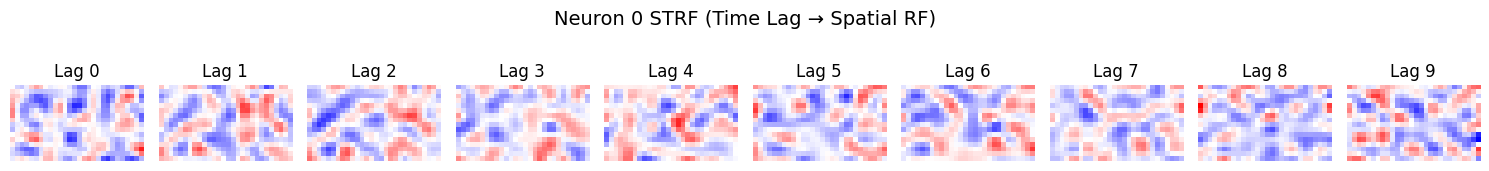

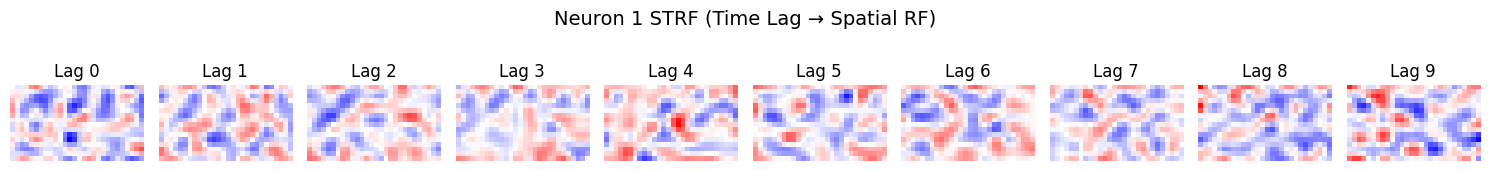

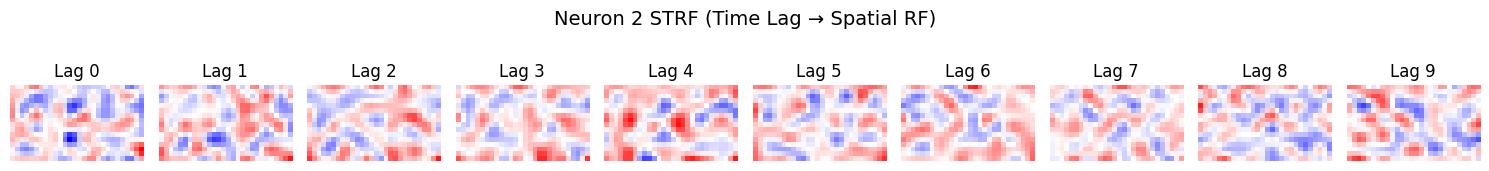

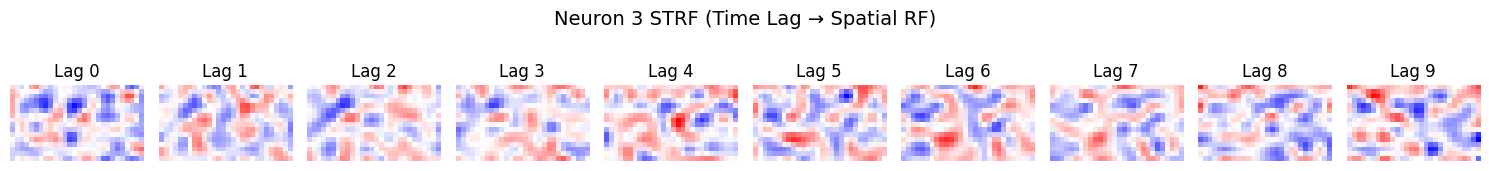

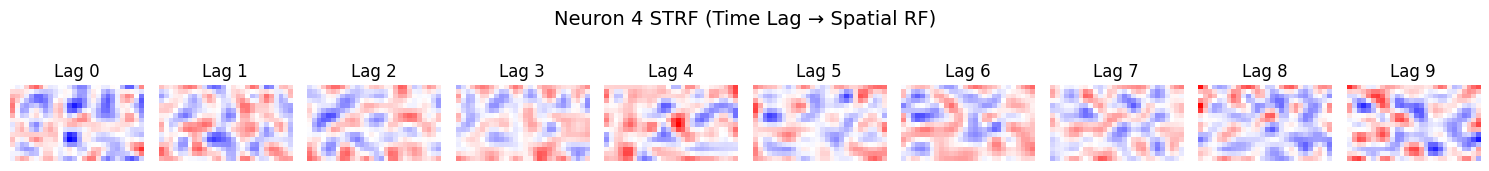

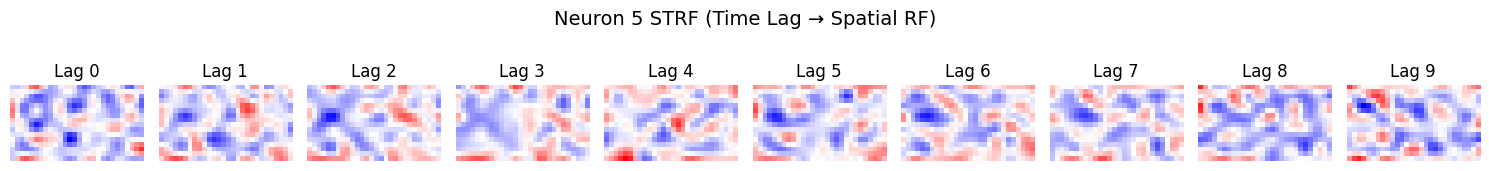

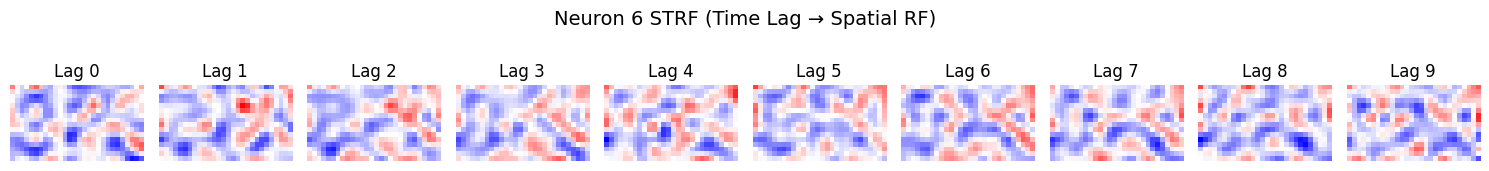

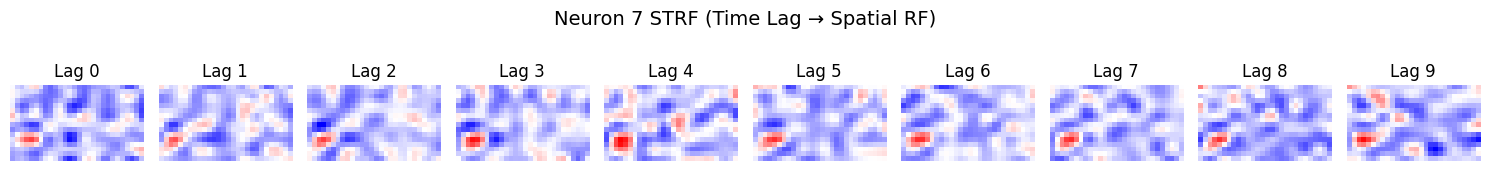

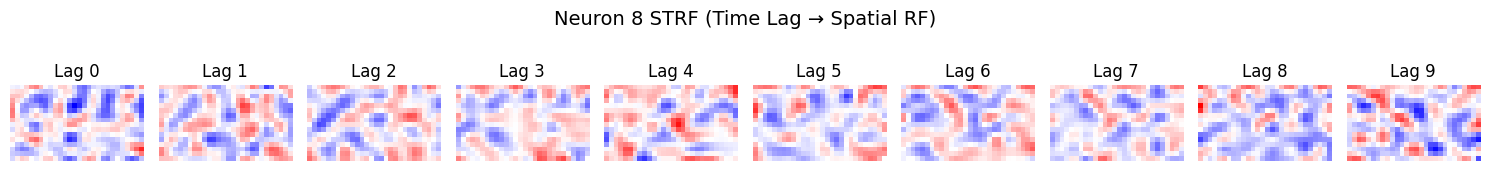

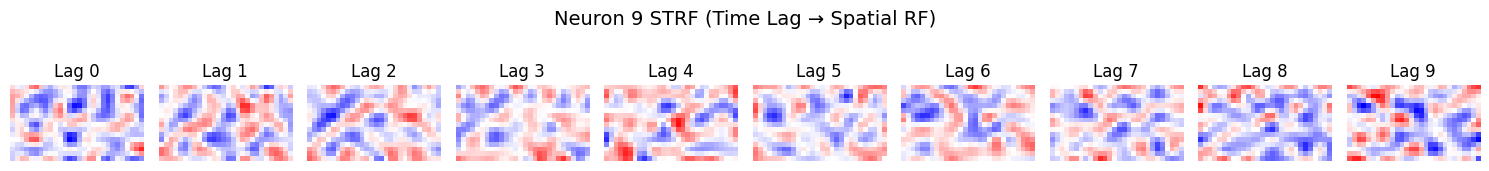

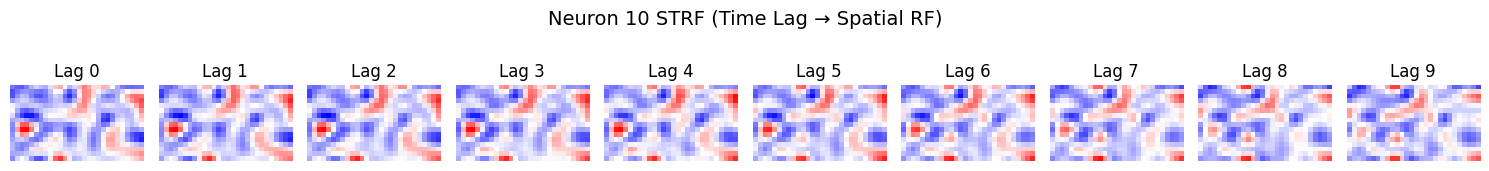

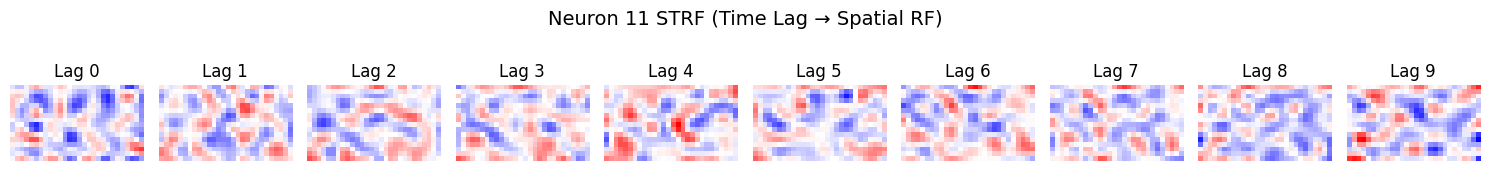

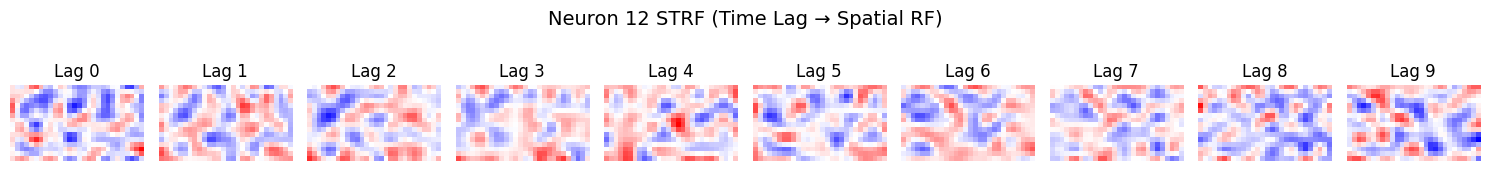

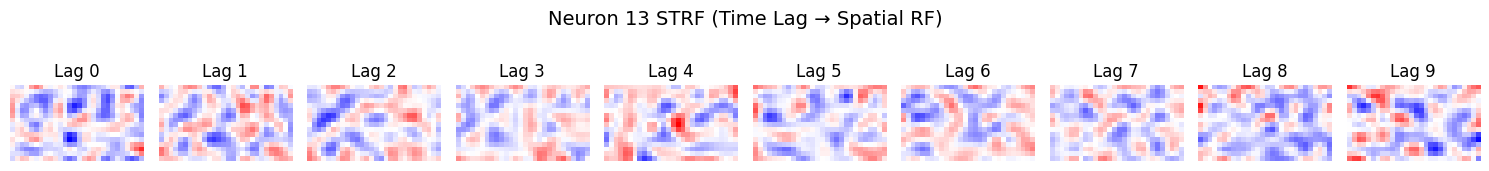

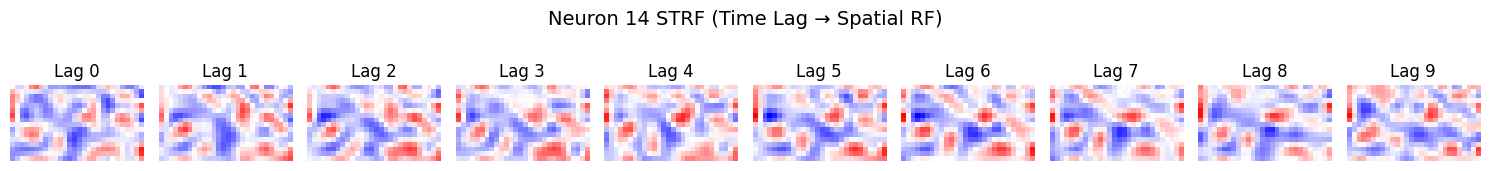

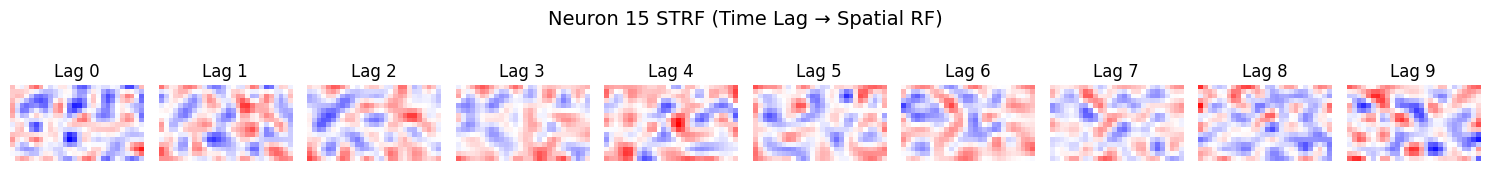

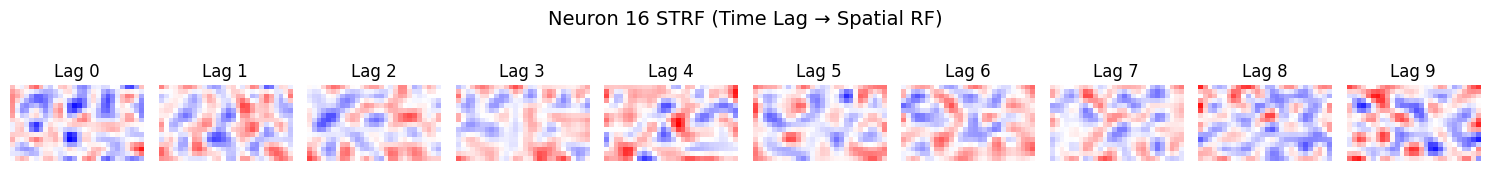

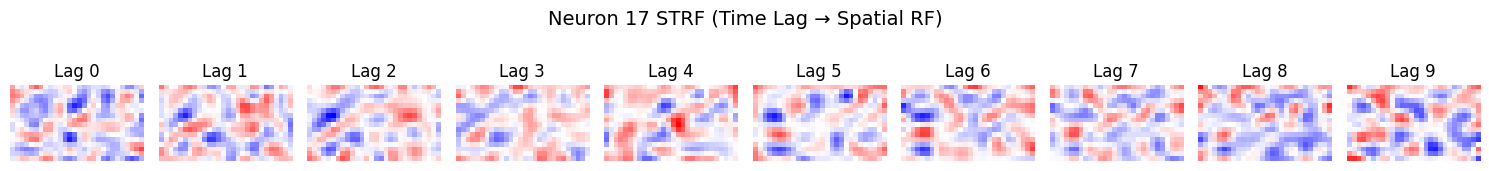

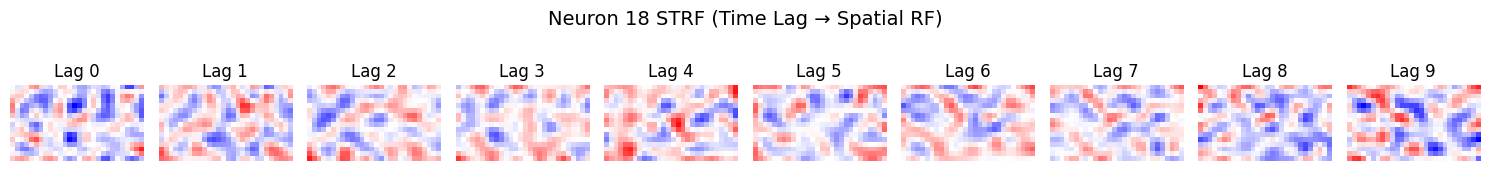

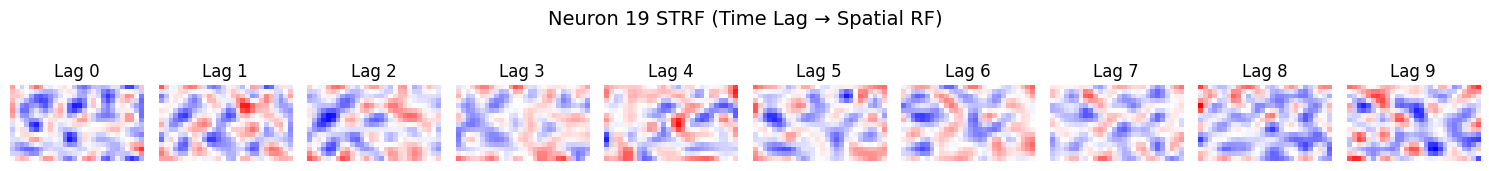

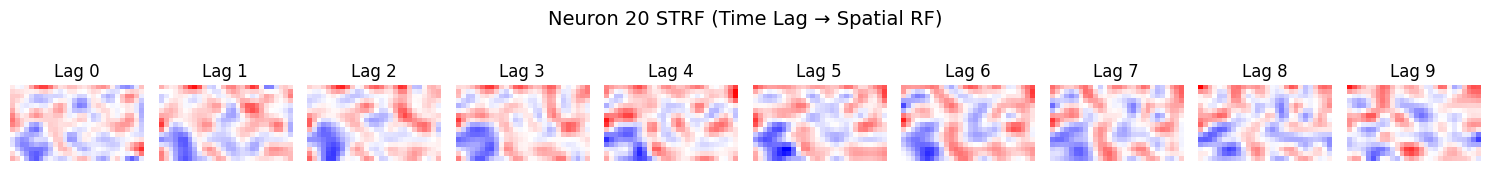

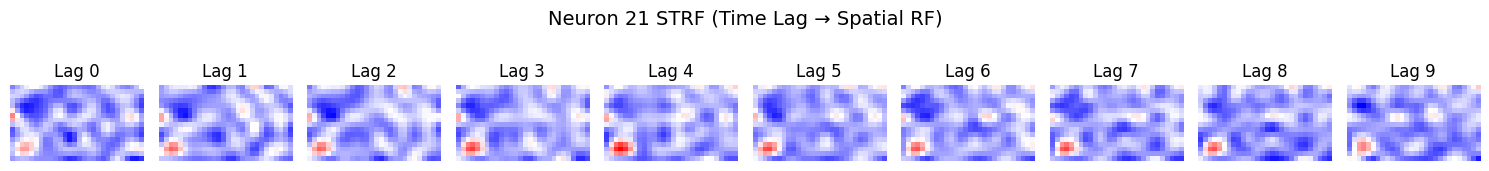

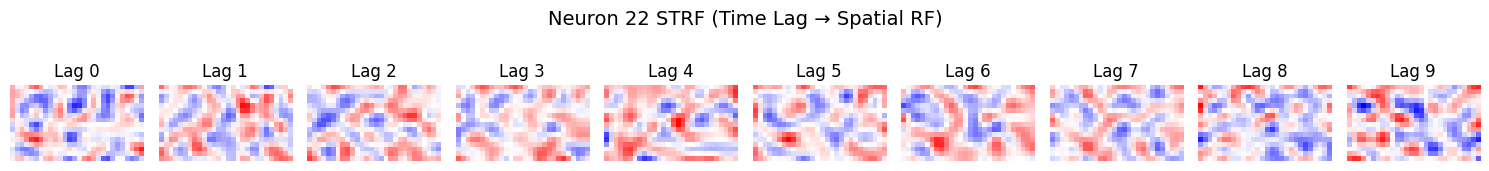

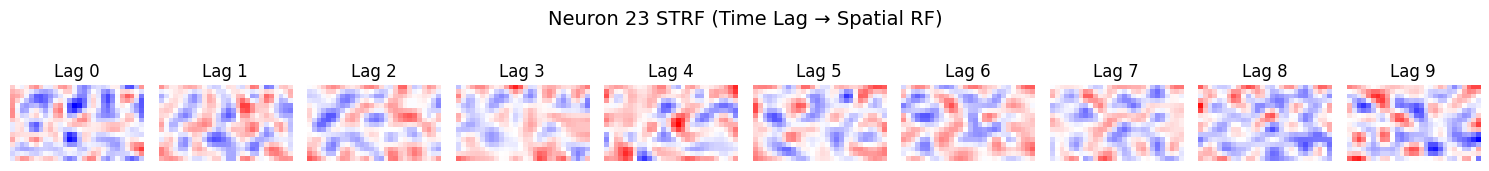

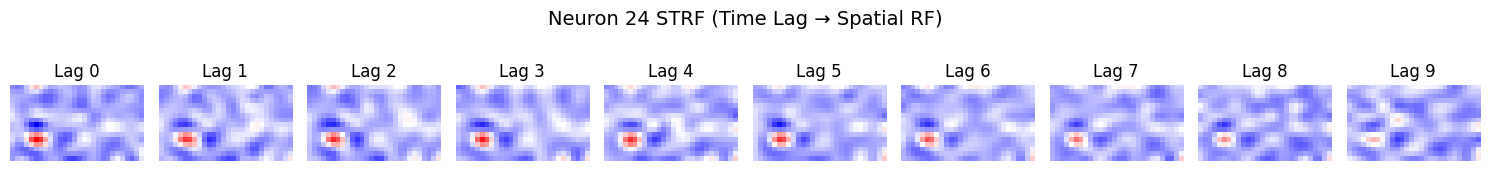

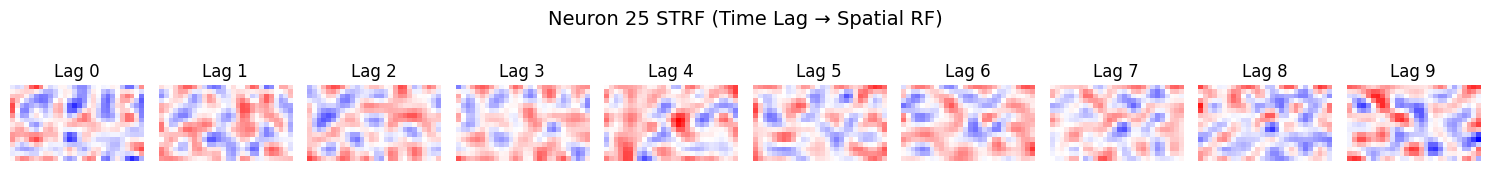

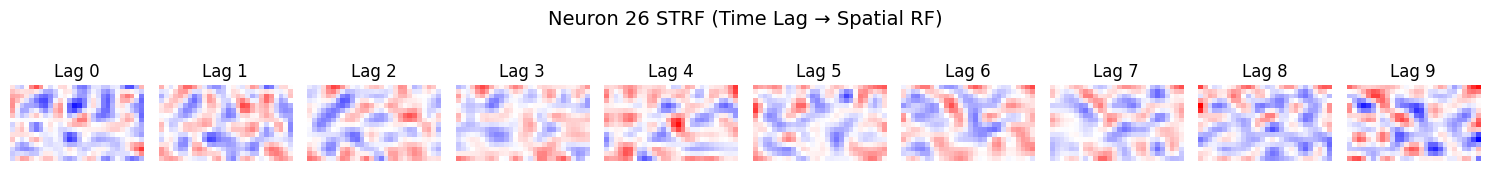

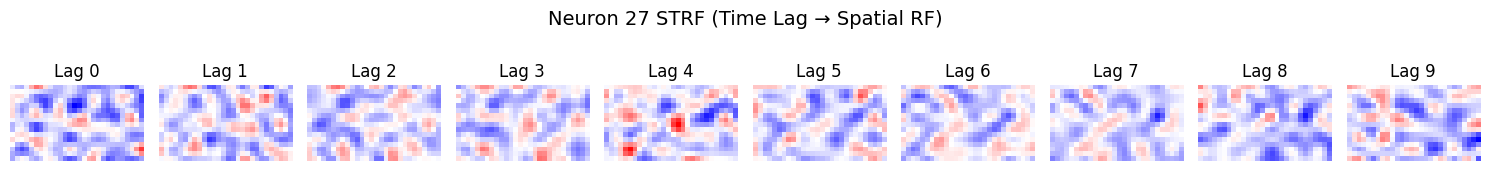

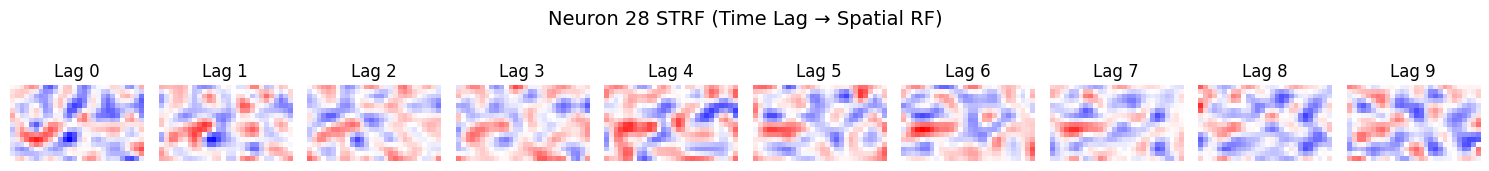

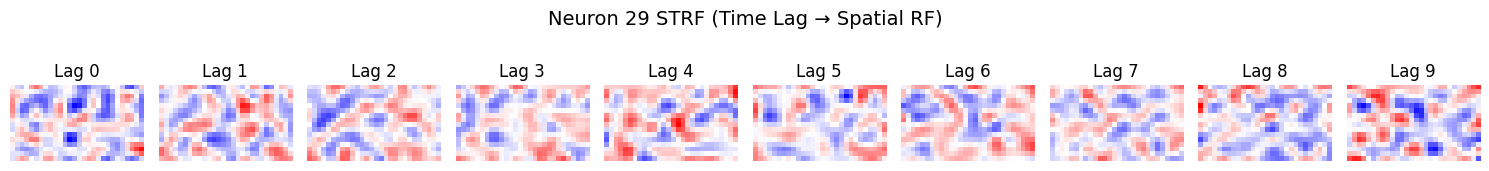

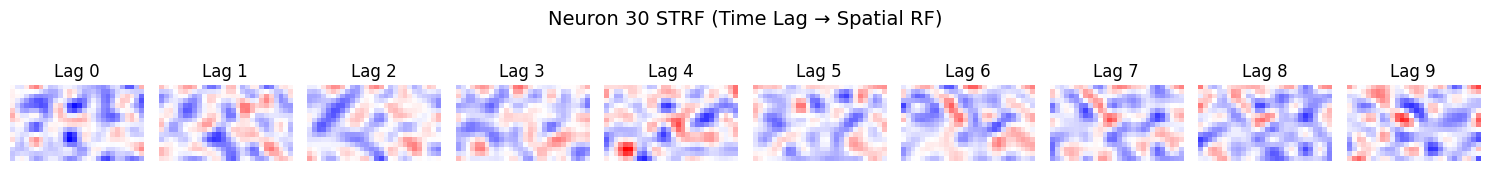

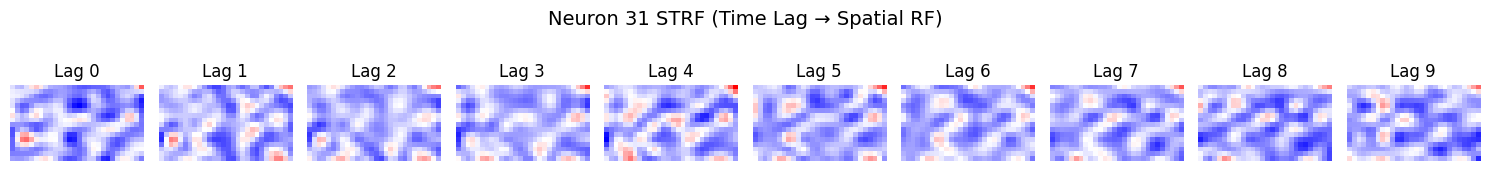

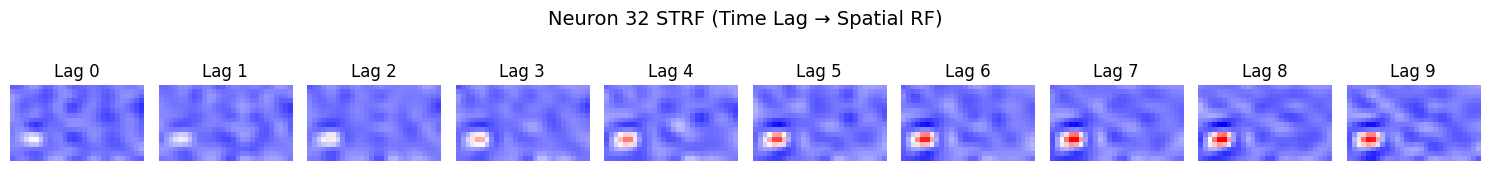

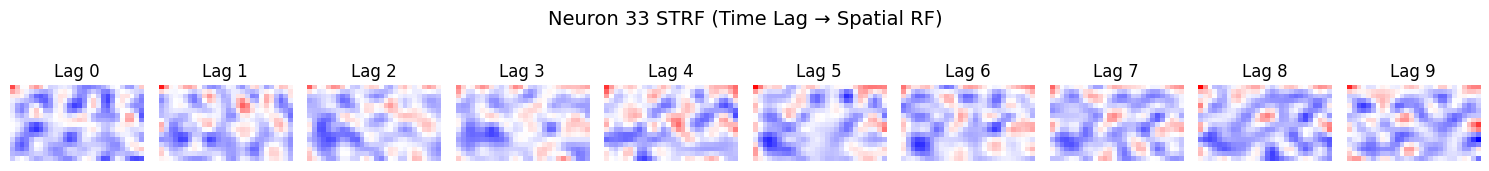

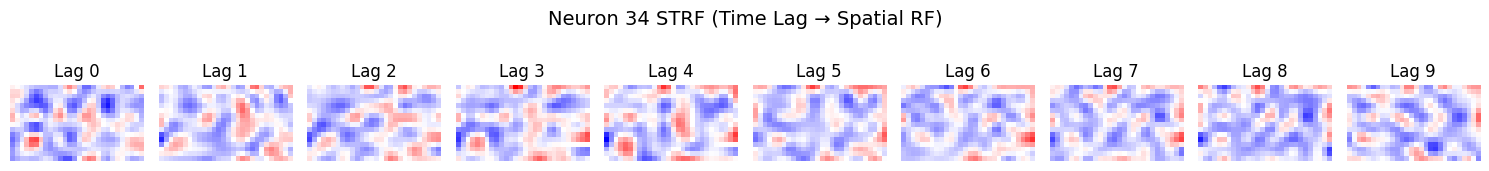

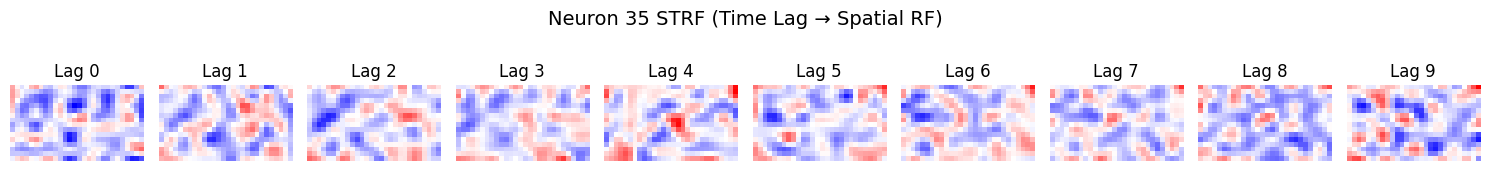

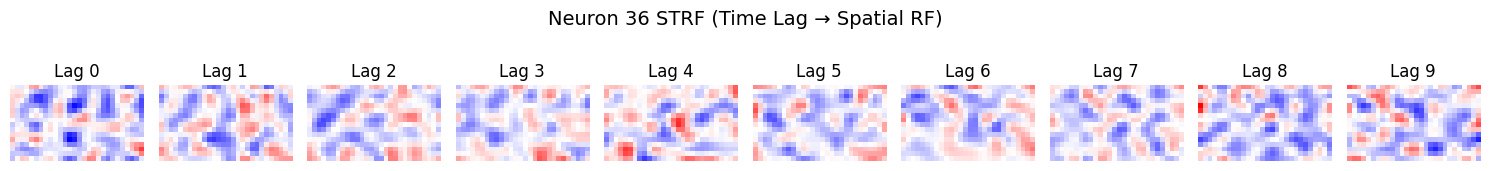

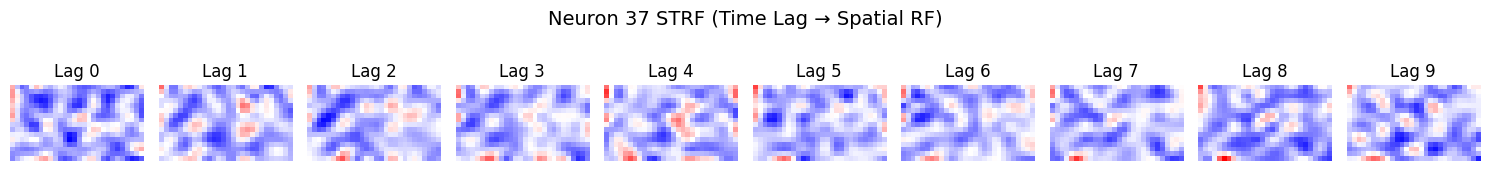

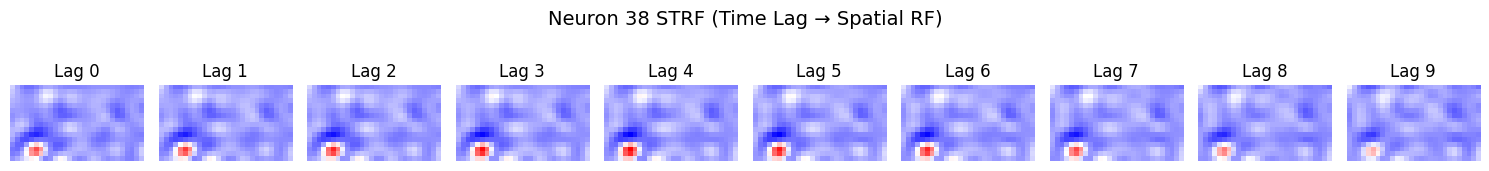

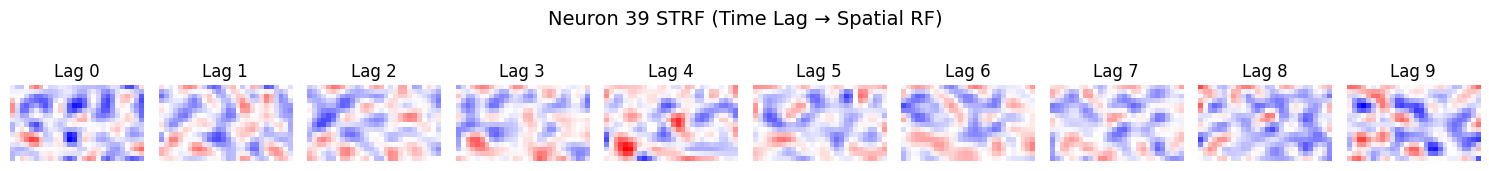

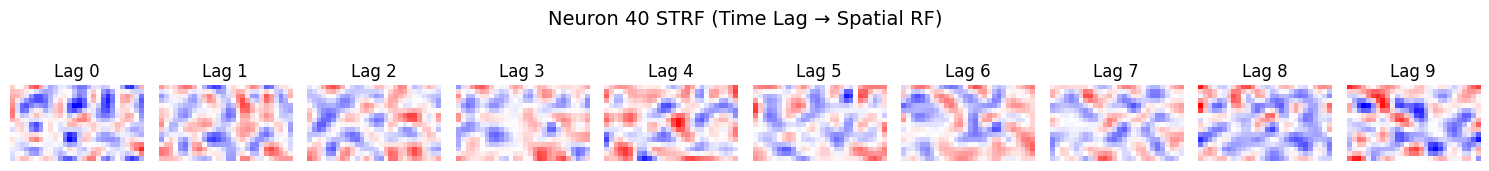

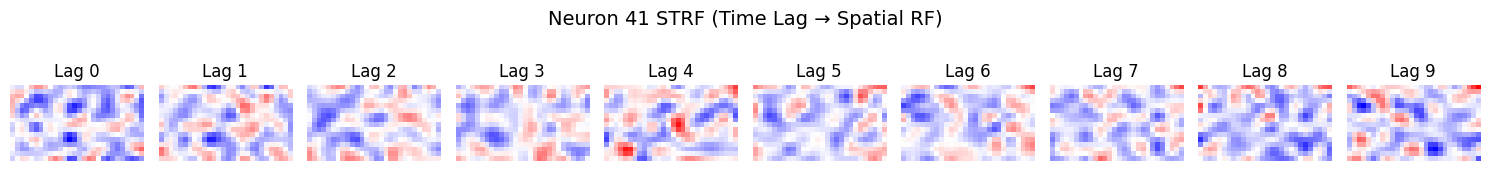

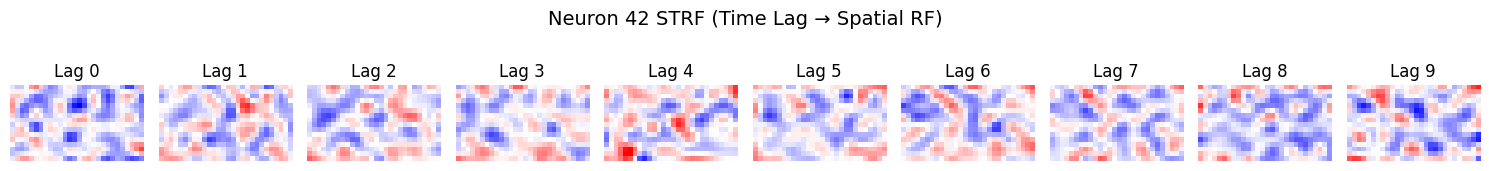

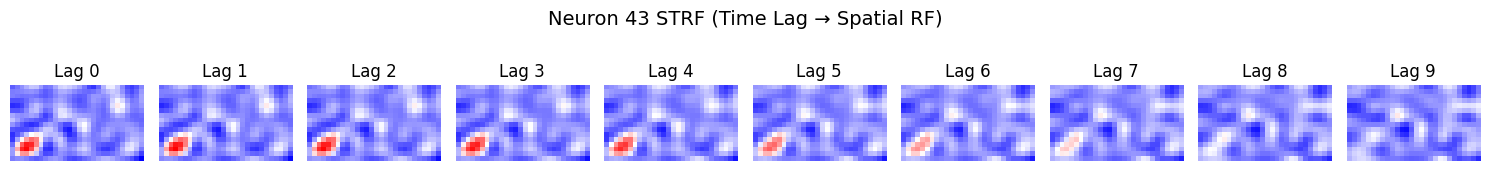

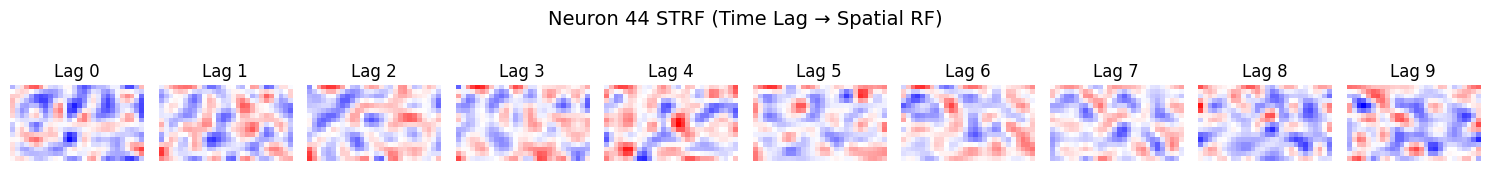

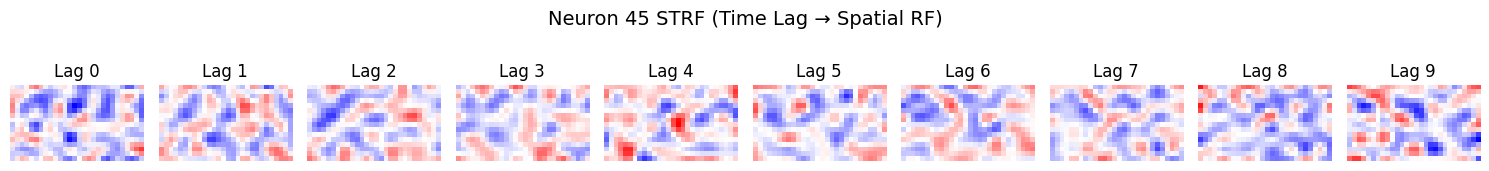

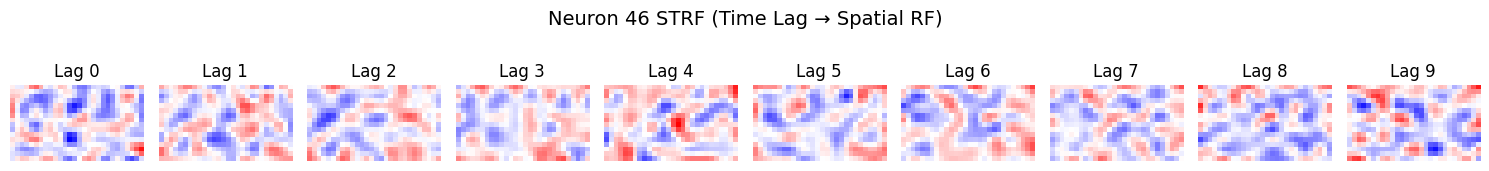

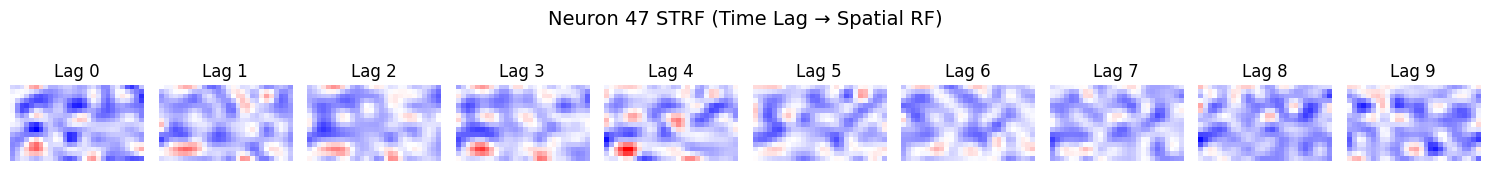

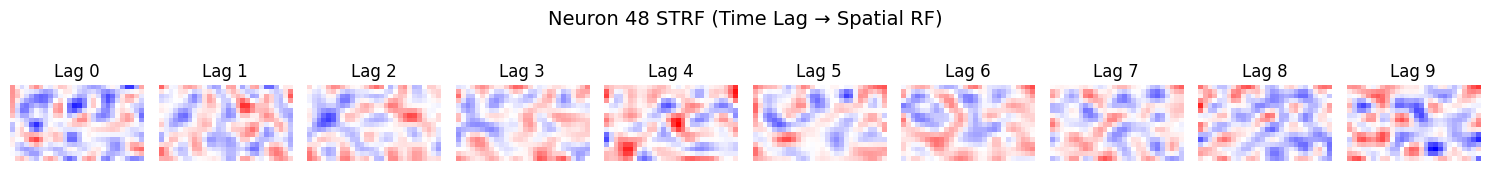

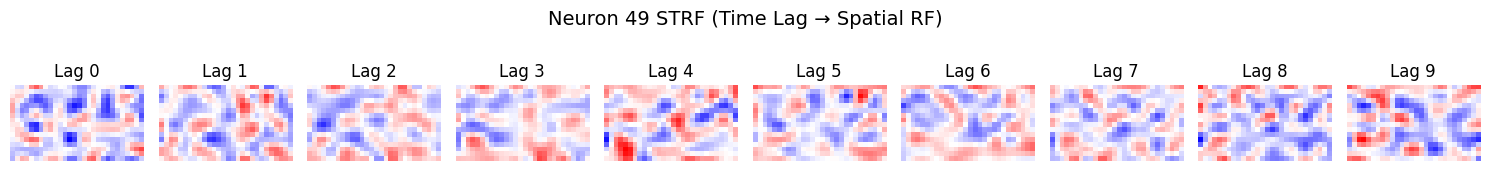

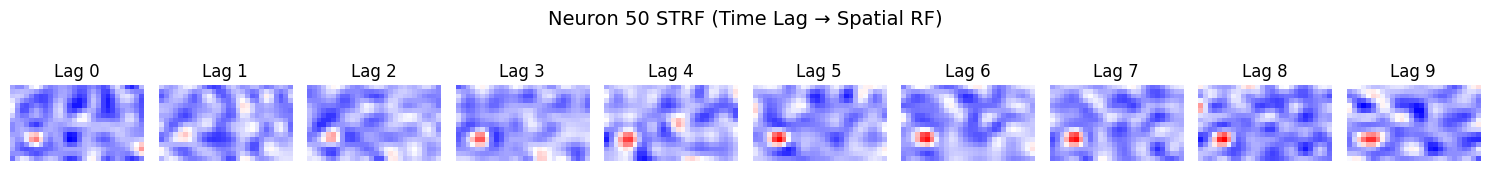

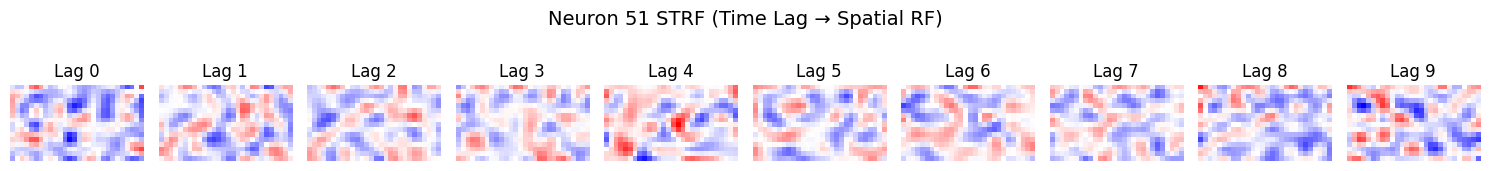

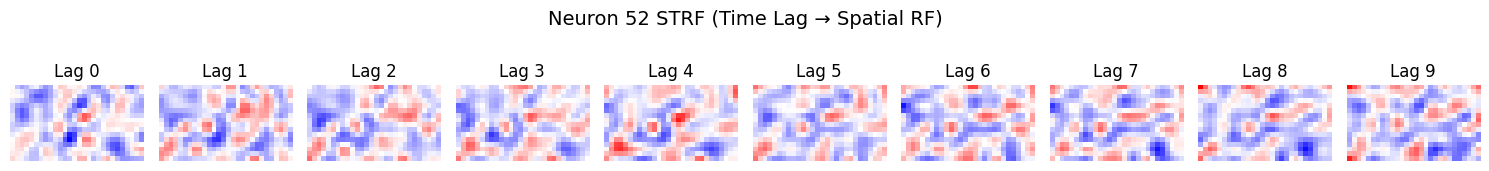

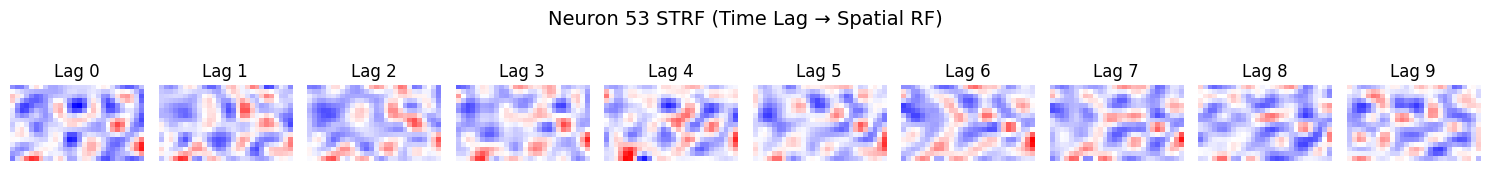

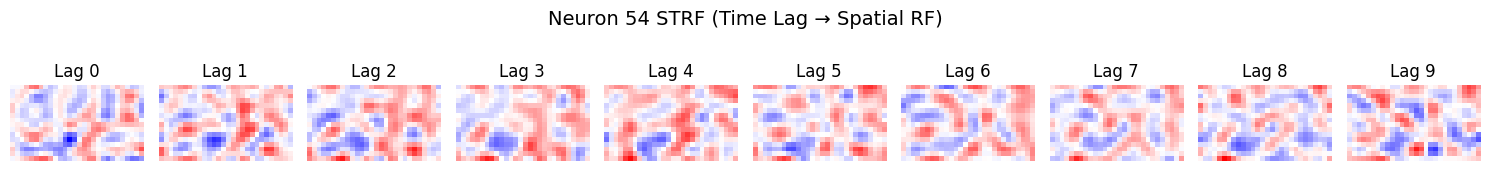

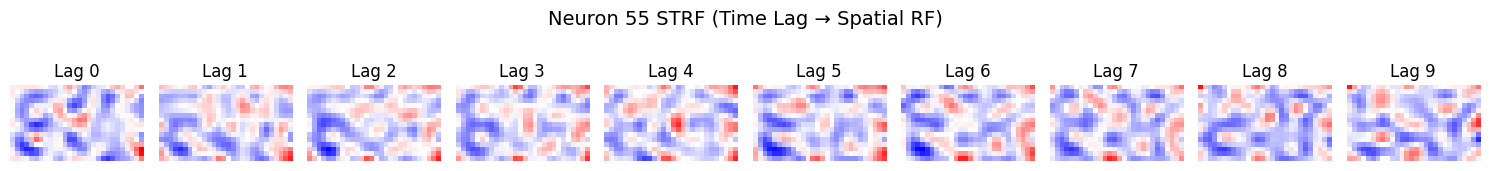

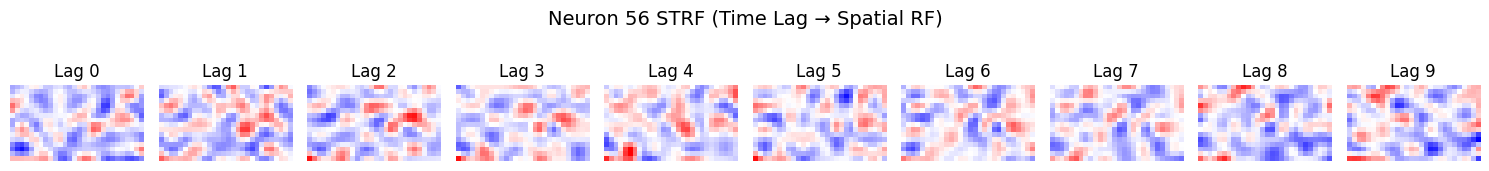

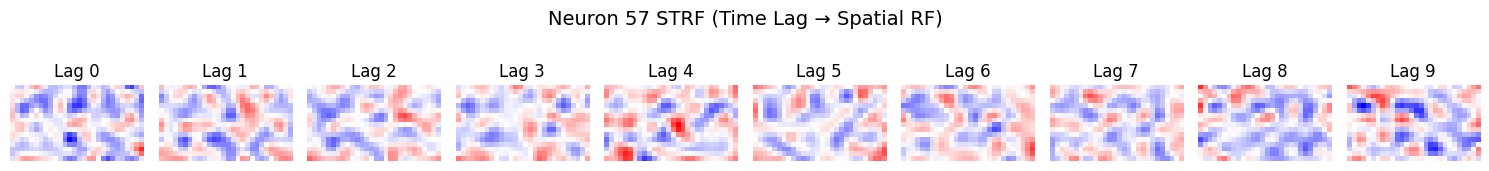

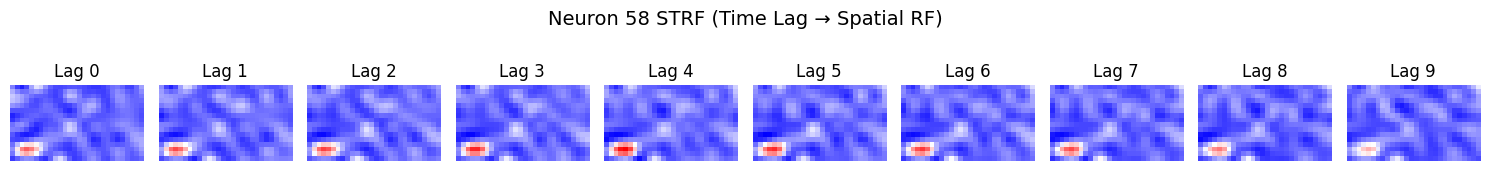

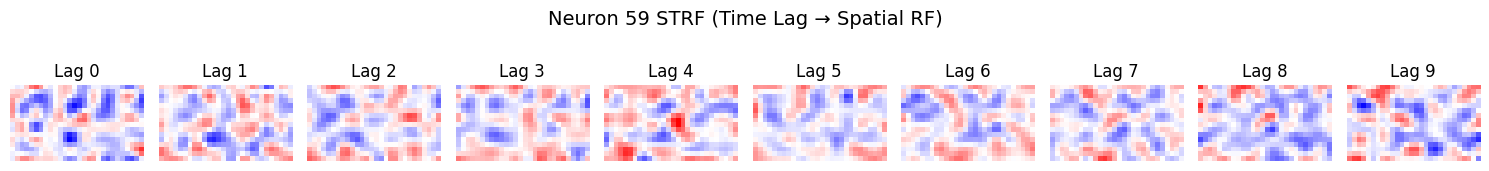

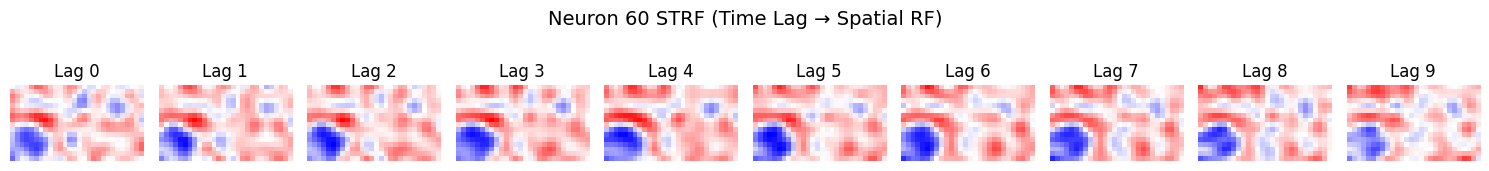

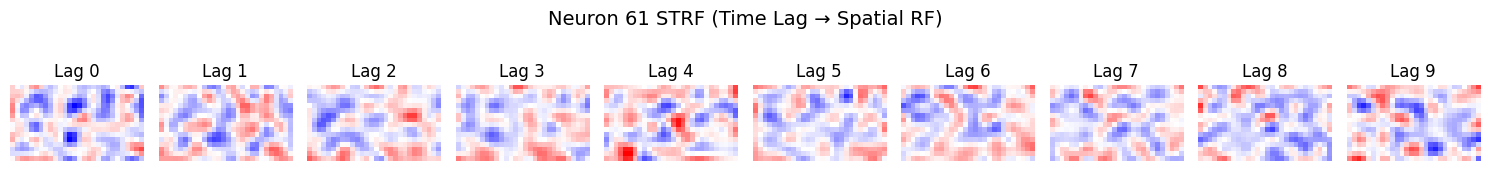

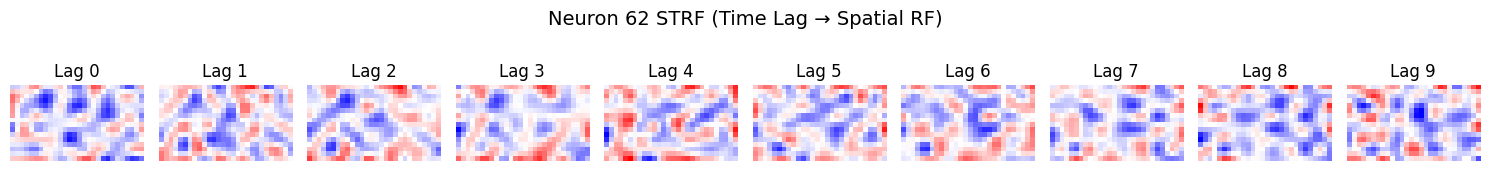

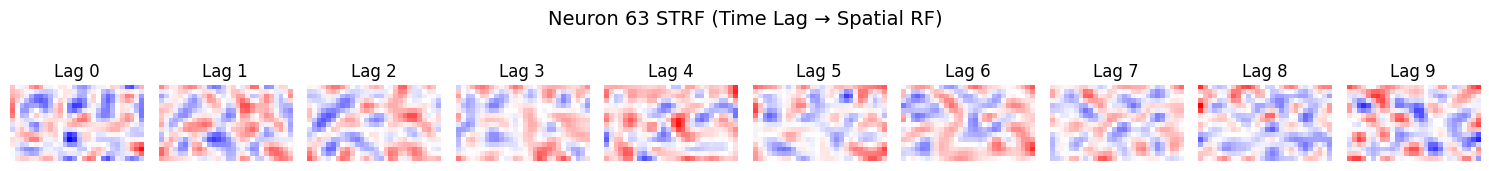

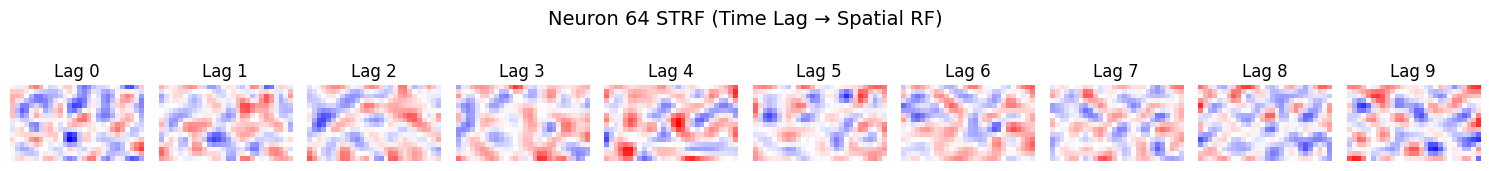

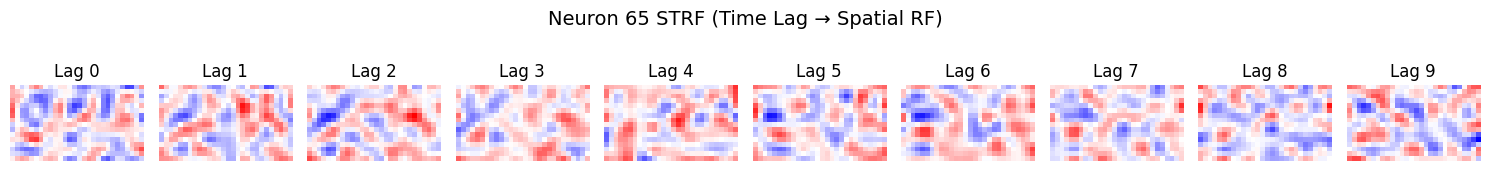

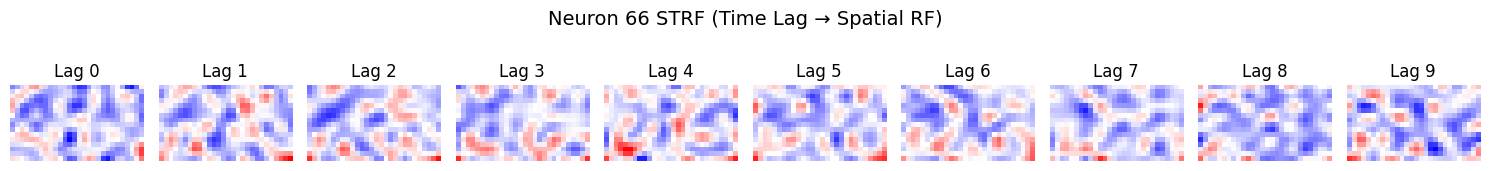

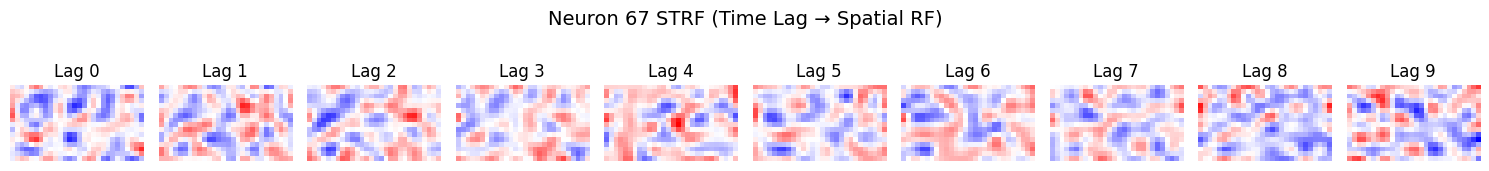

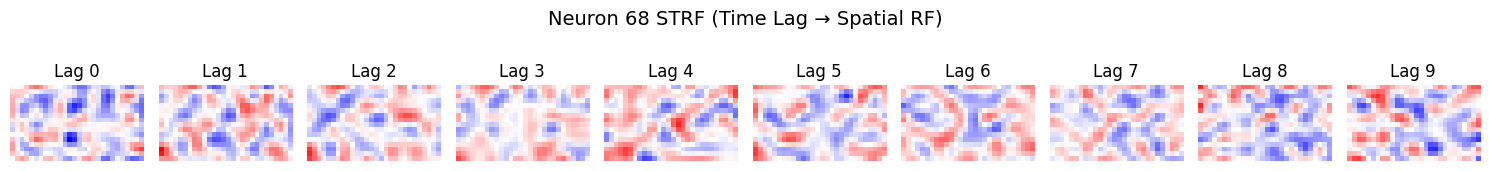

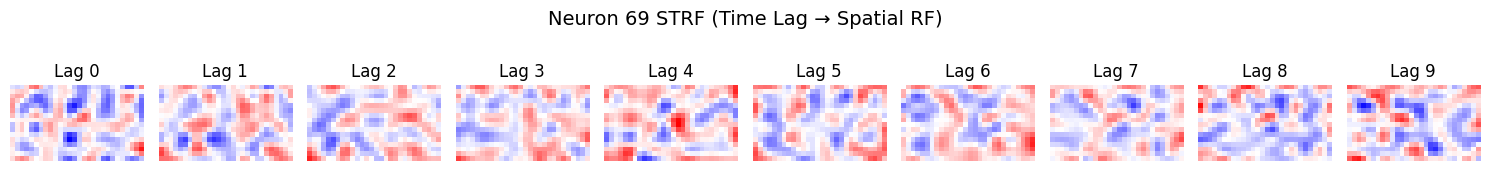

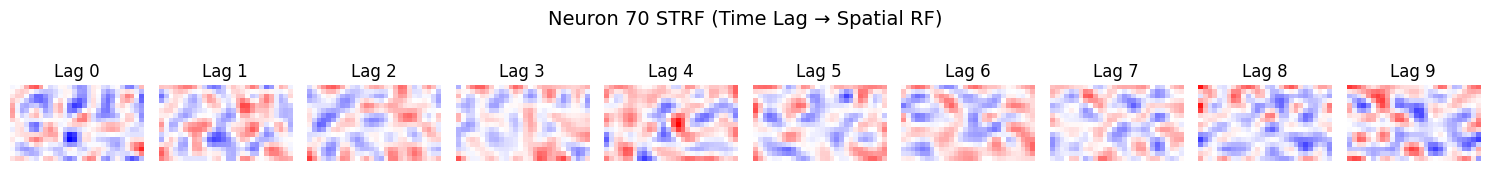

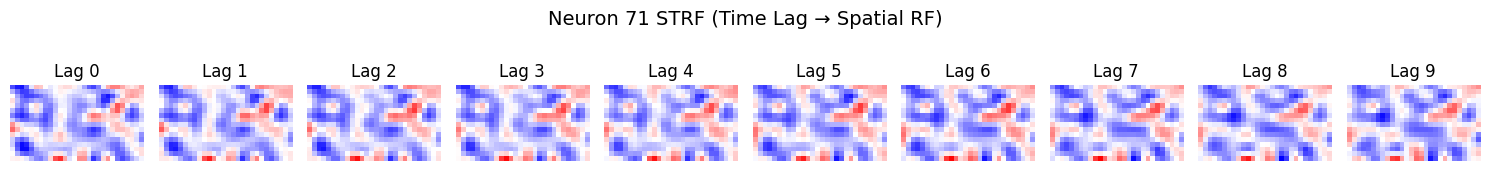

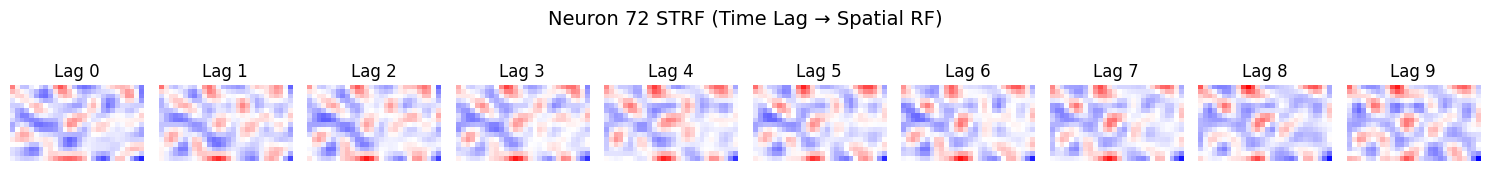

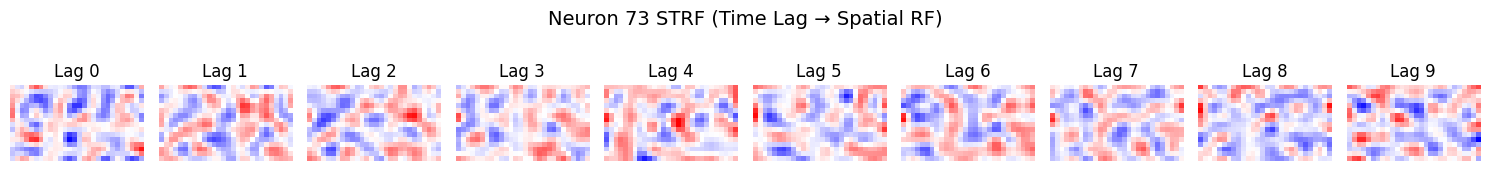

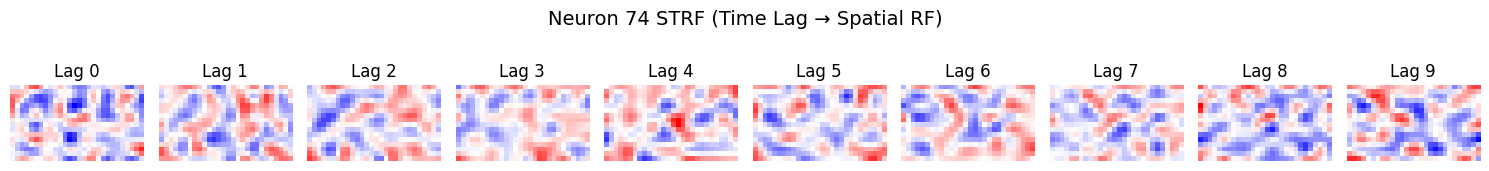

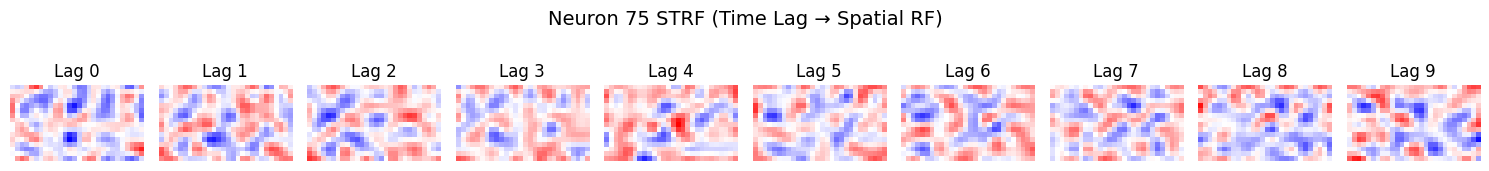

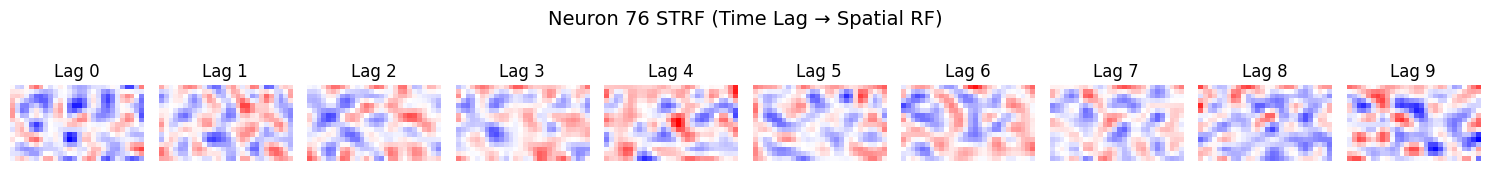

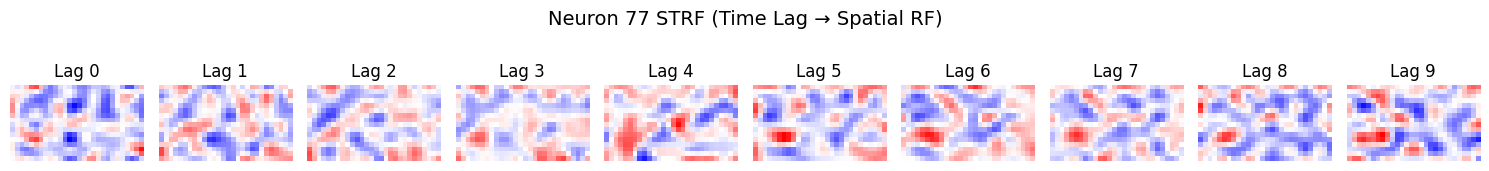

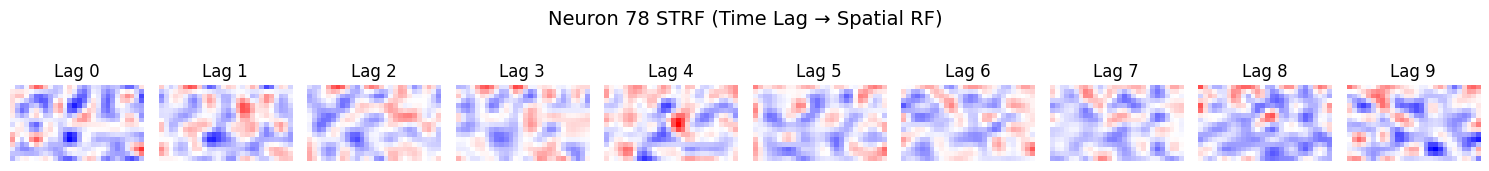

KeyboardInterrupt: 

In [95]:
import matplotlib.pyplot as plt
import numpy as np


w_est_spline_coeffs_on = np.load("final_data/w_est_spline_coeffs_on.npy")

# Reuse dims and selected_neurons
num_lags, stim_h, stim_w = dims
selected_neurons = range(
    w_est_spline_coeffs_on.shape[0]
)  # Assuming all neurons are selected
for idx, w_flat in enumerate(w_est_spline_coeffs_on):
    neuron_idx = selected_neurons[idx]

    # Reshape to (time lags, height, width)
    strf = w_flat.reshape(dims)

    # Plot all lags
    fig, axes = plt.subplots(1, num_lags, figsize=(num_lags * 1.5, 2))
    fig.suptitle(f"Neuron {neuron_idx} STRF (Time Lag → Spatial RF)", fontsize=14)

    # Normalize color scale across all lags for fair comparison
    vmin, vmax = strf.min(), strf.max()
    for t in range(num_lags):
        ax = axes[t]
        ax.imshow(strf[t], cmap="bwr", vmin=vmin, vmax=vmax)
        ax.set_title(f"Lag {t}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Localized Receptive Fields

In [ ]:
import utils

importlib.reload(utils)
from scipy.linalg import svd
import an_utils


def extract_spatial_rf(w_est_spline_coeffs, dims, selected_neurons=None):
    """
    Extract spatial receptive fields from spline coefficients.

    Args:
        w_est_spline_coeffs: Coefficients of the spline fit.
        dims: Dimensions of the receptive field (num_lags, height, width).
        selected_neurons: List of neuron indices to visualize.

    Returns:
        List of spatial receptive fields for each selected neuron.
    """
    if selected_neurons is None:
        selected_neurons = range(w_est_spline_coeffs.shape[0])
    spatial_rf_list = []
    for neuron_idx in selected_neurons:
        neuron_west_spline = w_est_spline_coeffs[neuron_idx]
        # Reshape the flattened w_est back into its spatio-temporal form
        strf_spline = neuron_west_spline.reshape(dims)  # (20, 16, 28)

        num_pixels = stim_h * stim_w
        strf_for_vis = strf_spline.transpose(1, 2, 0).reshape(num_pixels, num_lags)

        # Perform SVD to get the separated components
        w_centered = strf_for_vis - strf_for_vis.mean(axis=1, keepdims=True)
        U, _, Vt = svd(w_centered, full_matrices=False)

        spatial_rf = U[:, 0].reshape(stim_h, stim_w)
        temporal_rf = Vt[0, :]

        # Sign correction for consistent plotting
        if np.abs(np.min(spatial_rf)) > np.abs(np.max(spatial_rf)):
            spatial_rf *= -1
            temporal_rf *= -1

        spatial_rf_list.append(spatial_rf)

    return np.array(spatial_rf_list)


spatial_rfs_on = extract_spatial_rf(w_est_spline_coeffs_on, dims)
gaussian_fits_statistics_df_on = an_utils.quantify_all_rfs(spatial_rfs_on)


spatial_rfs_off = extract_spatial_rf(w_est_spline_coeffs_off, dims)
gaussian_fits_statistics_df_off = an_utils.quantify_all_rfs(spatial_rfs_off)

Quantifying localization for all spatial RFs...
Quantification complete.
Quantifying localization for all spatial RFs...
Quantification complete.


In [ ]:
gaussian_fits_statistics_df_on

neuron_id  r_squared      rf_size   amplitude  rf_center_x  rf_center_y
0          1   0.680112     1.160062    0.406647     4.378046    10.970467
1          0   0.223406     3.541622   -0.089662    20.015310     5.762178
2          3   0.181469  1088.978613 -336.351401    12.062507     9.986501
3          2   0.000000          NaN    0.000000          NaN          NaN

In [ ]:
gaussian_fits_statistics_df_off

neuron_id  r_squared      rf_size  amplitude  rf_center_x  rf_center_y
0          0   0.212961    18.306422  11.973808  -845.079897    33.965709
1          2   0.199807  2232.784403 -72.647891  -219.984143  -298.411775
2          1   0.115332    13.651969  -0.056245    -1.497975    14.276825
3          3   0.000000          NaN   0.000000          NaN          NaN

### Distribution of Gaussian Fits of Receptive Fieldss

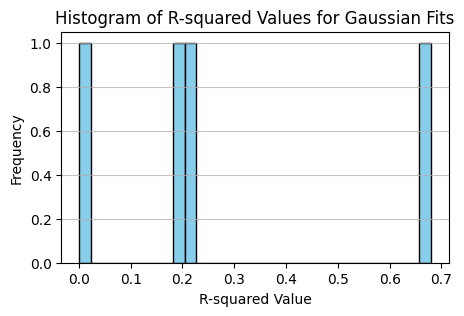

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of R-squared values
plt.figure(figsize=(5, 3))
plt.hist(
    gaussian_fits_statistics_df["r_squared"],
    bins=30,
    color="skyblue",
    edgecolor="black",
)
plt.title("Histogram of R-squared Values for Gaussian Fits")
plt.xlabel("R-squared Value")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

## Filter neurons with R-squared > 0.5


In [ ]:
high_r_squared_neurons = gaussian_fits_statistics_df[
    gaussian_fits_statistics_df["r_squared"] > 0.5
]

In [ ]:
high_r_squared_neurons

neuron_id  r_squared   rf_size  amplitude  rf_center_x  rf_center_y
0          1   0.680112  1.160062   0.406647     4.378046    10.970467

#### Visualize Simple Receptive Fields

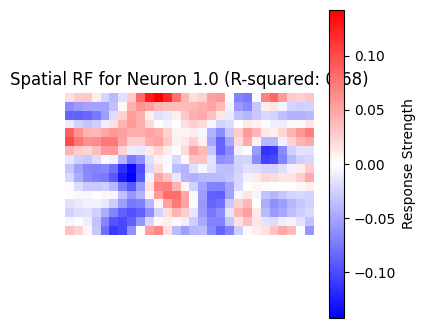

In [ ]:
spatial_rfs = extract_spatial_rf(
    w_est_spline_coeffs,
    dims,
    selected_neurons=high_r_squared_neurons["neuron_id"].tolist(),
)
for idx, row in high_r_squared_neurons.iterrows():
    spatial_rf = spatial_rfs[idx]
    plt.figure(figsize=(4, 4))
    plt.imshow(
        spatial_rf,
        cmap="bwr",
        vmin=-np.max(np.abs(spatial_rf)),
        vmax=np.max(np.abs(spatial_rf)),
    )
    plt.title(
        f"Spatial RF for Neuron {row['neuron_id']} (R-squared: {row['r_squared']:.2f})"
    )
    plt.colorbar(label="Response Strength")
    plt.axis("off")
    plt.show()

In [ ]:
# Calculate the physical (x, y) coordinates for each neuron from its ROI mask
neuron_idxs = (
    high_r_squared_neurons["neuron_id"].tolist()
    if "neuron_id" in high_r_squared_neurons.columns
    else None
)
roi_centroids = []
for idx, neuron_idx in enumerate(neuron_idxs):
    print(
        f"Calculating ROI centroid for neuron {neuron_idx} ({idx+1}/{len(neuron_idxs)})"
    )
    roi_mask_selection = np.array([roi_masks[neuron_idx]])
    roi_centroids.append(U.calculate_roi_centroids(roi_mask_selection))
roi_centroids = np.array(roi_centroids)
roi_centroids = roi_centroids.reshape(
    -1, 2
)  # Ensure shape is (N, 2) for (x, y) coordinates
print(f"All ROI centroids: {roi_centroids.shape}")

# Calculate the functional (x, y) coordinates for each RF from the spatial maps
rf_centers = np.array(
    list(
        zip(
            high_r_squared_neurons["rf_center_x"].values,
            high_r_squared_neurons["rf_center_y"].values,
        )
    )
)
print(f"RF centers shape: {rf_centers.shape if rf_centers is not None else 'N/A'}")
# U.calculate_rf_centers(all_rfs_spatial)


# --- Step 3: Visualize the Retinotopic Map ---
# This is the key visualization that tests the project's hypothesis.
# We create two plots to map the horizontal (X) and vertical (Y) axes.

print("\nGenerating retinotopic maps...")

# Plot 1: Map of the horizontal (X) axis of the visual field
U.plot_retinotopic_map(
    roi_centroids=roi_centroids,
    rf_centers=rf_centers,
    background_image=max_projection_image,
    axis_to_map="x",
)

# Plot 2: Map of the vertical (Y) axis of the visual field
U.plot_retinotopic_map(
    roi_centroids=roi_centroids,
    rf_centers=rf_centers,
    background_image=max_projection_image,
    axis_to_map="y",
)

Calculating ROI centroid for neuron 1 (1/1)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
All ROI centroids: (1, 2)
RF centers shape: (1, 2)

Generating retinotopic maps...


NameError: name 'max_projection_image' is not defined